# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°4: Resolución del problema inverso
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


In [25]:
# Crear un directorio para guardar las gráficas
graficas_dir = os.path.join("graficas", "tp4")

if not os.path.exists(graficas_dir):
    os.makedirs(graficas_dir)

### Clase PINN Navier-stokes

In [26]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow.
    Modelo modificado para predecir solo la presión (p).
    Las velocidades u y v se calculan a partir de la presión usando relaciones físicas.
    """

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = 1  # Solo predecimos presión
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]

        # Número de Reynolds: entrenable o fijo
        if model_parameters.get("LearnRe", False):
            # Aprendemos log(Re) en lugar de Re para estabilizar el gradiente
            initial_re = model_parameters["Re"]
            # Guardamos el parámetro entrenable como self.log_Re
            self.log_Re = nn.Parameter(torch.tensor([np.log(initial_re)], dtype=torch.float32, device=self.Device))
        else:
            # Si no aprendemos Re, guardamos el valor fijo
            self.fixed_Re = torch.tensor([model_parameters["Re"]], dtype=torch.float32, device=self.Device)

        # Definir arquitectura de la red (solo para presión)
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons)
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)  # Solo 1 salida (presión)

        # Inicialización Xavier
        self.init_xavier()

    def get_re(self):
        """
        Devuelve el valor actual de Re.
        Si Re es entrenable, calcula exp(log(Re)).
        Si es fijo, devuelve el valor fijo.
        """
        if hasattr(self, 'log_Re'):
            return torch.exp(self.log_Re)
        else:
            return self.fixed_Re

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 1) con solo la presión (p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds

        # Normalización de entradas a [-1, 1]
        X_norm = 2 * (X - lb) / (ub - lb) - 1

        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X_norm))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        pressure = self.OutputLayer(output)  # Solo presión

        return pressure

    def compute_velocities_from_pressure(self, X, p):
        """
        Calcula las velocidades u y v a partir de la presión usando relaciones físicas.
        """
        try:
            # Get pressure gradients
            p_sum = p.sum()
            p_grad = torch.autograd.grad(
                outputs=p_sum,
                inputs=X,
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]
            
            p_x = p_grad[:, 0:1]
            p_y = p_grad[:, 1:2]
            
            Re = self.get_re()
            
            # CRITICAL CHANGE: Use a different scaling relationship
            # Instead of u = -scale * p_x where scale = 1/Re
            # Use a relationship that's less sensitive to Re changes
            
            # Method 1: Logarithmic scaling (less sensitive)
            scale = 1.0 / (torch.log(Re + 1.0) + 1.0)
            
            # Method 2: Square root scaling (even less sensitive) 
            # scale = 1.0 / torch.sqrt(Re + 1.0)
            
            # Method 3: Clamped scaling (prevents extreme Re effects)
            # re_clamped = torch.clamp(Re, min=20.0, max=100.0)
            # scale = 1.0 / re_clamped
            
            u = -scale * p_x * 10.0  # Amplify to compensate for reduced scaling
            v = -scale * p_y * 10.0
            
            return u, v
        
        except Exception as e:
            print(f"Error in velocity computation: {e}")
            batch_size = X.shape[0]
            device = X.device
            u = torch.zeros((batch_size, 1), device=device, dtype=X.dtype)
            v = torch.zeros((batch_size, 1), device=device, dtype=X.dtype)
            return u, v
        

    def get_full_solution(self, X):
        """
        Obtiene la solución completa (u, v, p) donde u y v se calculan a partir de p
        """
        """
    Version of get_full_solution optimized for evaluation/plotting
    """
        # Ensure we have a fresh tensor with gradients
        if not X.requires_grad:
            X = X.clone().detach().requires_grad_(True)

        # Ensure model is in eval mode
        was_training = self.training
        self.eval()

        try:
            p = self.forward(X)
            u, v = self.compute_velocities_from_pressure(X, p)
            uvp = torch.cat([u, v, p], dim=1)
            return uvp
        finally:
            # Restore training mode
            if was_training:
                self.train()

    def predict(self, X):
        """
        Predicción directa de u, v, p donde u y v se calculan a partir de p.
        """
        if not X.requires_grad:
            X.requires_grad_(True)
            
        p = self.forward(X)
        u, v = self.compute_velocities_from_pressure(X, p)
        return u, v, p

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias más pequeño para estabilidad
                torch.nn.init.uniform_(m.bias, -0.01, 0.01)

        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        Nota: uvp puede venir de get_full_solution() o ser calculado externamente
        """
        if uvp.shape[1] == 1:  # Si solo tenemos presión
            uvp = self.get_full_solution(X)
        
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión

        # Obtenemos Re usando el nuevo método
        Re = self.get_re()

        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]

        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]

        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]

        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]

        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]

        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)

        # Residuo de continuidad
        residue_continuity = u_x + v_y

        return residue_u, residue_v, residue_continuity

    def compute_residual_norm(self, X):
        if not X.requires_grad:
            X.requires_grad_(True)
        uvp = self.get_full_solution(X)
        r_u, r_v, _ = self.navierstokesResidue(X, uvp)
        residual_norm = (r_u ** 2 + r_v ** 2).squeeze()
        return residual_norm

In [27]:
class ReynoldsLRScheduler:
    def __init__(self, optimizer, target_re=50.0):
        self.optimizer = optimizer
        self.target_re = target_re
        
    def step(self, current_re):
        # Reduce Re learning rate if it's deviating too much
        deviation = abs(current_re - self.target_re)
        
        if deviation > 10.0:  # Large deviation
            re_lr_factor = 0.1
        elif deviation > 5.0:  # Moderate deviation
            re_lr_factor = 0.3
        else:  # Small deviation
            re_lr_factor = 1.0
            
        # Adjust learning rates
        for param_group in self.optimizer.param_groups:
            if 'log_Re' in str(param_group.get('name', '')):
                param_group['lr'] *= re_lr_factor

# EMERGENCY FIX 4: Reset Re if it goes too low
def reset_re_if_needed(model, threshold=15.0, target=50.0):
    """
    Emergency reset of Re if it drops too low
    """
    current_re = model.get_re().item()
    
    if current_re < threshold:
        print(f"EMERGENCY: Re ({current_re:.2f}) below threshold ({threshold})")
        print(f"Resetting Re to {target}")
        
        if hasattr(model, 'log_Re'):
            with torch.no_grad():
                model.log_Re.data = torch.tensor([np.log(target)], 
                                                device=model.log_Re.device,
                                                dtype=model.log_Re.dtype)
        return True
    return False


#### Configuración del dominio y condiciones de borde

In [28]:
# Parámetros del problema
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [29]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

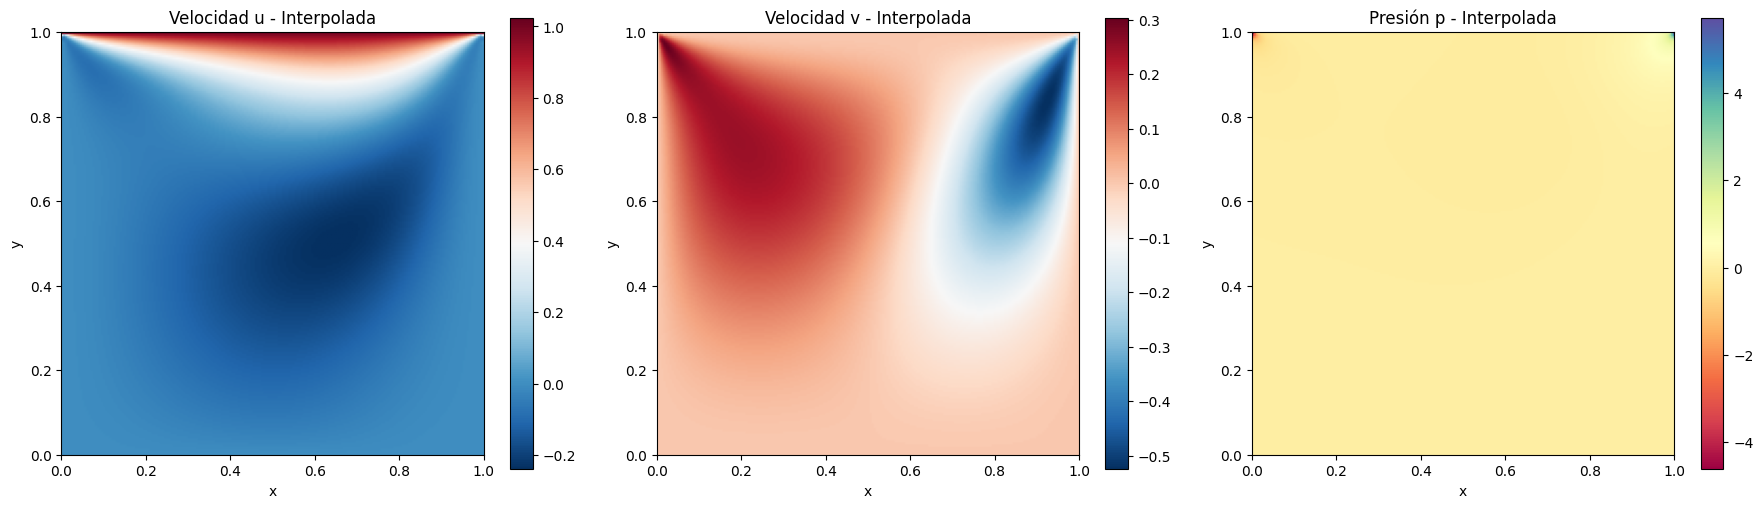

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

#### Muestreo por Hipercubo Latino (LHS)

In [31]:
def lhs_1d(N, device):
    """
    Realiza muestreo por hipercubo latino en 1D.
    Divide el intervalo [0,1] en N subintervalos y toma un punto aleatorio en cada uno,
    luego los mezcla aleatoriamente.
    """
    intervals = torch.linspace(0, 1, N + 1, device=device)
    lower_bounds = intervals[:-1]
    upper_bounds = intervals[1:]
    points = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(N, device=device)
    return points[torch.randperm(N)]

def latin_hypercube_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo por hipercubo latino (LHS).
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    x_pde = lhs_1d(N_pde, device)
    y_pde = lhs_1d(N_pde, device)
    pde_points = torch.stack([x_pde, y_pde], dim=1)

    N_each = N_bc // 4
    rand = lhs_1d(N_each, device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

### 1. Construir tres datasets con $N_{data}$ = 25 a partir de los datos ground-truth del problema.

_Para ello, extraerán los valores de 𝒖 y 𝑝 de grillas regulares cuadradas de 5×5. La región cuadrada en la que se inscriben tales grillas debe estar centrada en Ω y con sus aristas paralelas a las de la cavidad, y con los siguientes tamaños:_
- a) 0,25 × 0,25,
- b) 0,50 × 0,50,
- c) 0,75 × 0,75.

In [32]:
def get_labeled_data(center=(0.5, 0.5), size=0.25, grid_resolution=5):
    """
    Extrae una grilla cuadrada de puntos (x,y) en el dominio, centrada en `center` y con lado `size`.
    Interpola u, v, p desde los campos ground-truth.

    Devuelve:
    - coords_tensor: tensor (25,2) de coordenadas (x,y)
    - labels_tensor: tensor (25,3) de [u, v, p]
    """
    x0, y0 = center
    half = size / 2
    xs = np.linspace(x0 - half, x0 + half, grid_resolution)
    ys = np.linspace(y0 - half, y0 + half, grid_resolution)
    XX, YY = np.meshgrid(xs, ys)
    coords = np.stack([XX.ravel(), YY.ravel()], axis=1)

    # Interpolación desde las grillas
    u_vals = griddata((X_grid.ravel(), Y_grid.ravel()), U_grid.ravel(), coords, method='cubic')
    v_vals = griddata((X_grid.ravel(), Y_grid.ravel()), V_grid.ravel(), coords, method='cubic')
    p_vals = griddata((X_grid.ravel(), Y_grid.ravel()), P_grid.ravel(), coords, method='cubic')

    # Convertir a tensores
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(np.stack([u_vals, v_vals, p_vals], axis=1), dtype=torch.float32, device=device)

    return coords_tensor, labels_tensor

In [33]:
def plot_labeled_datasets(coords_list, labels_list, sizes):
    """
    Crea 4 subplots:
    - uno para cada grilla (0.25, 0.5, 0.75)
    - uno con los tres combinados como el gráfico original
    """
    colors = ['red', 'green', 'blue']
    _, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()

    for i, (coords, labels, size) in enumerate(zip(coords_list, labels_list, sizes)):
        coords_np = coords.detach().cpu().numpy()
        u_np = labels[:, 0].detach().cpu().numpy()
        v_np = labels[:, 1].detach().cpu().numpy()

        axs[i].quiver(coords_np[:, 0], coords_np[:, 1], u_np, v_np,
                      angles='xy', scale_units='xy', scale=5, color=colors[i])
        axs[i].scatter(coords_np[:, 0], coords_np[:, 1], s=20, color=colors[i])
        axs[i].set_title(f"Grilla {size}×{size}")
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 1)
        axs[i].grid(True)
        axs[i].set_aspect('equal')
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("y")

    # Último subplot: todos juntos
    for i, (coords, labels, size) in enumerate(zip(coords_list, labels_list, sizes)):
        coords_np = coords.detach().cpu().numpy()
        u_np = labels[:, 0].detach().cpu().numpy()
        v_np = labels[:, 1].detach().cpu().numpy()
        axs[3].quiver(coords_np[:, 0], coords_np[:, 1], u_np, v_np,
                      angles='xy', scale_units='xy', scale=5, color=colors[i], label=f"{size}×{size}")
        axs[3].scatter(coords_np[:, 0], coords_np[:, 1], s=10, color=colors[i])

    axs[3].set_title("Todas las grillas superpuestas")
    axs[3].legend(loc='lower right')
    axs[3].set_xlim(0, 1)
    axs[3].set_ylim(0, 1)
    axs[3].grid(True)
    axs[3].set_aspect('equal')
    axs[3].set_xlabel("x")
    axs[3].set_ylabel("y")

    plt.tight_layout()
    plt.show()

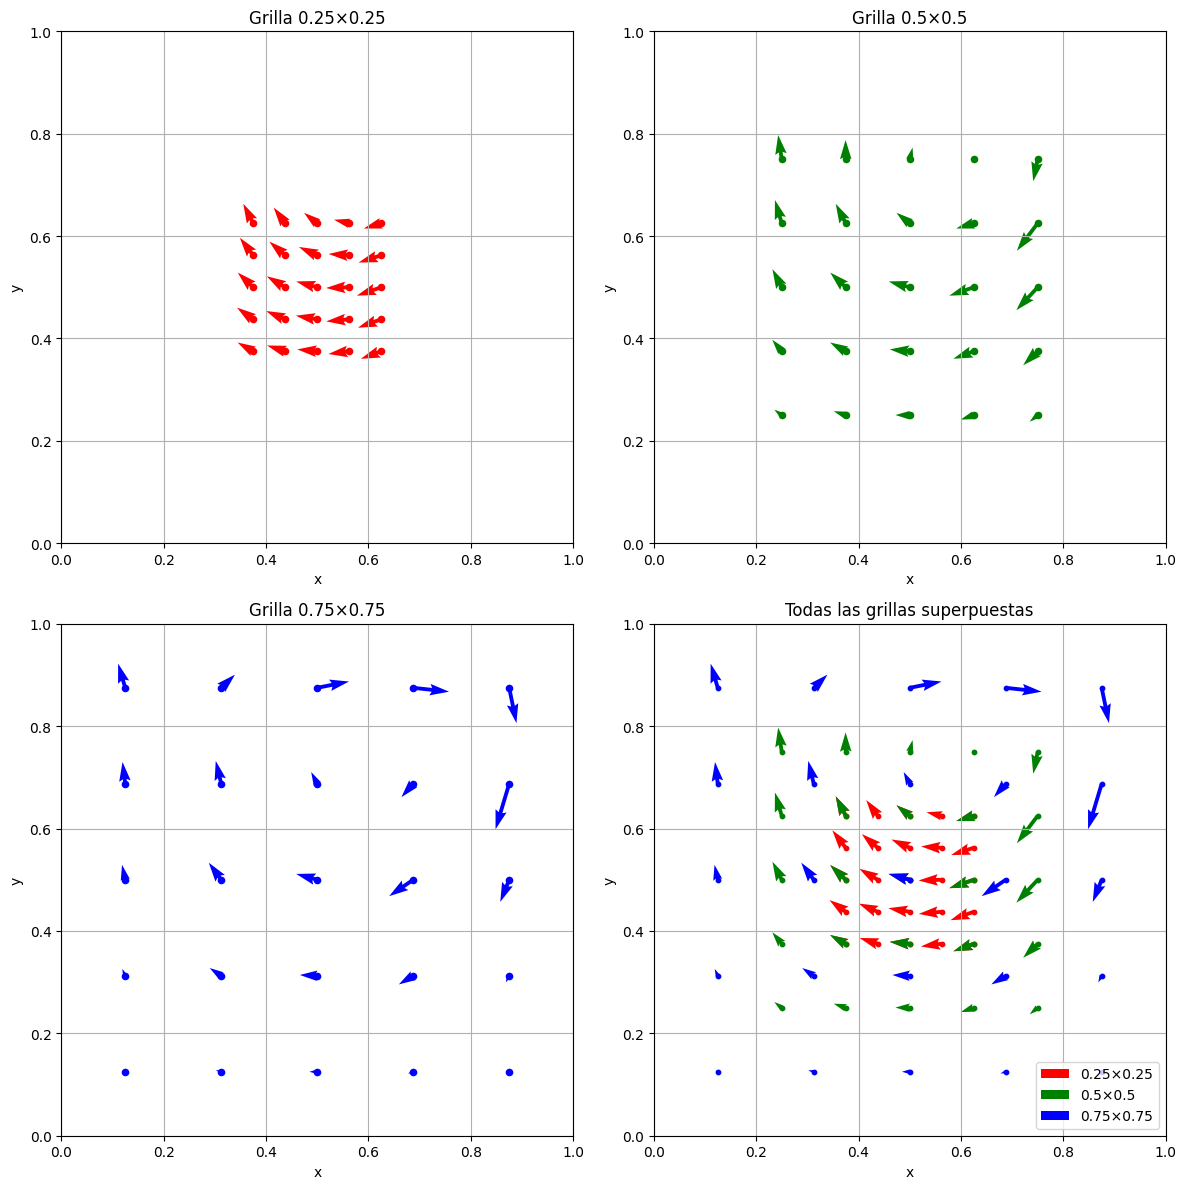

In [34]:
coords_025, labels_025 = get_labeled_data(size=0.25)
coords_050, labels_050 = get_labeled_data(size=0.50)
coords_075, labels_075 = get_labeled_data(size=0.75)

plot_labeled_datasets(coords_list=[coords_025, coords_050, coords_075],labels_list=[labels_025, labels_050, labels_075],sizes=[0.25, 0.50, 0.75])

### 2. En cada grilla, considerar el caso de datos “limpios” (es decir, sin ruido), y afectados por ruido blanco, con un nivel de 0.01 % del valor máximo del campo correspondiente en la región considerada.

In [35]:
def add_white_noise(labels_tensor, noise_level):
    """
    Agrega ruido blanco a cada componente del tensor (u, v, p)
    El ruido es proporcional al valor máximo absoluto de cada componente
    """
    noisy = []
    for i in range(labels_tensor.shape[1]):  # u, v, p
        max_val = torch.max(torch.abs(labels_tensor[:, i]))
        noise = noise_level * max_val * torch.randn_like(labels_tensor[:, i])
        noisy.append(labels_tensor[:, i] + noise)
    return torch.stack(noisy, dim=1)

In [36]:
# Con ruido de ruido blanco a las etiquetas del 1%
labels_025_noisy_1percent = add_white_noise(labels_025, noise_level=0.01)
labels_050_noisy_1percent = add_white_noise(labels_050, noise_level=0.01)
labels_075_noisy_1percent = add_white_noise(labels_075, noise_level=0.01)

In [37]:
# Con ruido de ruido blanco a las etiquetas del 2%
labels_025_noisy_2percent = add_white_noise(labels_025, noise_level=0.02)
labels_050_noisy_2percent = add_white_noise(labels_050, noise_level=0.02)
labels_075_noisy_2percent = add_white_noise(labels_075, noise_level=0.02)

In [38]:
# Con ruido de ruido blanco a las etiquetas del 5%
labels_025_noisy_5percent = add_white_noise(labels_025, noise_level=0.05)
labels_050_noisy_5percent = add_white_noise(labels_050, noise_level=0.05)
labels_075_noisy_5percent = add_white_noise(labels_075, noise_level=0.05)

### 3. Obtener el valor del número de Reynolds para cada configuración.

_Los datasets de puntos de colocación deberán ser construidos mediante la estrategia LHS, con N_pde = 10000, N_bc = 1000._

In [39]:
N_pde = 10000
N_bc = 1000
pde_points, bottom, top, left, right, bc_points = latin_hypercube_sampling(N_pde, N_bc, device)

#### Configuración del modelo

In [40]:
# Parámetros del modelo: mantenemos igual a TP2
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": 50.0,  # valor inicial, incorrecto a propósito
    "LearnRe": True,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 1,     # (p)
    "NumberOfNeurons": 48,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 6, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.GELU()
}

In [41]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 1 (u, v, p)
  - Capas ocultas: 6
  - Neuronas por capa: 48
  - Función de activación: GELU(approximate='none')
  - Total de parámetros entrenables: 11954


### Entrenamiento

In [42]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    """
    Compute boundary condition loss for velocities
    uvp now comes from get_full_solution() which includes computed u, v from pressure
    """
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)

    # CHANGED: For pressure-only model, get pressure directly
    p_ref = model.forward(reference_point)  # This returns only pressure now
    
    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)

    return loss_fn(p_ref, target_pressure)

def compute_labeled_loss(model, coords_labeled, labels_labeled, loss_fn):
    """
    Compute loss for labeled data (if available)
    ADJUSTED: Handle pressure-only model output
    """
    if coords_labeled is None or labels_labeled is None:
        return torch.tensor(0.0, device=device)
    
    # Get full solution (u, v, p) from pressure
    if not coords_labeled.requires_grad:
        coords_labeled.requires_grad_(True)
    
    uvp_predicted = model.get_full_solution(coords_labeled)
    
    # Assuming labels_labeled contains [u, v, p] ground truth
    if labels_labeled.shape[1] == 3:
        # Full uvp comparison
        loss_labeled = loss_fn(uvp_predicted, labels_labeled)
    elif labels_labeled.shape[1] == 1:
        # Only pressure comparison
        p_predicted = uvp_predicted[:, 2:3]
        loss_labeled = loss_fn(p_predicted, labels_labeled)
    else:
        # Velocity only comparison (u, v)
        uv_predicted = uvp_predicted[:, :2]
        loss_labeled = loss_fn(uv_predicted, labels_labeled)
    
    return loss_labeled

def train_pinn_pressure_only(model, pde_points, top, bottom, left, right,
                            epochs, optimizer, scheduler,
                            weight_pde, lambda_bc, weight_pressure_ref,
                            coords_labeled=None, labels_labeled=None, weight_labeled=1.0,
                            strategy=None, Npde=None, Nbc=None,
                            loss_fn=nn.MSELoss()):
    """
    Entrena un modelo PINN pressure-only para el problema de la cavidad cuadrada.
    """


    # Historial de pérdidas
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []
    loss_train_labeled = []

    print("Iniciando entrenamiento con modelo pressure-only...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN pressure-only"):
        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        
        # CHANGED: Get full solution (u, v, p) where u, v are computed from pressure
        uvp_pde = model.get_full_solution(pde_points_epoch)
        
        # Compute residuals (this works the same way)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        loss_pde_total = loss_u + loss_v + loss_cont

        # === Datos rotulados (opcional) ===
        loss_labeled = compute_labeled_loss(model, coords_labeled, labels_labeled, loss_fn)

        # === BC ===
        # CHANGED: Get full solution for boundary conditions
        if not top.requires_grad:
            top.requires_grad_(True)
        if not bottom.requires_grad:
            bottom.requires_grad_(True)
        if not left.requires_grad:
            left.requires_grad_(True)
        if not right.requires_grad:
            right.requires_grad_(True)
            
        uvp_top = model.get_full_solution(top)
        uvp_bottom = model.get_full_solution(bottom)
        uvp_left = model.get_full_solution(left)
        uvp_right = model.get_full_solution(right)

        # Boundary conditions remain the same
        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),   # u = 1 on top
                                      torch.zeros_like(uvp_top[:, 1:2]),  # v = 0 on top
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]), # u = 0 on bottom
                                         torch.zeros_like(uvp_bottom[:, 1:2]), # v = 0 on bottom
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),   # u = 0 on left
                                       torch.zeros_like(uvp_left[:, 1:2]),   # v = 0 on left
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),  # u = 0 on right
                                        torch.zeros_like(uvp_right[:, 1:2]),  # v = 0 on right
                                        loss_fn)
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                      lambda_bc * loss_bc_total +
                      weight_pressure_ref * loss_pressure_ref +
                      weight_labeled * loss_labeled)

        # Check for NaN before backward pass
        if torch.isnan(loss_total):
            print(f"NaN detected in loss at epoch {epoch}")
            print(f"PDE: {loss_pde_total.item()}, BC: {loss_bc_total.item()}, "
                  f"P_ref: {loss_pressure_ref.item()}, Labeled: {loss_labeled.item()}")
            break

        loss_total.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())
        loss_train_labeled.append(loss_labeled.item())

        # Logs
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            
            try:
                # FIXED: Ensure tensors have gradients for get_full_solution()
                # Create fresh tensors with gradients enabled for evaluation
                top_eval = top.clone().detach().requires_grad_(True)
                
                # Get solution with gradients enabled
                top_solution = model.get_full_solution(top_eval)
                u_top_mean = top_solution[:, 0].mean().item()
                
                # For pressure reference point
                ref_point = torch.tensor([[0.0, 0.0]], device=model.Device, requires_grad=True)
                p_ref_value = model.forward(ref_point)[0, 0].item()
                
                # Get estimated Reynolds number
                estimated_Re = model.get_re().item()
                
                # Additional diagnostics for pressure-only model
                # Use a sample of PDE points with gradients
                pde_sample = pde_points[:100].clone().detach().requires_grad_(True)
                pressure_stats = model.forward(pde_sample)
                p_min, p_max, p_mean = pressure_stats.min().item(), pressure_stats.max().item(), pressure_stats.mean().item()
                
            except Exception as e:
                print(f"Error in evaluation at epoch {epoch}: {e}")
                u_top_mean = float('nan')
                p_ref_value = float('nan')
                estimated_Re = float('nan')
                p_min = p_max = p_mean = float('nan')

            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f} | Re: {estimated_Re:.2f}")
            
            if epoch % 2000 == 0:  # Additional diagnostics every 2000 epochs
                print(f"  Pressure stats - min: {p_min:.4f}, max: {p_max:.4f}, mean: {p_mean:.4f}")

    # Final Reynolds number
    final_Re = model.get_re().item()
    print(f"\nValor final estimado de Re: {final_Re:.4f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Guardar modelo con nombre descriptivo
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"pinn_pressure_only_{strategy}_Npde{Npde}_Nbc{Nbc}_{time_str}" if strategy and Npde and Nbc else f"pinn_pressure_only_trained_{time_str}"
    filename = f"{base_name}.pt"
    torch.save(model.state_dict(), os.path.join(models_dir, filename))
    print(f"Modelo pressure-only guardado como: models/{filename}")

    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref,
        "labeled": loss_train_labeled,
    }

#### Gráficos de evolución de pérdidas

In [43]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict, strategy, Npde, Nbc):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"],
        loss_dict["labeled"]
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange', 'gray']
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref', 'Labeled Data']

    _, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    # Guardar la figura en el directorio graficas con nombre descriptivo
    plt.savefig(f"{graficas_dir}/perdidas_{strategy}_Npde{Npde}_Nbc{Nbc}.png")
    plt.show()

In [44]:
def plot_comparacion_uvp(u_pred, v_pred, p_pred, strategy, Npde, Nbc,
                          U_grid, V_grid, P_grid, x, y):
    """
    Plotea comparación de u, v, p entre solución de referencia (MEF) y predicción (PINN),
    incluyendo errores absolutos.

    Parámetros:
    - u_pred, v_pred, p_pred: resultados del modelo PINN (2D arrays)
    - strategy: nombre de la estrategia ('uniform', 'lhs', 'rad')
    - Npde, Nbc: tamaños del dataset
    - U_grid, V_grid, P_grid: campos de referencia (MEF)
    - x, y: arrays con coordenadas para los ejes
    """
    fig, axs = plt.subplots(3, 3, figsize=(18, 13))

    # Extensión para todas las gráficas
    extent = [x.min(), x.max(), y.min(), y.max()]

    # --- Velocidad u ---
    im0 = axs[0, 0].imshow(U_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[0, 0].set_title(r"$u_{MEF}$")
    axs[0, 0].set_ylabel("y")
    plt.colorbar(im0, ax=axs[0, 0])

    # PREDICCIÓN PINN u - ESCALA SINCRONIZADA
    im1 = axs[0, 1].imshow(u_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=U_grid.min(), vmax=U_grid.max())  # ← SINCRONIZACIÓN
    axs[0, 1].set_title(r"$u_{PINN}$")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
    plt.colorbar(im2, ax=axs[0, 2])

    # --- Velocidad v ---
    im3 = axs[1, 0].imshow(V_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[1, 0].set_title(r"$v_{MEF}$")
    axs[1, 0].set_ylabel("y")
    plt.colorbar(im3, ax=axs[1, 0])

    # PREDICCIÓN PINN v - ESCALA SINCRONIZADA
    im4 = axs[1, 1].imshow(v_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=V_grid.min(), vmax=V_grid.max())  # ← SINCRONIZACIÓN
    axs[1, 1].set_title(r"$v_{PINN}$")
    plt.colorbar(im4, ax=axs[1, 1])

    im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
    plt.colorbar(im5, ax=axs[1, 2])

    # --- Presión p ---
    im6 = axs[2, 0].imshow(P_grid, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal')
    axs[2, 0].set_title(r"$p_{MEF}$")
    axs[2, 0].set_ylabel("y")
    axs[2, 0].set_xlabel("x")
    plt.colorbar(im6, ax=axs[2, 0])

    # PREDICCIÓN PINN p - ESCALA SINCRONIZADA
    im7 = axs[2, 1].imshow(p_pred, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal',
                           vmin=P_grid.min(), vmax=P_grid.max())  # ← SINCRONIZACIÓN
    axs[2, 1].set_title(r"$p_{PINN}$")
    axs[2, 1].set_xlabel("x")
    plt.colorbar(im7, ax=axs[2, 1])

    im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
    axs[2, 2].set_xlabel("x")
    plt.colorbar(im8, ax=axs[2, 2])

    plt.suptitle(f"Comparación de campos: {strategy.upper()} - Npde={Npde}, Nbc={Nbc}",
                 fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # espacio para el título
    # Guardoramos la figura en el directorio graficas con nombre descriptivo
    if strategy is None or Npde is None or Nbc is None:
        plt.savefig(f"{graficas_dir}/comparacion_uvp_trained_model.png")
    else:
        # Guardamos con nombre descriptivo
        plt.savefig(f"{graficas_dir}/comparacion_uvp_{strategy}_Npde{Npde}_Nbc{Nbc}.png")

    plt.show()

In [45]:
def plot_perfiles_lineas_caracteristicas(u_pred, v_pred, p_pred,
                                         U_grid, V_grid, P_grid,
                                         X_grid, Y_grid, strategy, Npde, Nbc):
    """
    Grafica perfiles verticales y horizontales de u, v y p en x=0.5 y y=0.5.
    Compara predicción PINN con la referencia.
    """
    x_center_idx = X_grid.shape[1] // 2
    y_center_idx = Y_grid.shape[0] // 2

    x_line = X_grid[0, :]
    y_line = Y_grid[:, 0]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # --- Verticales en x = 0.5 ---
    axs[0, 0].plot(U_grid[:, x_center_idx], y_line, 'b-', label='Referencia')
    axs[0, 0].plot(u_pred[:, x_center_idx], y_line, 'r--', label='PINN')
    axs[0, 0].set_title('u en x=0.5')
    axs[0, 0].set_xlabel('u'); axs[0, 0].set_ylabel('y'); axs[0, 0].grid(True)

    axs[0, 1].plot(V_grid[:, x_center_idx], y_line, 'b-')
    axs[0, 1].plot(v_pred[:, x_center_idx], y_line, 'r--')
    axs[0, 1].set_title('v en x=0.5')
    axs[0, 1].set_xlabel('v'); axs[0, 1].set_ylabel('y'); axs[0, 1].grid(True)

    axs[0, 2].plot(P_grid[:, x_center_idx], y_line, 'b-')
    axs[0, 2].plot(p_pred[:, x_center_idx], y_line, 'r--')
    axs[0, 2].set_title('p en x=0.5')
    axs[0, 2].set_xlabel('p'); axs[0, 2].set_ylabel('y'); axs[0, 2].grid(True)

    # --- Horizontales en y = 0.5 ---
    axs[1, 0].plot(x_line, U_grid[y_center_idx, :], 'b-')
    axs[1, 0].plot(x_line, u_pred[y_center_idx, :], 'r--')
    axs[1, 0].set_title('u en y=0.5')
    axs[1, 0].set_ylabel('u'); axs[1, 0].set_xlabel('x'); axs[1, 0].grid(True)

    axs[1, 1].plot(x_line, V_grid[y_center_idx, :], 'b-')
    axs[1, 1].plot(x_line, v_pred[y_center_idx, :], 'r--')
    axs[1, 1].set_title('v en y=0.5')
    axs[1, 1].set_ylabel('v'); axs[1, 1].set_xlabel('x'); axs[1, 1].grid(True)

    axs[1, 2].plot(x_line, P_grid[y_center_idx, :], 'b-')
    axs[1, 2].plot(x_line, p_pred[y_center_idx, :], 'r--')
    axs[1, 2].set_title('p en y=0.5')
    axs[1, 2].set_ylabel('p'); axs[1, 2].set_xlabel('x'); axs[1, 2].grid(True)

    for ax in axs.flat:
        ax.legend()

    plt.tight_layout()
    name = f"{graficas_dir}/perfiles_{strategy}_Npde{Npde}_Nbc{Nbc}.png"
    plt.savefig(name)
    plt.show()


=== Entrenando modelo pressure-only: 025_clean ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<33:21,  2.50it/s]

Epoch    0 | Total: 8.68e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2528 | u_top: -0.004 | Re: 50.09
  Pressure stats - min: -0.0794, max: 0.1891, mean: 0.0498


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:21<21:44,  3.45it/s]

Epoch  500 | Total: 4.40e+00 | PDE: 4.78e-01 | BC: 3.77e-01 | P_ref: 5.84e-06 | p(0,0): -0.0033 | u_top: 0.580 | Re: 22.39


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:52<19:50,  3.36it/s]

Epoch 1000 | Total: 4.39e+00 | PDE: 4.73e-01 | BC: 3.77e-01 | P_ref: 3.30e-05 | p(0,0): -0.0048 | u_top: 0.570 | Re: 13.93


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:23<21:41,  2.69it/s]

Epoch 1500 | Total: 4.38e+00 | PDE: 4.67e-01 | BC: 3.77e-01 | P_ref: 4.63e-05 | p(0,0): -0.0066 | u_top: 0.570 | Re: 12.37


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:51<14:28,  3.45it/s]

Epoch 2000 | Total: 4.38e+00 | PDE: 4.71e-01 | BC: 3.76e-01 | P_ref: 4.10e-05 | p(0,0): -0.0064 | u_top: 0.568 | Re: 12.78
  Pressure stats - min: -0.1329, max: 0.0607, mean: -0.0315


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:21<12:21,  3.37it/s]

Epoch 2500 | Total: 4.37e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 3.88e-05 | p(0,0): -0.0063 | u_top: 0.569 | Re: 12.90


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:51<09:48,  3.40it/s]

Epoch 3000 | Total: 4.37e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 3.83e-05 | p(0,0): -0.0062 | u_top: 0.569 | Re: 12.94


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:20<07:08,  3.50it/s]

Epoch 3500 | Total: 4.37e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 3.75e-05 | p(0,0): -0.0062 | u_top: 0.569 | Re: 12.96


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:49<04:54,  3.39it/s]

Epoch 4000 | Total: 4.37e+00 | PDE: 4.74e-01 | BC: 3.75e-01 | P_ref: 3.80e-05 | p(0,0): -0.0062 | u_top: 0.569 | Re: 12.98
  Pressure stats - min: -0.1333, max: 0.0610, mean: -0.0315


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:16<02:24,  3.46it/s]

Epoch 4500 | Total: 4.37e+00 | PDE: 4.75e-01 | BC: 3.75e-01 | P_ref: 3.80e-05 | p(0,0): -0.0061 | u_top: 0.569 | Re: 12.99


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:42<00:00,  3.37it/s]

Epoch 4999 | Total: 4.37e+00 | PDE: 4.75e-01 | BC: 3.75e-01 | P_ref: 3.78e-05 | p(0,0): -0.0061 | u_top: 0.569 | Re: 13.00

Valor final estimado de Re: 13.0031

Tiempo total: 1482.7 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_025_clean_Npde10000_Nbc1000_20250810_104819.pt


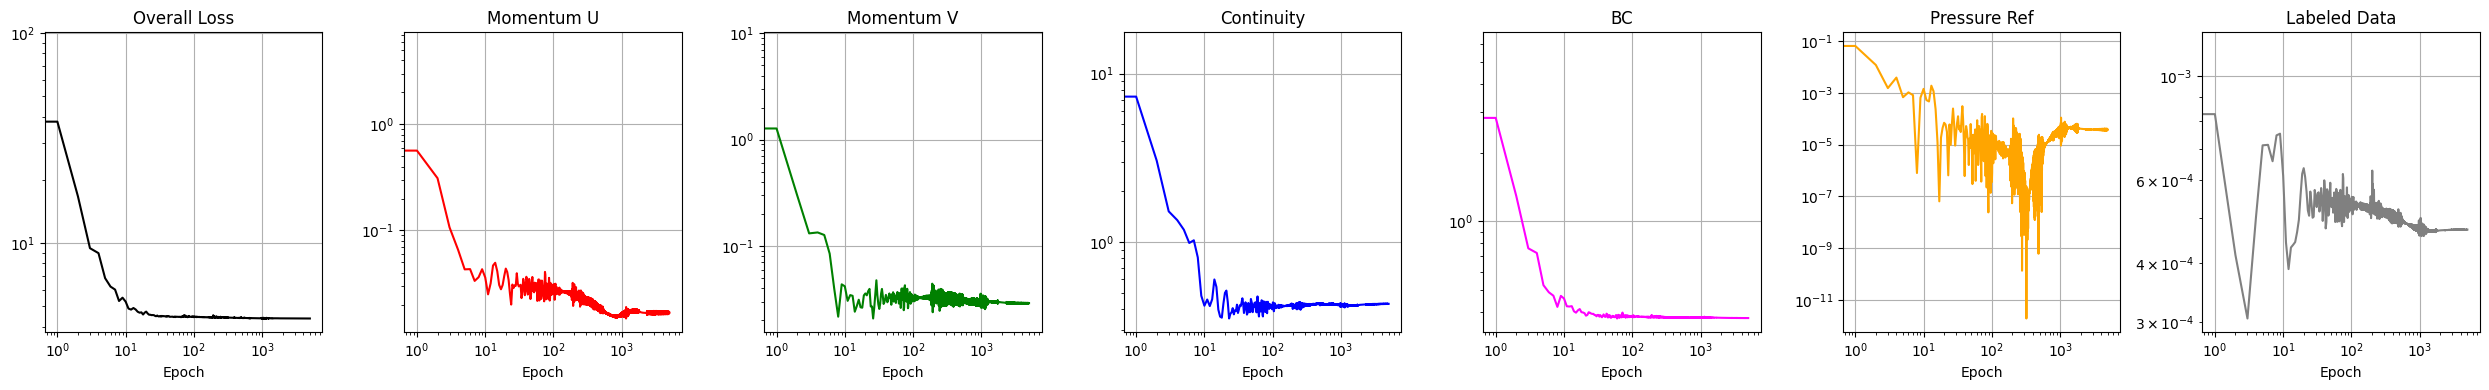

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 025_clean ===
Re estimado: 13.0031
Rango de presión: [-0.140281, 0.066828]


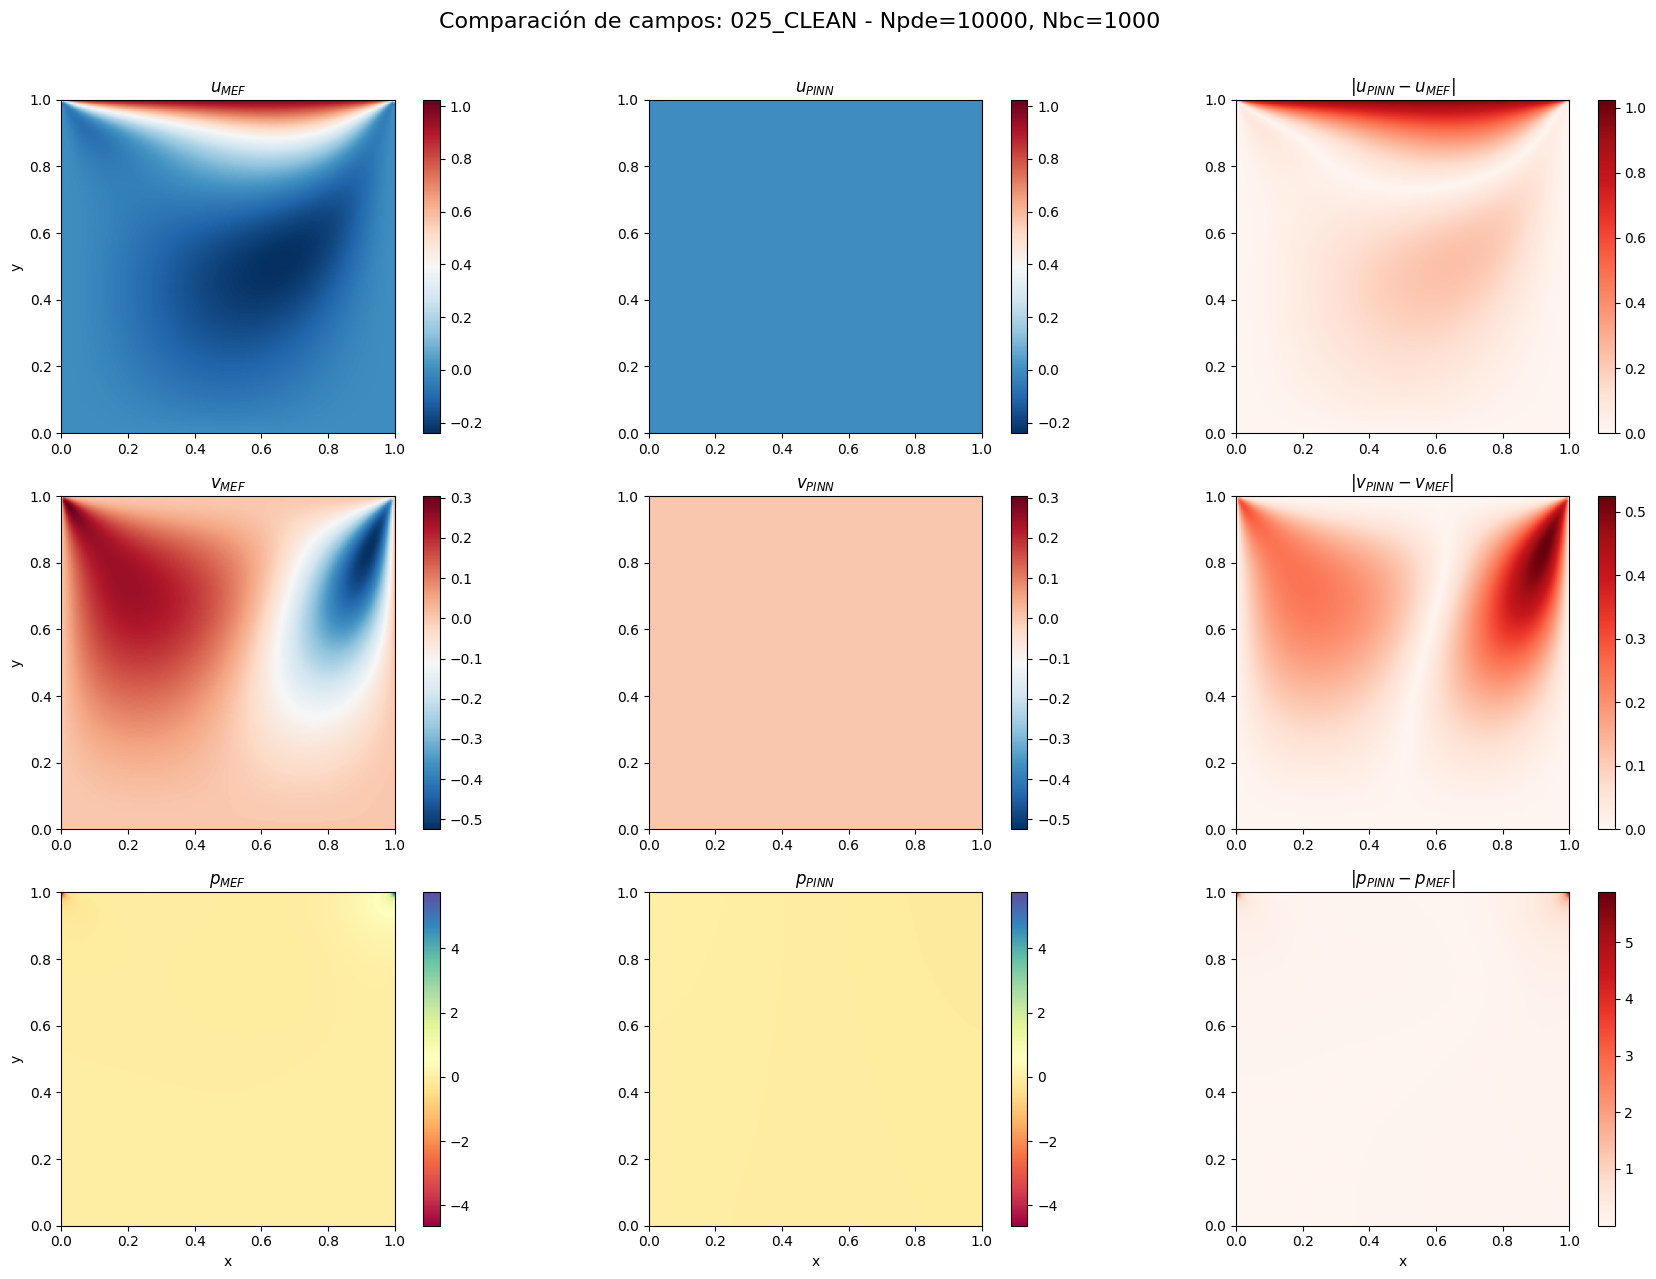

C:\Users\PC\AppData\Local\Temp\ipykernel_24908\238890141.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


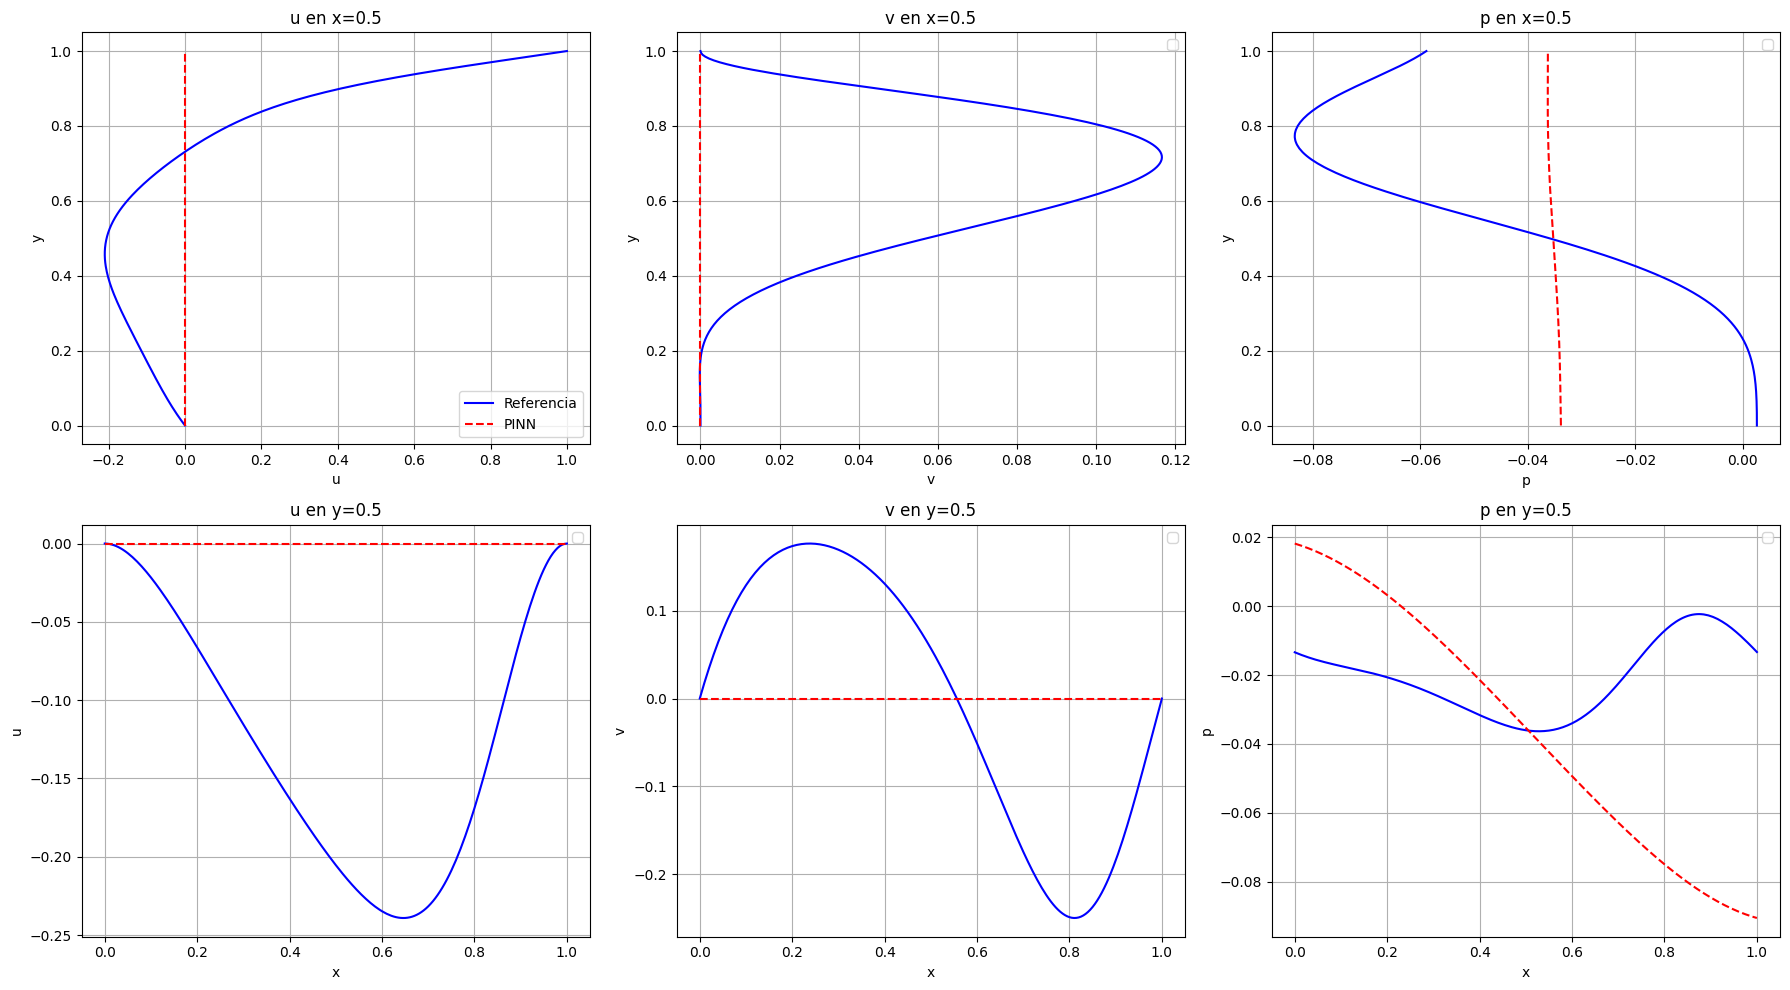


=== Entrenando modelo pressure-only: 025_noisy_1percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<29:40,  2.81it/s]

Epoch    0 | Total: 8.68e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2528 | u_top: -0.004 | Re: 50.09
  Pressure stats - min: -0.0794, max: 0.1891, mean: 0.0498


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:36<24:34,  3.05it/s]

Epoch  500 | Total: 4.39e+00 | PDE: 4.67e-01 | BC: 3.78e-01 | P_ref: 2.78e-06 | p(0,0): -0.0066 | u_top: 0.569 | Re: 22.76


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [05:11<19:44,  3.38it/s]

Epoch 1000 | Total: 4.38e+00 | PDE: 4.67e-01 | BC: 3.77e-01 | P_ref: 3.54e-05 | p(0,0): -0.0061 | u_top: 0.563 | Re: 14.05


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:39<17:17,  3.37it/s]

Epoch 1500 | Total: 4.38e+00 | PDE: 4.66e-01 | BC: 3.77e-01 | P_ref: 3.90e-05 | p(0,0): -0.0063 | u_top: 0.572 | Re: 12.58


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [10:11<15:12,  3.29it/s]

Epoch 2000 | Total: 4.38e+00 | PDE: 4.69e-01 | BC: 3.77e-01 | P_ref: 6.45e-05 | p(0,0): -0.0061 | u_top: 0.573 | Re: 12.47
  Pressure stats - min: -0.1325, max: 0.0613, mean: -0.0312


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:40<12:25,  3.35it/s]

Epoch 2500 | Total: 4.37e+00 | PDE: 4.72e-01 | BC: 3.76e-01 | P_ref: 3.97e-05 | p(0,0): -0.0063 | u_top: 0.568 | Re: 12.86


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [15:09<10:19,  3.23it/s]

Epoch 3000 | Total: 4.37e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 3.94e-05 | p(0,0): -0.0063 | u_top: 0.569 | Re: 12.89


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:38<07:21,  3.40it/s]

Epoch 3500 | Total: 4.37e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 3.79e-05 | p(0,0): -0.0064 | u_top: 0.568 | Re: 12.91


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [20:08<04:57,  3.36it/s]

Epoch 4000 | Total: 4.37e+00 | PDE: 4.74e-01 | BC: 3.75e-01 | P_ref: 3.93e-05 | p(0,0): -0.0062 | u_top: 0.569 | Re: 12.93
  Pressure stats - min: -0.1332, max: 0.0610, mean: -0.0315


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:36<02:23,  3.47it/s]

Epoch 4500 | Total: 4.37e+00 | PDE: 4.74e-01 | BC: 3.75e-01 | P_ref: 3.72e-05 | p(0,0): -0.0063 | u_top: 0.569 | Re: 12.95


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [25:05<00:00,  3.32it/s]

Epoch 4999 | Total: 4.37e+00 | PDE: 4.75e-01 | BC: 3.75e-01 | P_ref: 3.86e-05 | p(0,0): -0.0062 | u_top: 0.569 | Re: 12.98

Valor final estimado de Re: 12.9754

Tiempo total: 1505.3 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_025_noisy_1percent_Npde10000_Nbc1000_20250810_111333.pt


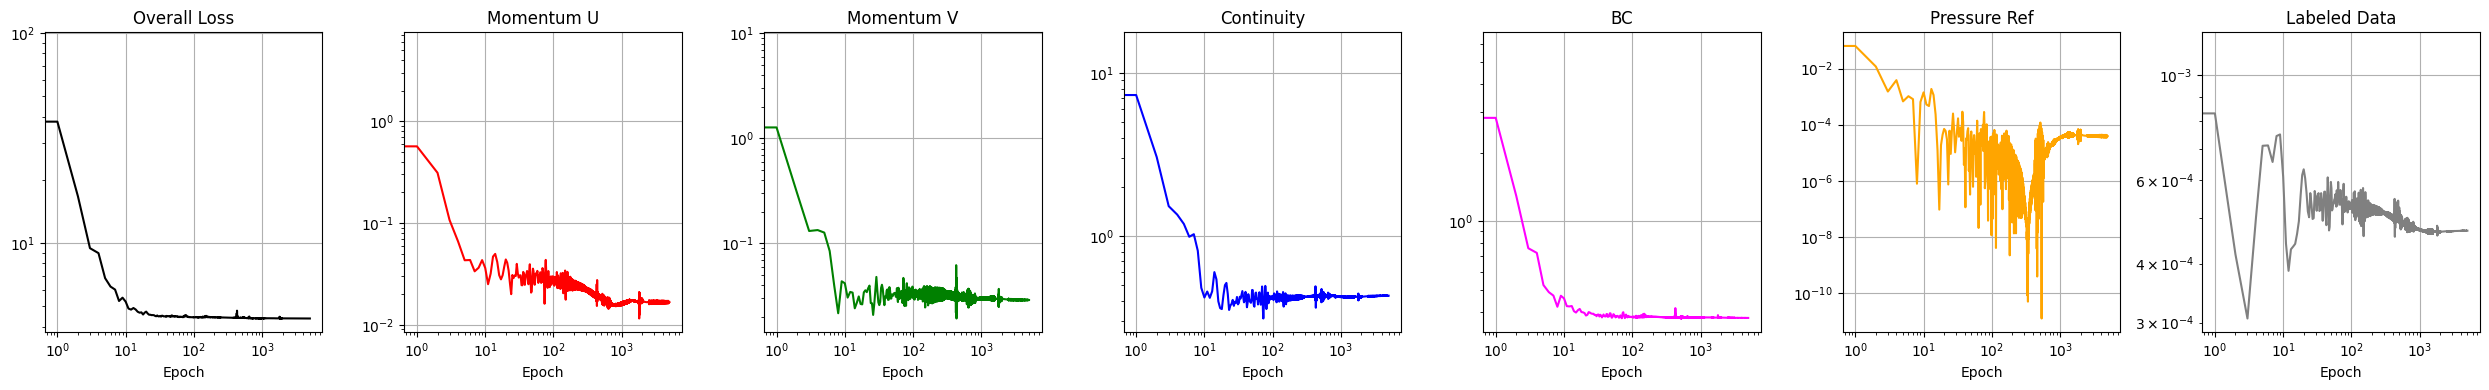

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 025_noisy_1percent ===
Re estimado: 12.9754
Rango de presión: [-0.140237, 0.066793]


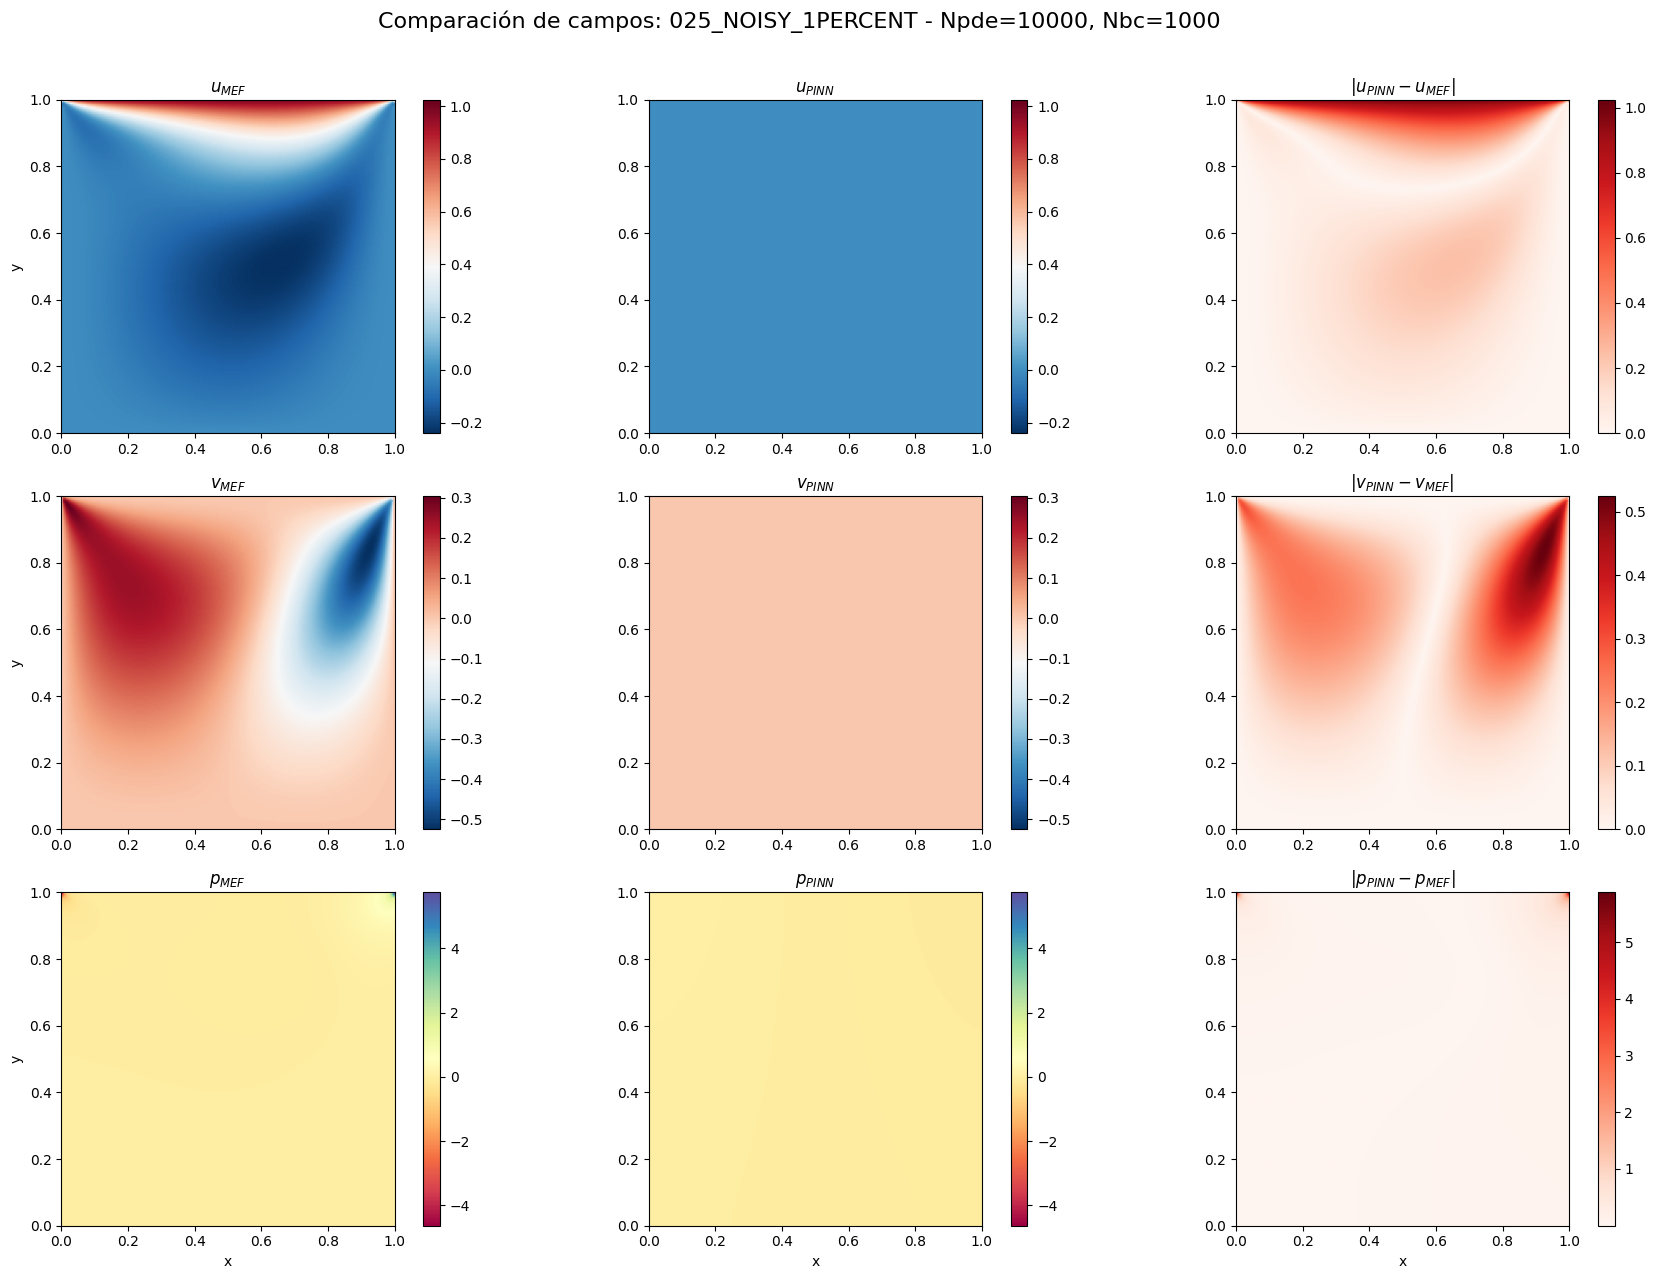

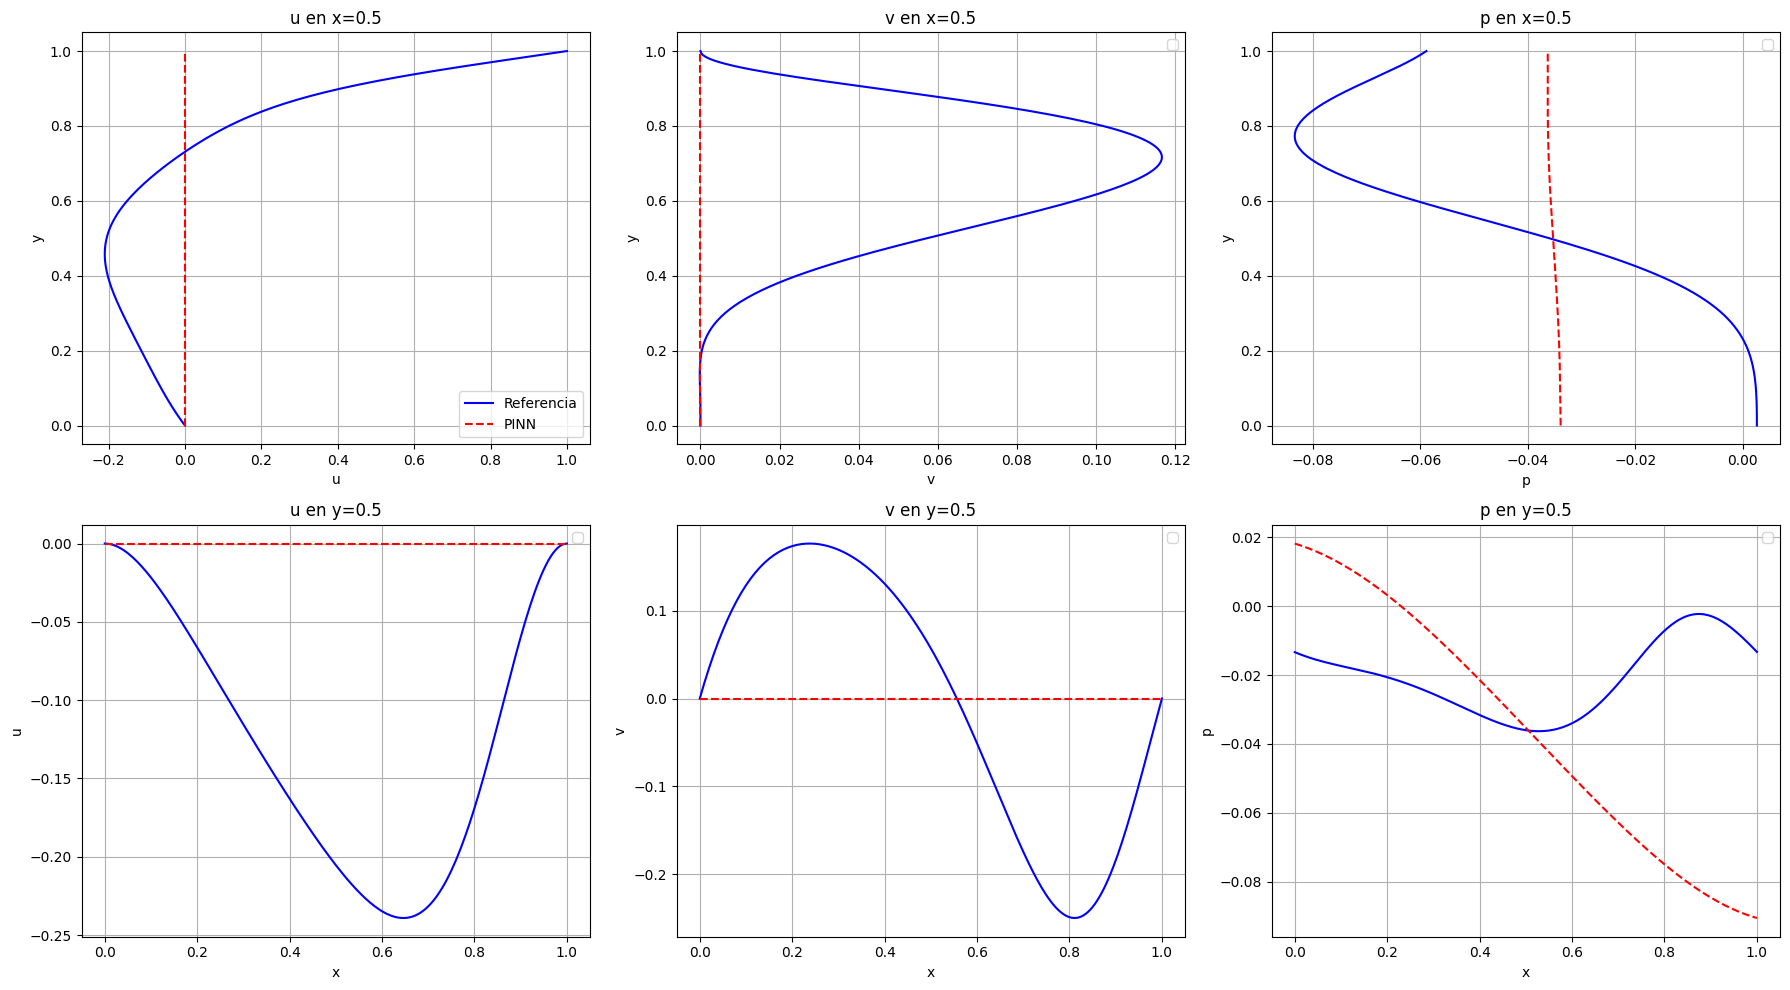


=== Entrenando modelo pressure-only: 025_noisy_2percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<27:11,  3.06it/s]

Epoch    0 | Total: 8.68e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2528 | u_top: -0.004 | Re: 50.09
  Pressure stats - min: -0.0794, max: 0.1891, mean: 0.0498


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:26<22:01,  3.40it/s]

Epoch  500 | Total: 4.39e+00 | PDE: 4.83e-01 | BC: 3.76e-01 | P_ref: 7.22e-06 | p(0,0): -0.0023 | u_top: 0.573 | Re: 22.58


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:53<19:37,  3.40it/s]

Epoch 1000 | Total: 4.38e+00 | PDE: 4.68e-01 | BC: 3.77e-01 | P_ref: 3.39e-05 | p(0,0): -0.0058 | u_top: 0.573 | Re: 13.89


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:20<17:09,  3.40it/s]

Epoch 1500 | Total: 4.38e+00 | PDE: 4.68e-01 | BC: 3.77e-01 | P_ref: 4.04e-05 | p(0,0): -0.0065 | u_top: 0.573 | Re: 12.55


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:47<15:24,  3.24it/s]

Epoch 2000 | Total: 4.38e+00 | PDE: 4.71e-01 | BC: 3.76e-01 | P_ref: 4.46e-05 | p(0,0): -0.0067 | u_top: 0.568 | Re: 12.92
  Pressure stats - min: -0.1335, max: 0.0605, mean: -0.0319


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:39<12:34,  3.31it/s]

Epoch 2500 | Total: 4.38e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 4.44e-05 | p(0,0): -0.0065 | u_top: 0.569 | Re: 12.92


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [15:22<09:38,  3.45it/s]

Epoch 3000 | Total: 4.37e+00 | PDE: 4.74e-01 | BC: 3.76e-01 | P_ref: 4.35e-05 | p(0,0): -0.0066 | u_top: 0.569 | Re: 12.93


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:50<07:19,  3.41it/s]

Epoch 3500 | Total: 4.37e+00 | PDE: 4.74e-01 | BC: 3.76e-01 | P_ref: 4.30e-05 | p(0,0): -0.0066 | u_top: 0.569 | Re: 12.94


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [20:19<04:47,  3.48it/s]

Epoch 4000 | Total: 4.37e+00 | PDE: 4.75e-01 | BC: 3.75e-01 | P_ref: 4.26e-05 | p(0,0): -0.0066 | u_top: 0.569 | Re: 12.96
  Pressure stats - min: -0.1337, max: 0.0606, mean: -0.0319


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:46<02:27,  3.39it/s]

Epoch 4500 | Total: 4.37e+00 | PDE: 4.75e-01 | BC: 3.75e-01 | P_ref: 4.20e-05 | p(0,0): -0.0066 | u_top: 0.569 | Re: 12.98


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [25:13<00:00,  3.30it/s]

Epoch 4999 | Total: 4.37e+00 | PDE: 4.76e-01 | BC: 3.75e-01 | P_ref: 4.23e-05 | p(0,0): -0.0065 | u_top: 0.569 | Re: 13.00

Valor final estimado de Re: 12.9983

Tiempo total: 1513.8 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_025_noisy_2percent_Npde10000_Nbc1000_20250810_113856.pt


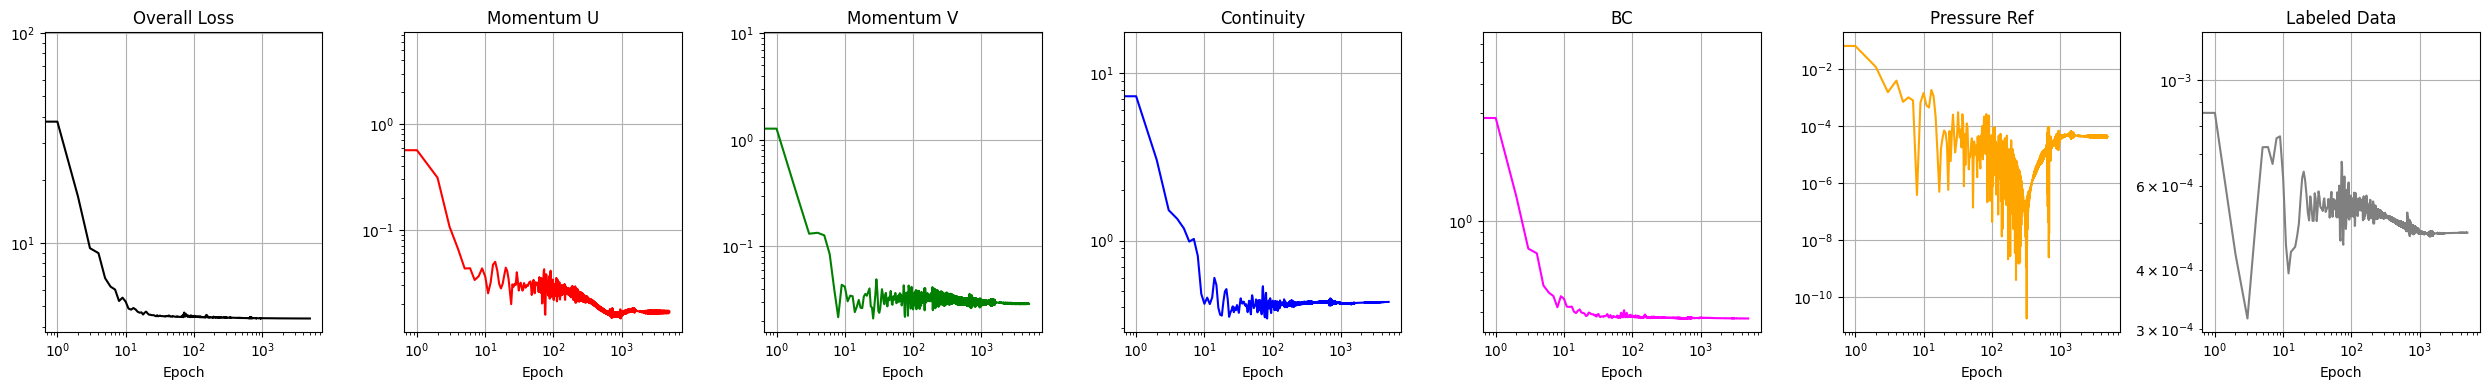

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 025_noisy_2percent ===
Re estimado: 12.9983
Rango de presión: [-0.140670, 0.066459]


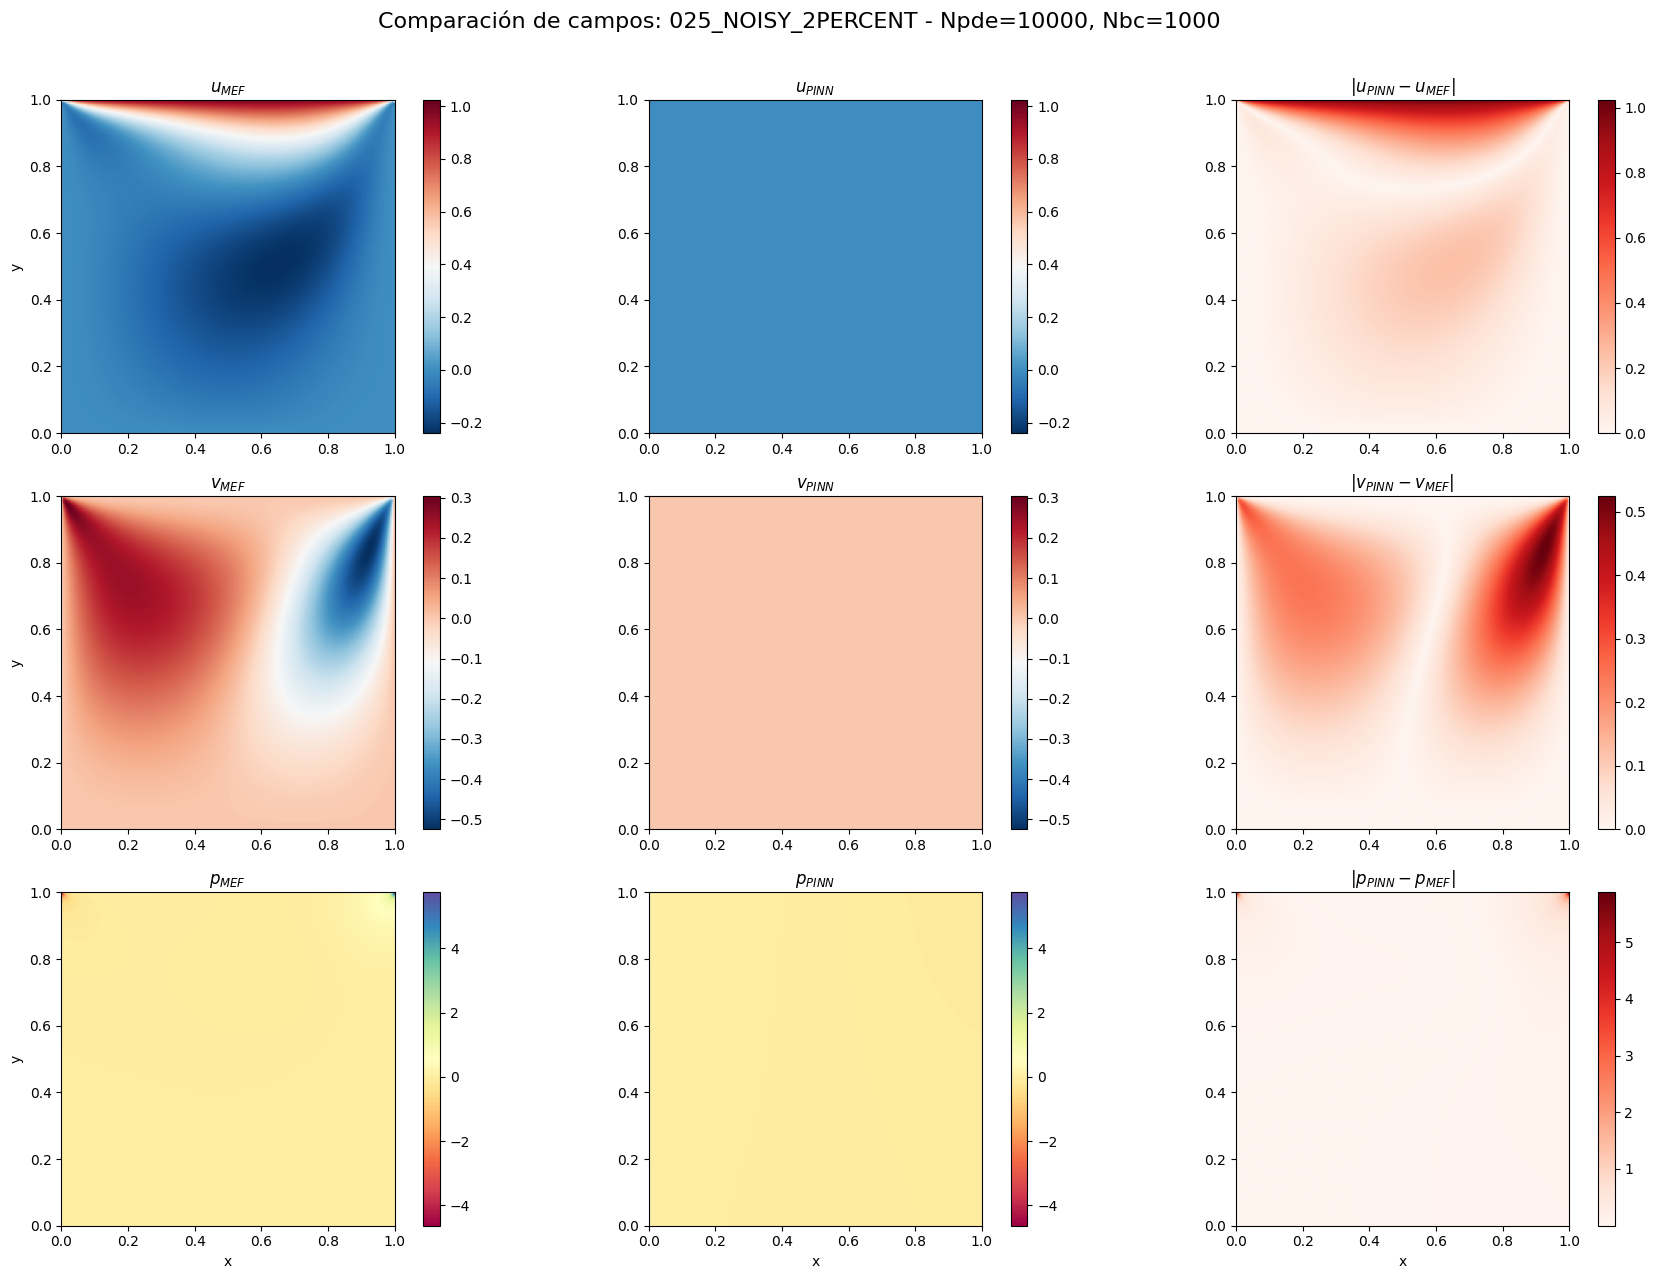

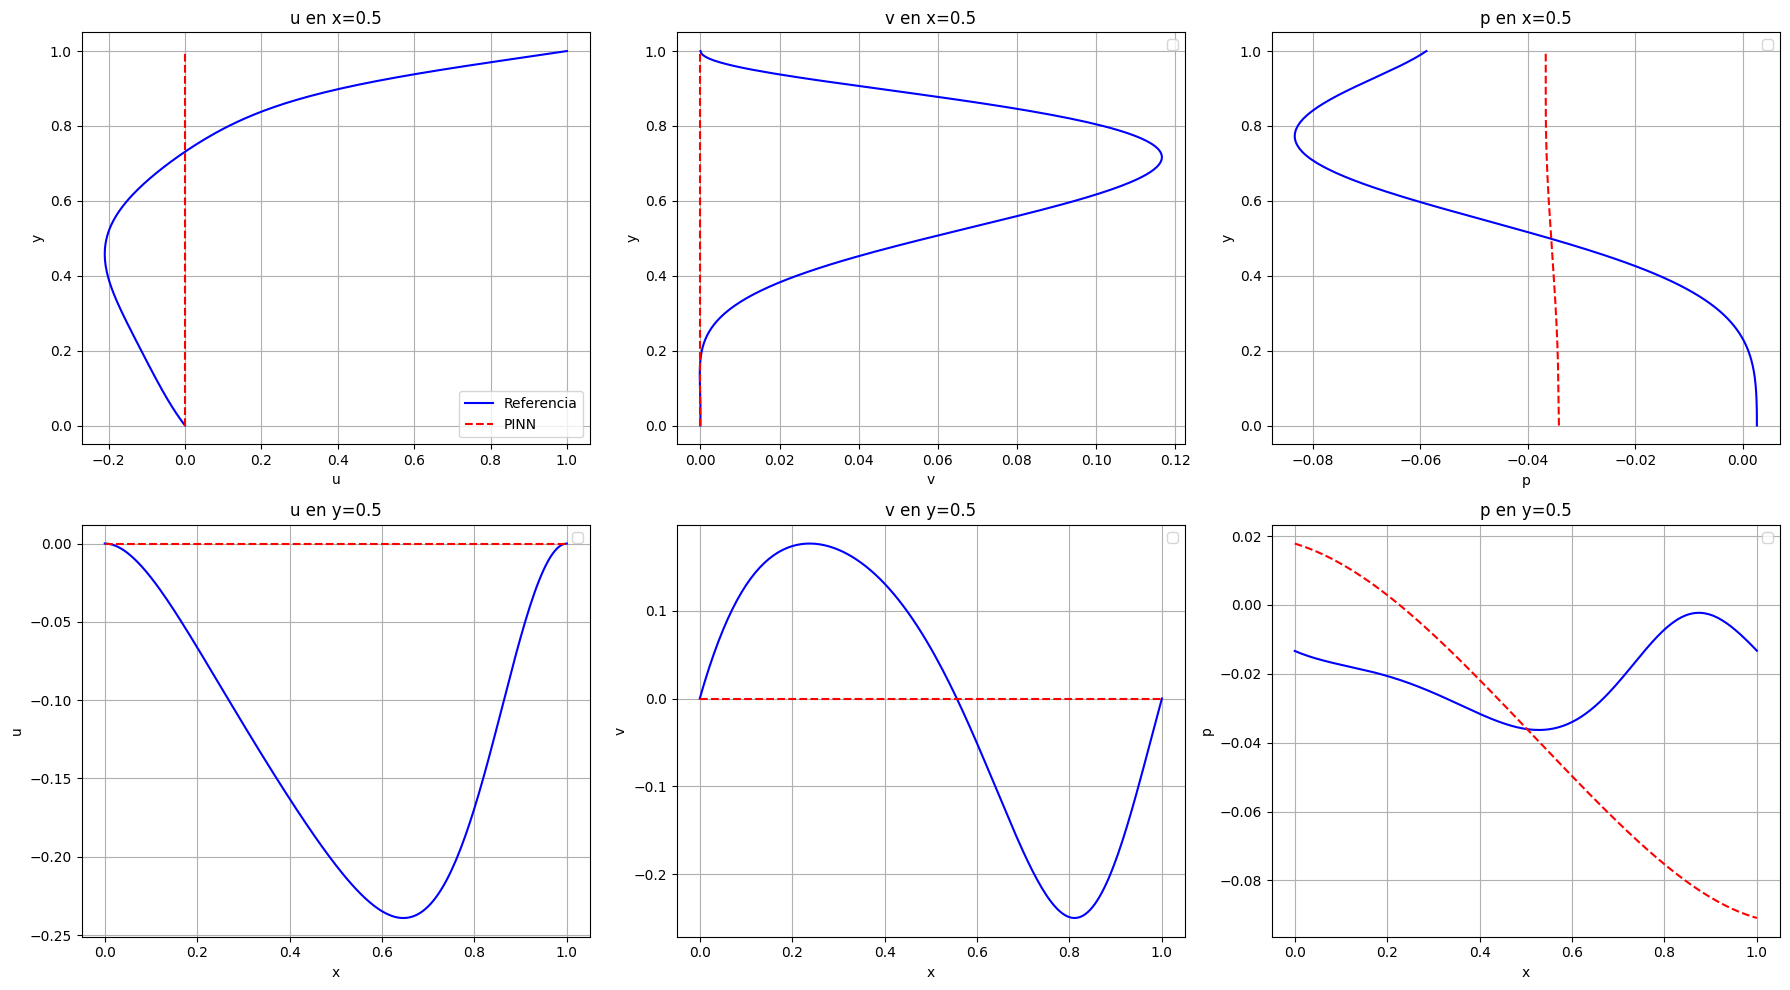


=== Entrenando modelo pressure-only: 025_noisy_5percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<27:59,  2.98it/s]

Epoch    0 | Total: 8.68e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2528 | u_top: -0.004 | Re: 50.09
  Pressure stats - min: -0.0794, max: 0.1891, mean: 0.0498


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:29<21:54,  3.42it/s]

Epoch  500 | Total: 4.42e+00 | PDE: 4.87e-01 | BC: 3.77e-01 | P_ref: 3.54e-06 | p(0,0): -0.0028 | u_top: 0.560 | Re: 22.59


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:58<19:26,  3.43it/s]

Epoch 1000 | Total: 4.39e+00 | PDE: 4.60e-01 | BC: 3.78e-01 | P_ref: 5.08e-05 | p(0,0): -0.0054 | u_top: 0.576 | Re: 13.94


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:24<18:13,  3.20it/s]

Epoch 1500 | Total: 4.39e+00 | PDE: 4.66e-01 | BC: 3.77e-01 | P_ref: 5.72e-05 | p(0,0): -0.0068 | u_top: 0.565 | Re: 12.32


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:53<15:25,  3.24it/s]

Epoch 2000 | Total: 4.38e+00 | PDE: 4.69e-01 | BC: 3.76e-01 | P_ref: 4.72e-05 | p(0,0): -0.0069 | u_top: 0.568 | Re: 12.67
  Pressure stats - min: -0.1329, max: 0.0601, mean: -0.0319


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:22<12:15,  3.40it/s]

Epoch 2500 | Total: 4.38e+00 | PDE: 4.71e-01 | BC: 3.76e-01 | P_ref: 4.46e-05 | p(0,0): -0.0067 | u_top: 0.569 | Re: 12.79


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:49<09:56,  3.35it/s]

Epoch 3000 | Total: 4.38e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 4.43e-05 | p(0,0): -0.0067 | u_top: 0.569 | Re: 12.82


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:16<07:30,  3.33it/s]

Epoch 3500 | Total: 4.38e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 4.42e-05 | p(0,0): -0.0067 | u_top: 0.569 | Re: 12.83


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:43<04:56,  3.37it/s]

Epoch 4000 | Total: 4.38e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 4.09e-05 | p(0,0): -0.0069 | u_top: 0.568 | Re: 12.84
  Pressure stats - min: -0.1339, max: 0.0597, mean: -0.0322


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:09<02:24,  3.46it/s]

Epoch 4500 | Total: 4.38e+00 | PDE: 4.73e-01 | BC: 3.76e-01 | P_ref: 4.02e-05 | p(0,0): -0.0069 | u_top: 0.569 | Re: 12.86


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:35<00:00,  3.39it/s]

Epoch 4999 | Total: 4.38e+00 | PDE: 4.74e-01 | BC: 3.75e-01 | P_ref: 4.37e-05 | p(0,0): -0.0066 | u_top: 0.569 | Re: 12.88

Valor final estimado de Re: 12.8754

Tiempo total: 1475.4 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_025_noisy_5percent_Npde10000_Nbc1000_20250810_120341.pt


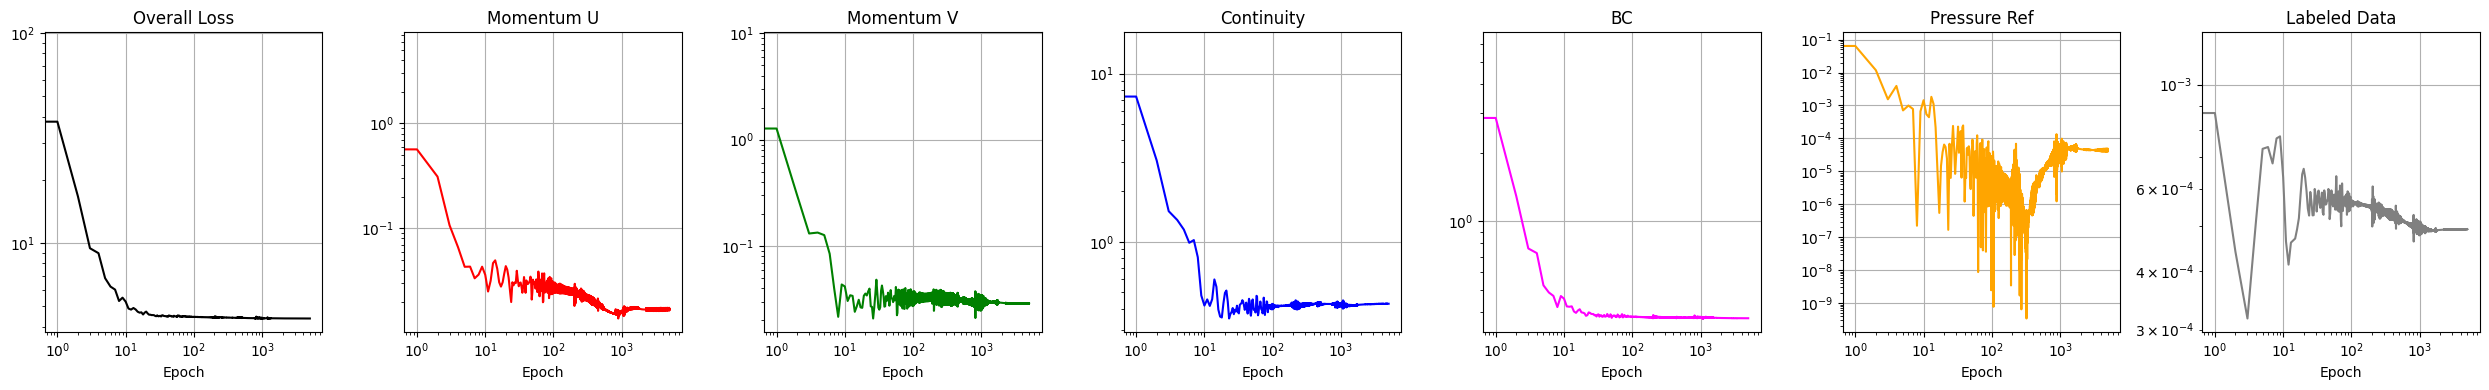

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 025_noisy_5percent ===
Re estimado: 12.8754
Rango de presión: [-0.140300, 0.066212]


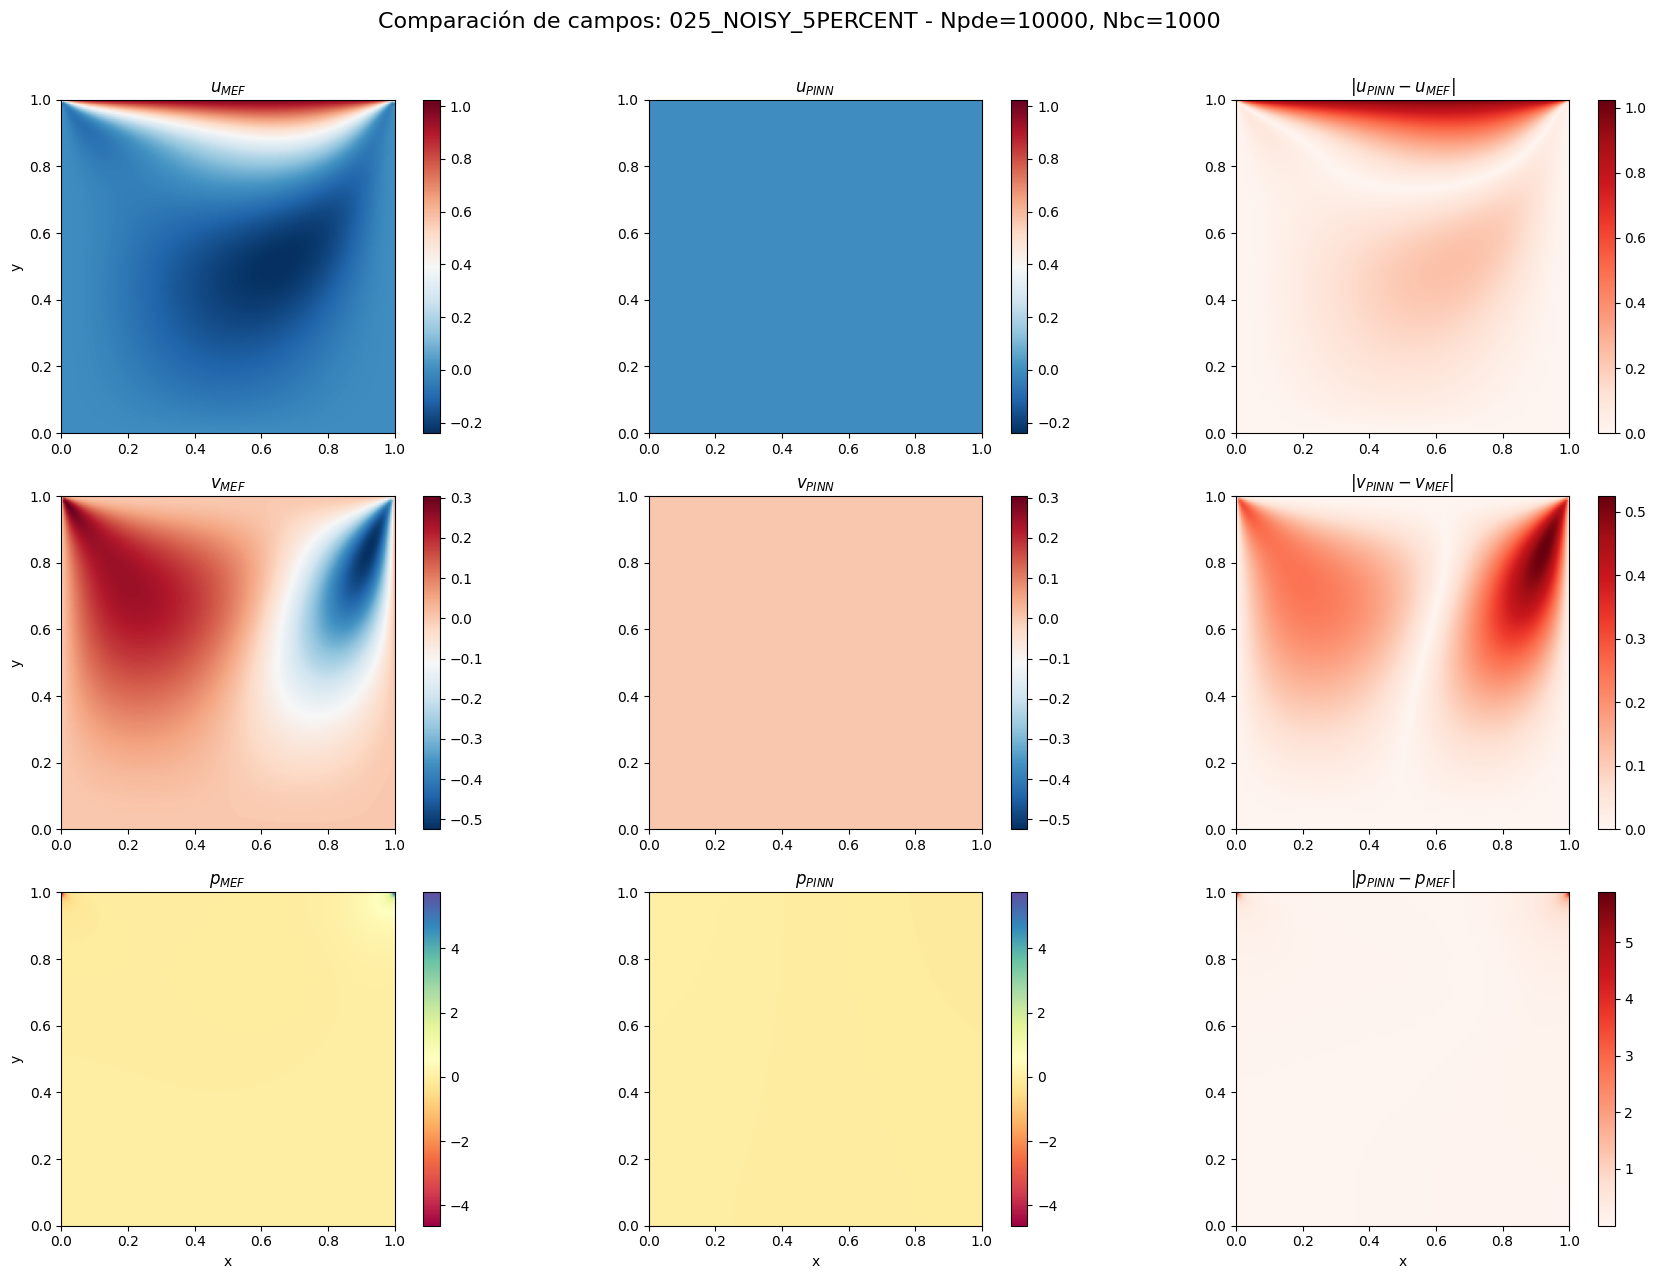

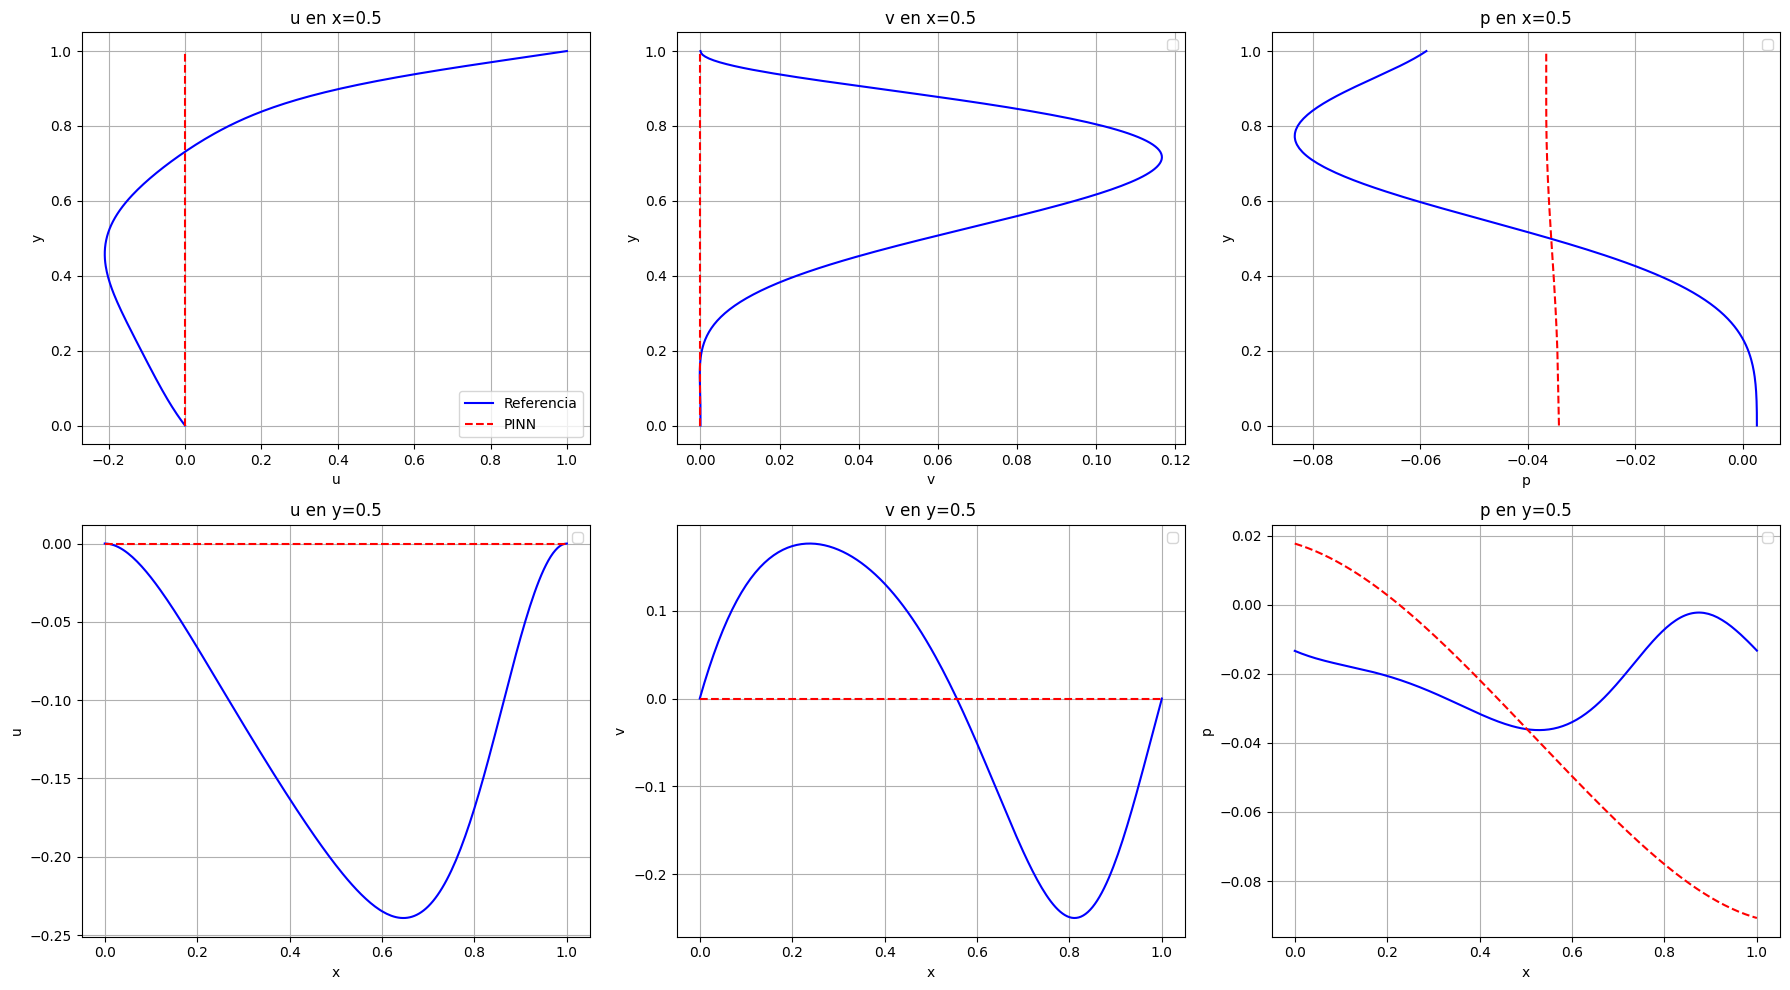


=== Entrenando modelo pressure-only: 050_clean ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<37:33,  2.22it/s]

Epoch    0 | Total: 8.73e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2490 | u_top: -0.014 | Re: 50.09
  Pressure stats - min: -0.0787, max: 0.1865, mean: 0.0491


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:30<22:08,  3.39it/s]

Epoch  500 | Total: 4.66e+00 | PDE: 4.20e-01 | BC: 3.87e-01 | P_ref: 2.37e-07 | p(0,0): 0.0001 | u_top: 0.565 | Re: 20.57


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:57<19:32,  3.41it/s]

Epoch 1000 | Total: 4.63e+00 | PDE: 4.20e-01 | BC: 3.86e-01 | P_ref: 1.38e-05 | p(0,0): -0.0037 | u_top: 0.559 | Re: 11.31


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:25<16:58,  3.43it/s]

Epoch 1500 | Total: 4.62e+00 | PDE: 4.17e-01 | BC: 3.85e-01 | P_ref: 2.48e-05 | p(0,0): -0.0049 | u_top: 0.555 | Re: 9.40


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:52<14:40,  3.40it/s]

Epoch 2000 | Total: 4.62e+00 | PDE: 4.18e-01 | BC: 3.85e-01 | P_ref: 2.47e-05 | p(0,0): -0.0050 | u_top: 0.557 | Re: 9.30
  Pressure stats - min: -0.1204, max: 0.0535, mean: -0.0279


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:18<12:03,  3.46it/s]

Epoch 2500 | Total: 4.61e+00 | PDE: 4.20e-01 | BC: 3.85e-01 | P_ref: 2.35e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.33


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:44<09:41,  3.44it/s]

Epoch 3000 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.26e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.36


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:10<07:49,  3.19it/s]

Epoch 3500 | Total: 4.61e+00 | PDE: 4.21e-01 | BC: 3.84e-01 | P_ref: 2.35e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.37


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:36<04:52,  3.41it/s]

Epoch 4000 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.26e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.38
  Pressure stats - min: -0.1209, max: 0.0536, mean: -0.0280


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:02<02:26,  3.40it/s]

Epoch 4500 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.32e-05 | p(0,0): -0.0048 | u_top: 0.558 | Re: 9.39


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:28<00:00,  3.40it/s]

Epoch 4999 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.34e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.39

Valor final estimado de Re: 9.3928

Tiempo total: 1468.7 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_050_clean_Npde10000_Nbc1000_20250810_122819.pt


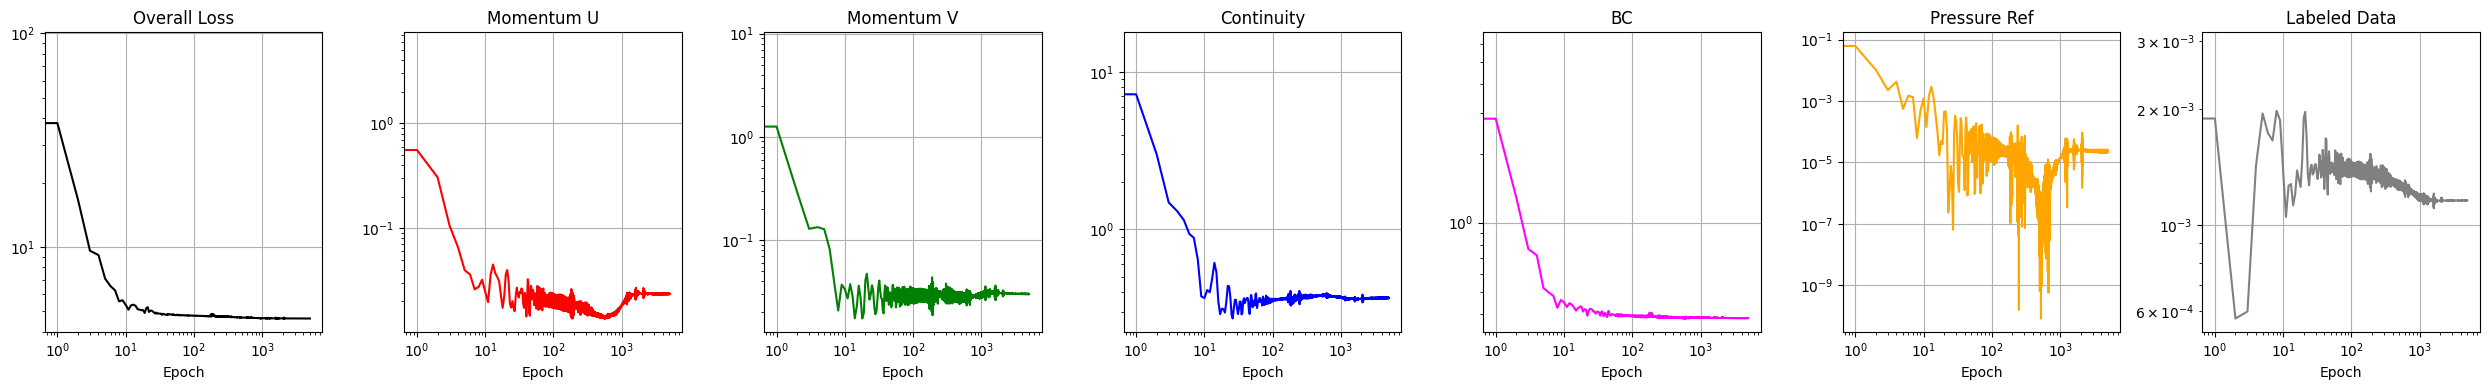

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 050_clean ===
Re estimado: 9.3928
Rango de presión: [-0.127053, 0.059177]


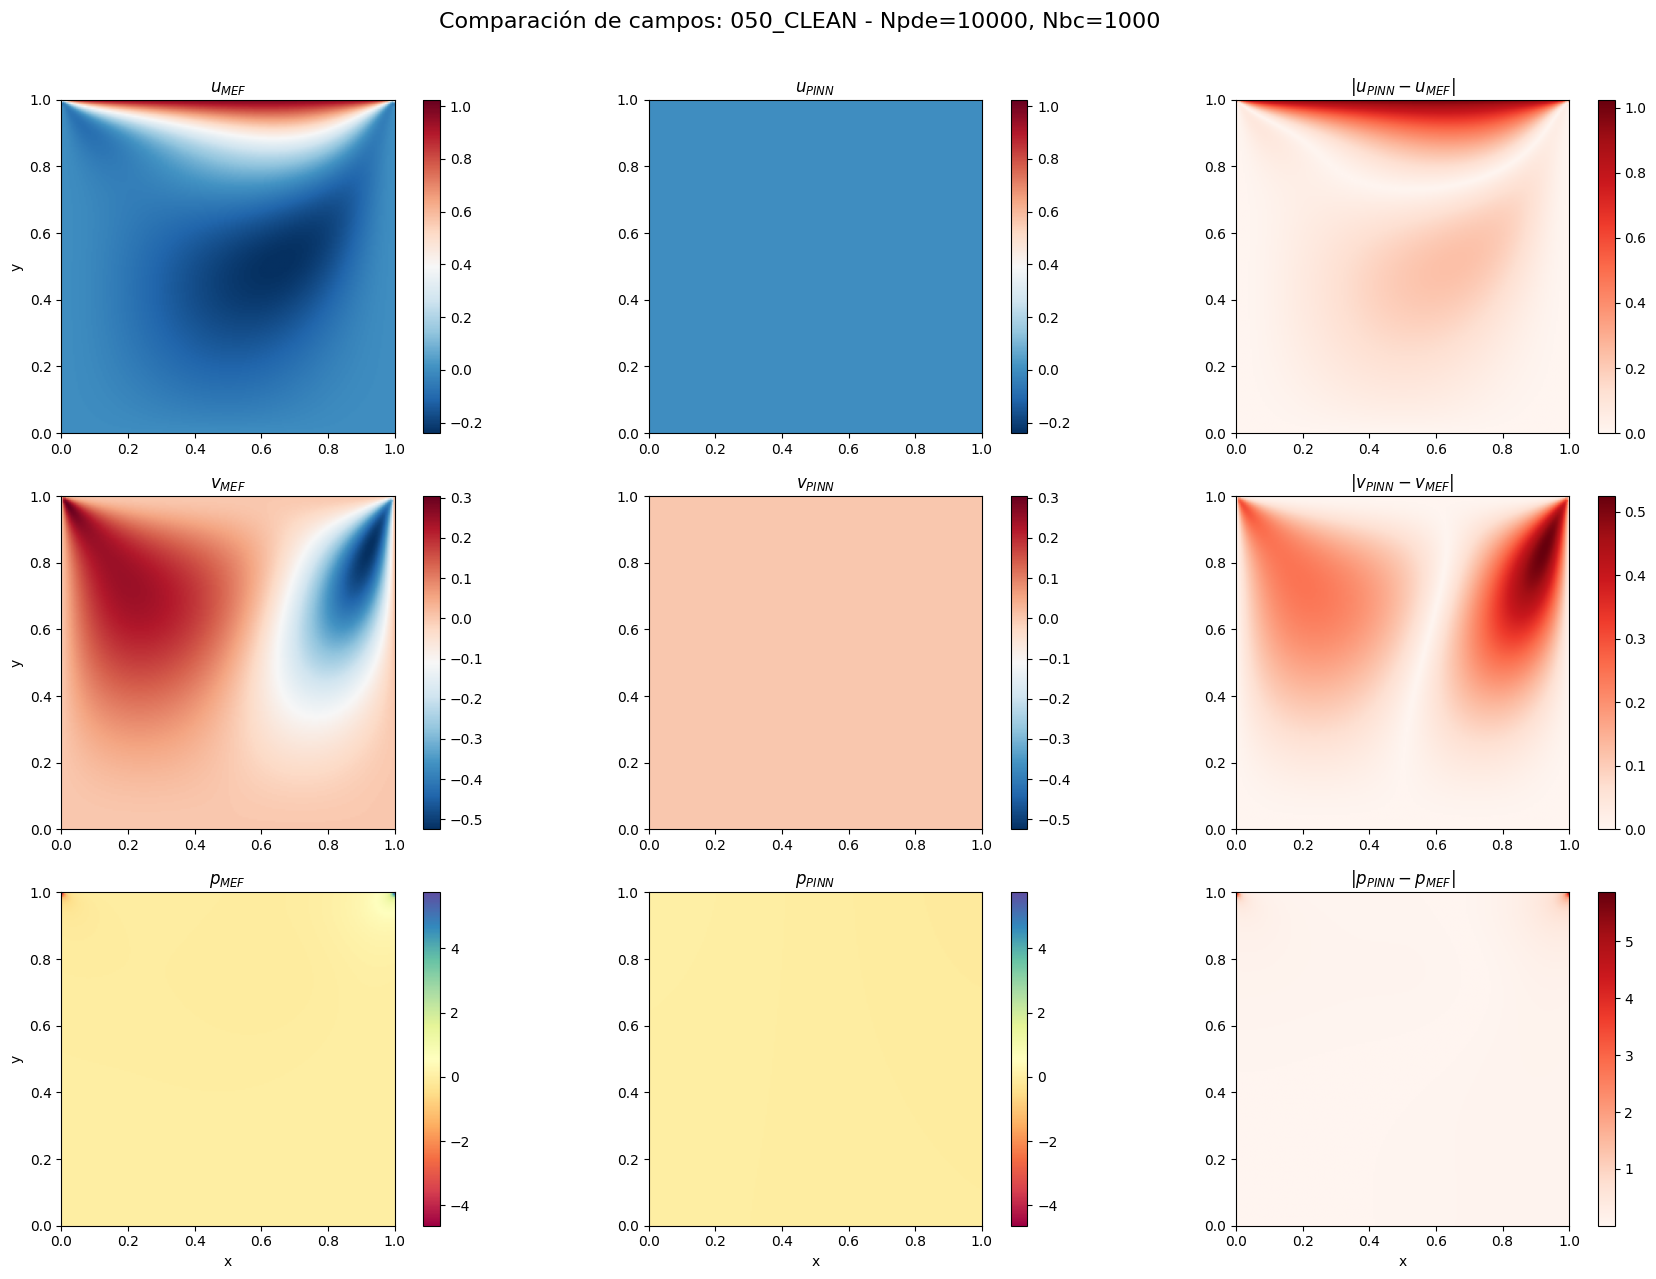

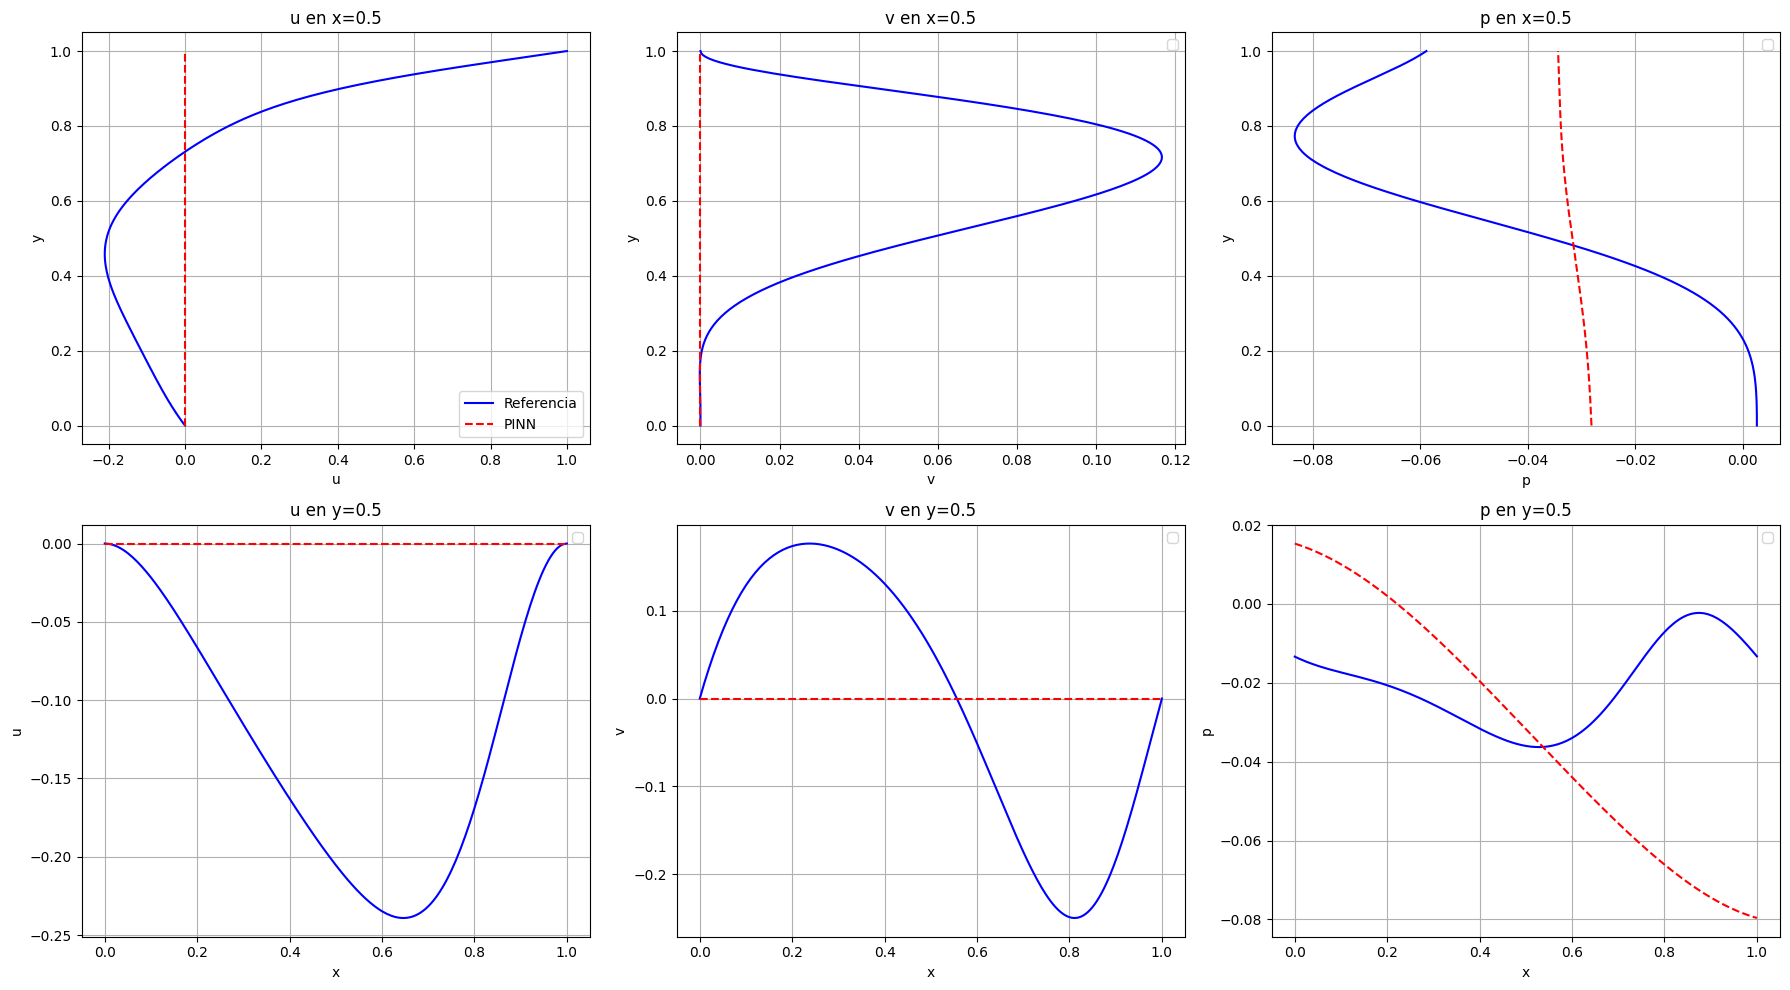


=== Entrenando modelo pressure-only: 050_noisy_1percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<40:50,  2.04it/s]

Epoch    0 | Total: 8.73e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2490 | u_top: -0.014 | Re: 50.09
  Pressure stats - min: -0.0787, max: 0.1865, mean: 0.0491


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:27<22:17,  3.36it/s]

Epoch  500 | Total: 4.66e+00 | PDE: 4.20e-01 | BC: 3.86e-01 | P_ref: 3.51e-07 | p(0,0): 0.0012 | u_top: 0.551 | Re: 20.37


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:54<19:27,  3.43it/s]

Epoch 1000 | Total: 4.62e+00 | PDE: 4.21e-01 | BC: 3.85e-01 | P_ref: 1.68e-05 | p(0,0): -0.0030 | u_top: 0.542 | Re: 11.39


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:21<17:05,  3.41it/s]

Epoch 1500 | Total: 4.62e+00 | PDE: 4.16e-01 | BC: 3.86e-01 | P_ref: 2.11e-05 | p(0,0): -0.0045 | u_top: 0.556 | Re: 9.42


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:49<14:41,  3.40it/s]

Epoch 2000 | Total: 4.61e+00 | PDE: 4.18e-01 | BC: 3.85e-01 | P_ref: 2.61e-05 | p(0,0): -0.0049 | u_top: 0.556 | Re: 9.37
  Pressure stats - min: -0.1202, max: 0.0538, mean: -0.0279


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:16<12:21,  3.37it/s]

Epoch 2500 | Total: 4.61e+00 | PDE: 4.20e-01 | BC: 3.85e-01 | P_ref: 2.48e-05 | p(0,0): -0.0049 | u_top: 0.557 | Re: 9.38


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:44<09:56,  3.35it/s]

Epoch 3000 | Total: 4.61e+00 | PDE: 4.21e-01 | BC: 3.84e-01 | P_ref: 2.39e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.40


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:10<07:09,  3.49it/s]

Epoch 3500 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.34e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.42


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:38<04:46,  3.49it/s]

Epoch 4000 | Total: 4.61e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 2.37e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.43
  Pressure stats - min: -0.1208, max: 0.0538, mean: -0.0280


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:03<02:25,  3.43it/s]

Epoch 4500 | Total: 4.61e+00 | PDE: 4.24e-01 | BC: 3.84e-01 | P_ref: 2.18e-05 | p(0,0): -0.0050 | u_top: 0.559 | Re: 9.44


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:29<00:00,  3.40it/s]

Epoch 4999 | Total: 4.61e+00 | PDE: 4.24e-01 | BC: 3.84e-01 | P_ref: 2.22e-05 | p(0,0): -0.0049 | u_top: 0.558 | Re: 9.45

Valor final estimado de Re: 9.4531

Tiempo total: 1469.6 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_050_noisy_1percent_Npde10000_Nbc1000_20250810_125257.pt


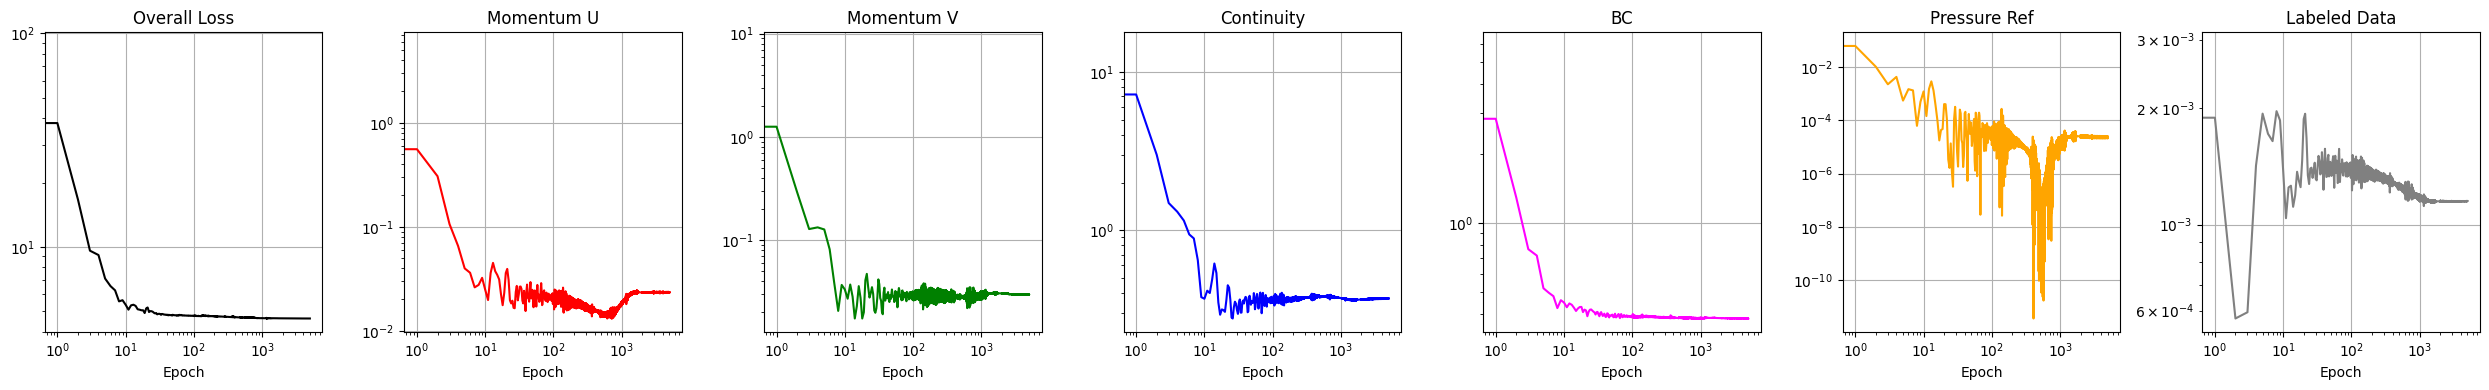

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 050_noisy_1percent ===
Re estimado: 9.4531
Rango de presión: [-0.127809, 0.059076]


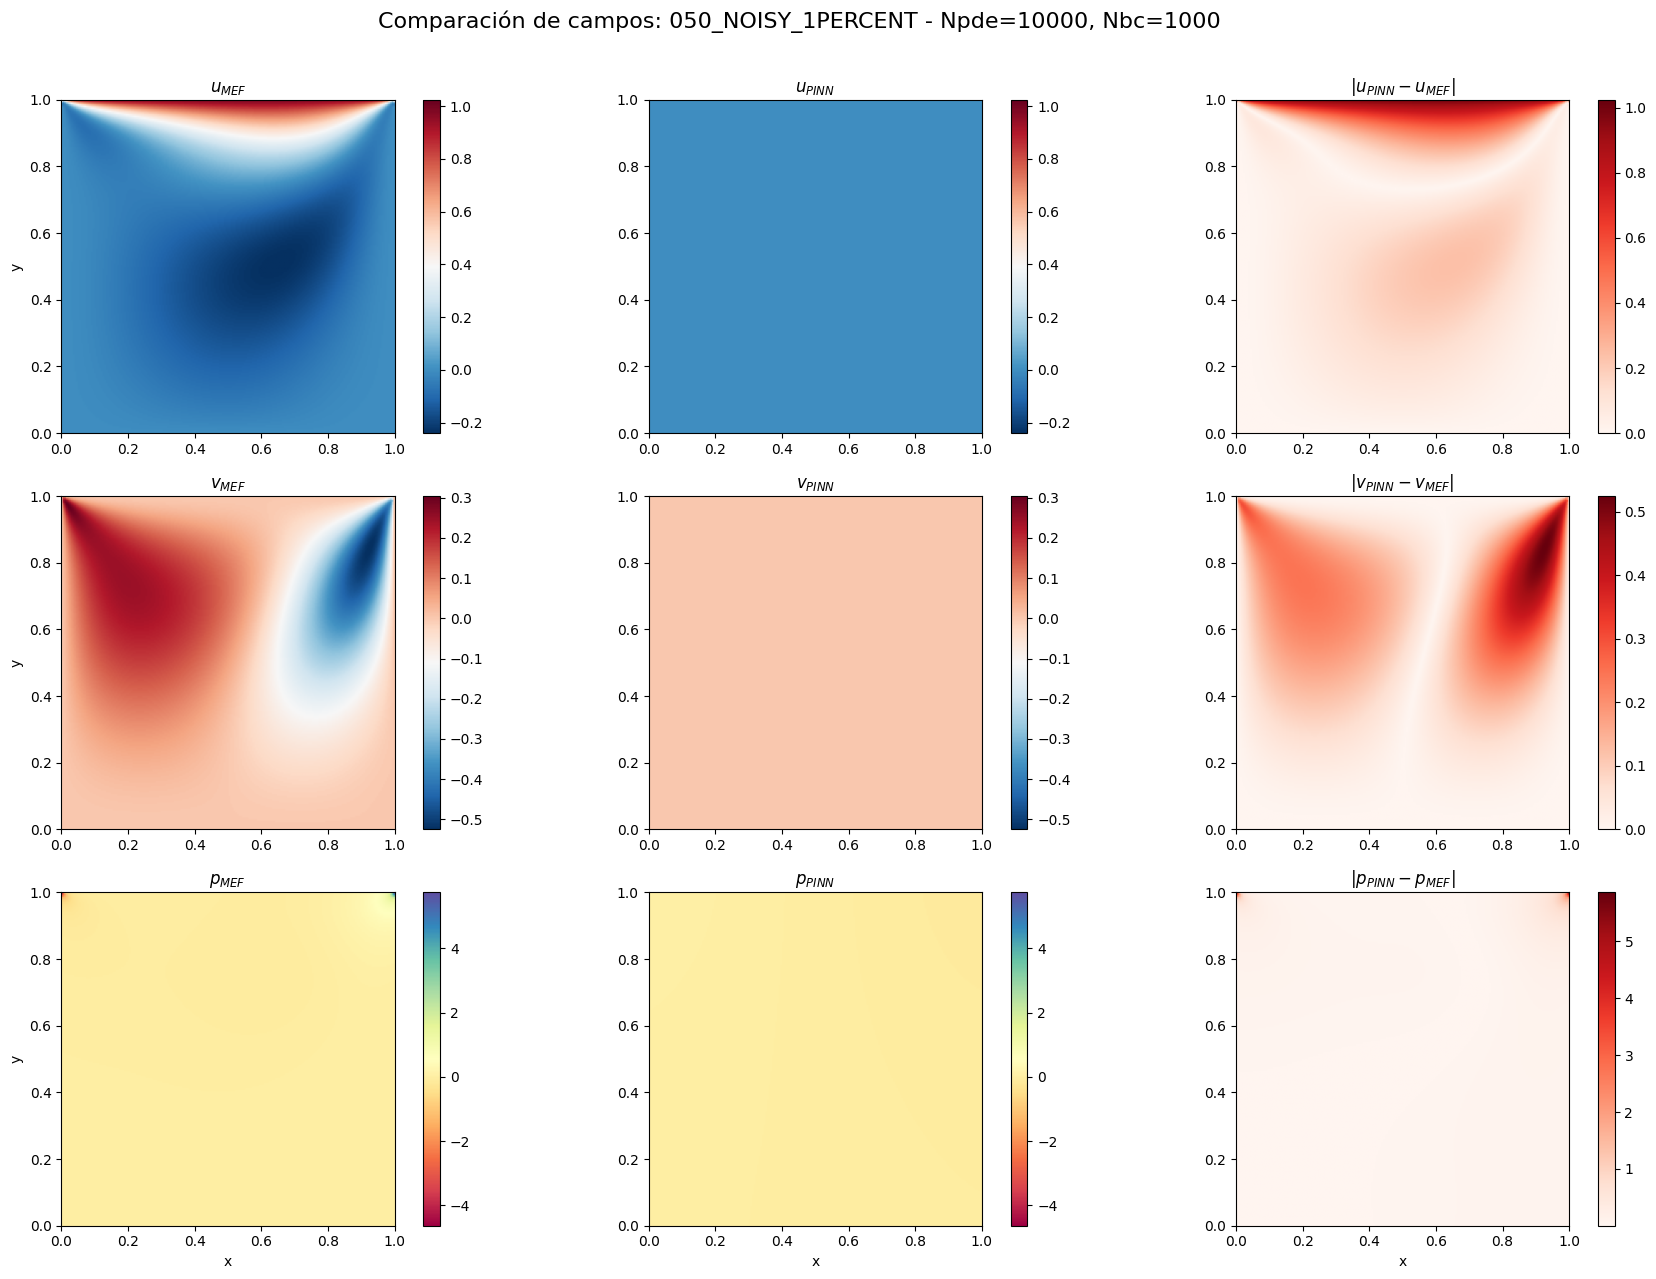

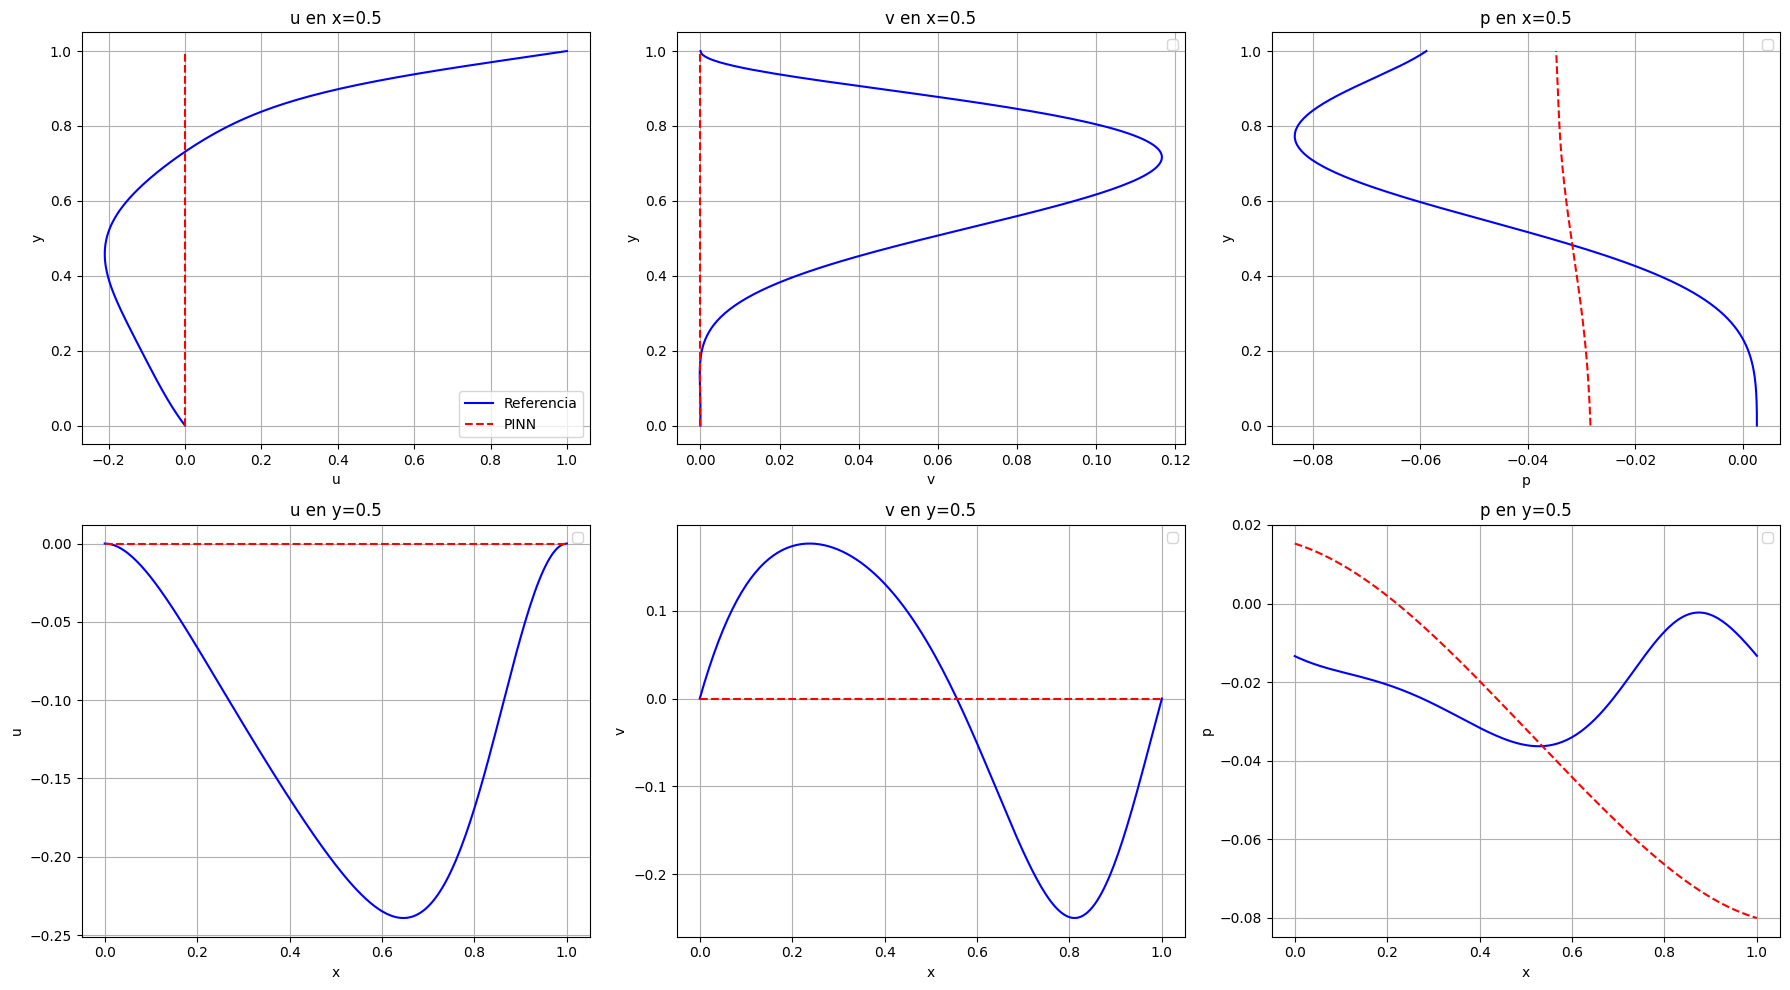


=== Entrenando modelo pressure-only: 050_noisy_2percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<31:16,  2.66it/s]

Epoch    0 | Total: 8.73e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2490 | u_top: -0.014 | Re: 50.09
  Pressure stats - min: -0.0787, max: 0.1865, mean: 0.0491


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:26<21:35,  3.47it/s]

Epoch  500 | Total: 4.67e+00 | PDE: 4.21e-01 | BC: 3.86e-01 | P_ref: 2.62e-06 | p(0,0): 0.0015 | u_top: 0.558 | Re: 20.55


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:51<19:13,  3.47it/s]

Epoch 1000 | Total: 4.64e+00 | PDE: 4.17e-01 | BC: 3.86e-01 | P_ref: 8.89e-06 | p(0,0): -0.0030 | u_top: 0.554 | Re: 11.27


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:17<17:25,  3.35it/s]

Epoch 1500 | Total: 4.63e+00 | PDE: 4.15e-01 | BC: 3.86e-01 | P_ref: 1.78e-05 | p(0,0): -0.0042 | u_top: 0.556 | Re: 9.41


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:42<14:52,  3.36it/s]

Epoch 2000 | Total: 4.63e+00 | PDE: 4.17e-01 | BC: 3.85e-01 | P_ref: 1.86e-05 | p(0,0): -0.0042 | u_top: 0.555 | Re: 9.29
  Pressure stats - min: -0.1193, max: 0.0542, mean: -0.0271


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:08<12:07,  3.43it/s]

Epoch 2500 | Total: 4.63e+00 | PDE: 4.19e-01 | BC: 3.85e-01 | P_ref: 1.76e-05 | p(0,0): -0.0041 | u_top: 0.556 | Re: 9.32


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:34<09:35,  3.48it/s]

Epoch 3000 | Total: 4.63e+00 | PDE: 4.20e-01 | BC: 3.85e-01 | P_ref: 1.70e-05 | p(0,0): -0.0041 | u_top: 0.558 | Re: 9.35


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:01<07:13,  3.46it/s]

Epoch 3500 | Total: 4.62e+00 | PDE: 4.21e-01 | BC: 3.85e-01 | P_ref: 1.69e-05 | p(0,0): -0.0041 | u_top: 0.557 | Re: 9.36


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:27<04:54,  3.39it/s]

Epoch 4000 | Total: 4.62e+00 | PDE: 4.21e-01 | BC: 3.84e-01 | P_ref: 1.70e-05 | p(0,0): -0.0041 | u_top: 0.557 | Re: 9.37
  Pressure stats - min: -0.1199, max: 0.0544, mean: -0.0271


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [21:54<02:25,  3.44it/s]

Epoch 4500 | Total: 4.62e+00 | PDE: 4.21e-01 | BC: 3.84e-01 | P_ref: 1.68e-05 | p(0,0): -0.0040 | u_top: 0.557 | Re: 9.38


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:21<00:00,  3.42it/s]

Epoch 4999 | Total: 4.62e+00 | PDE: 4.22e-01 | BC: 3.84e-01 | P_ref: 1.65e-05 | p(0,0): -0.0041 | u_top: 0.557 | Re: 9.38

Valor final estimado de Re: 9.3823

Tiempo total: 1461.2 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_050_noisy_2percent_Npde10000_Nbc1000_20250810_131726.pt


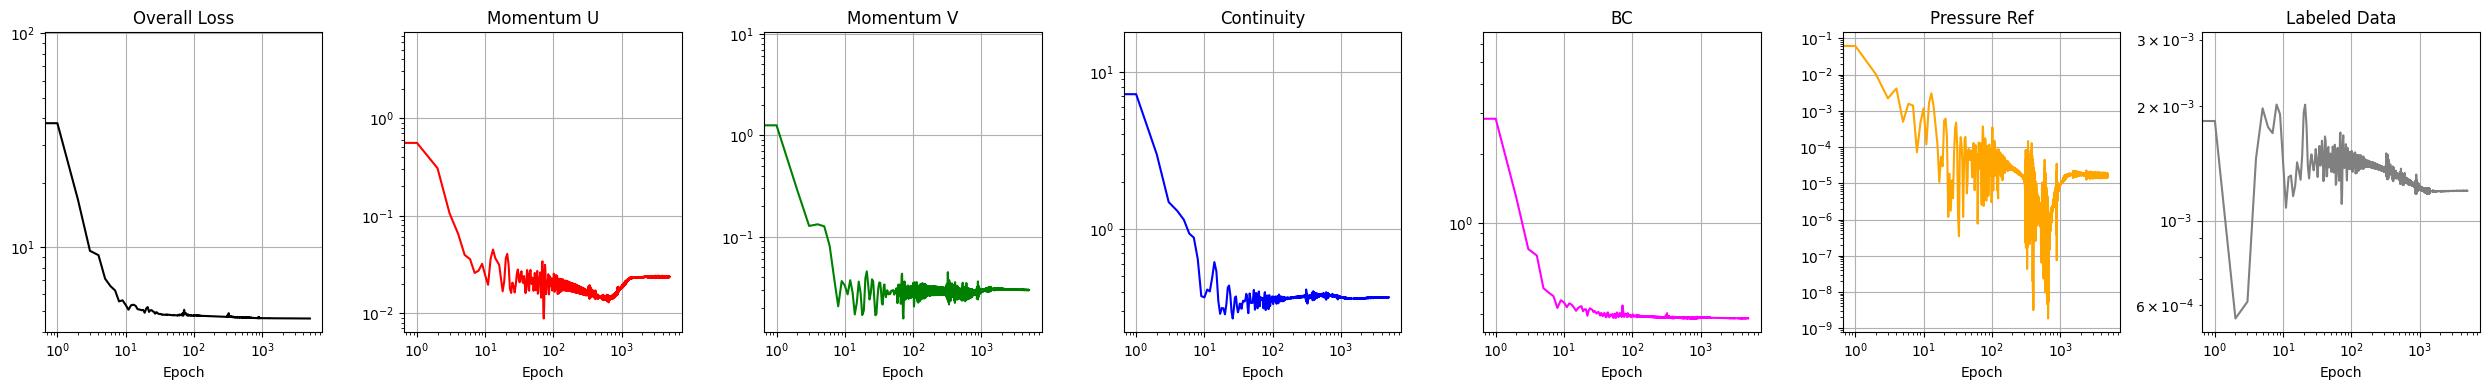

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 050_noisy_2percent ===
Re estimado: 9.3823
Rango de presión: [-0.126333, 0.059838]


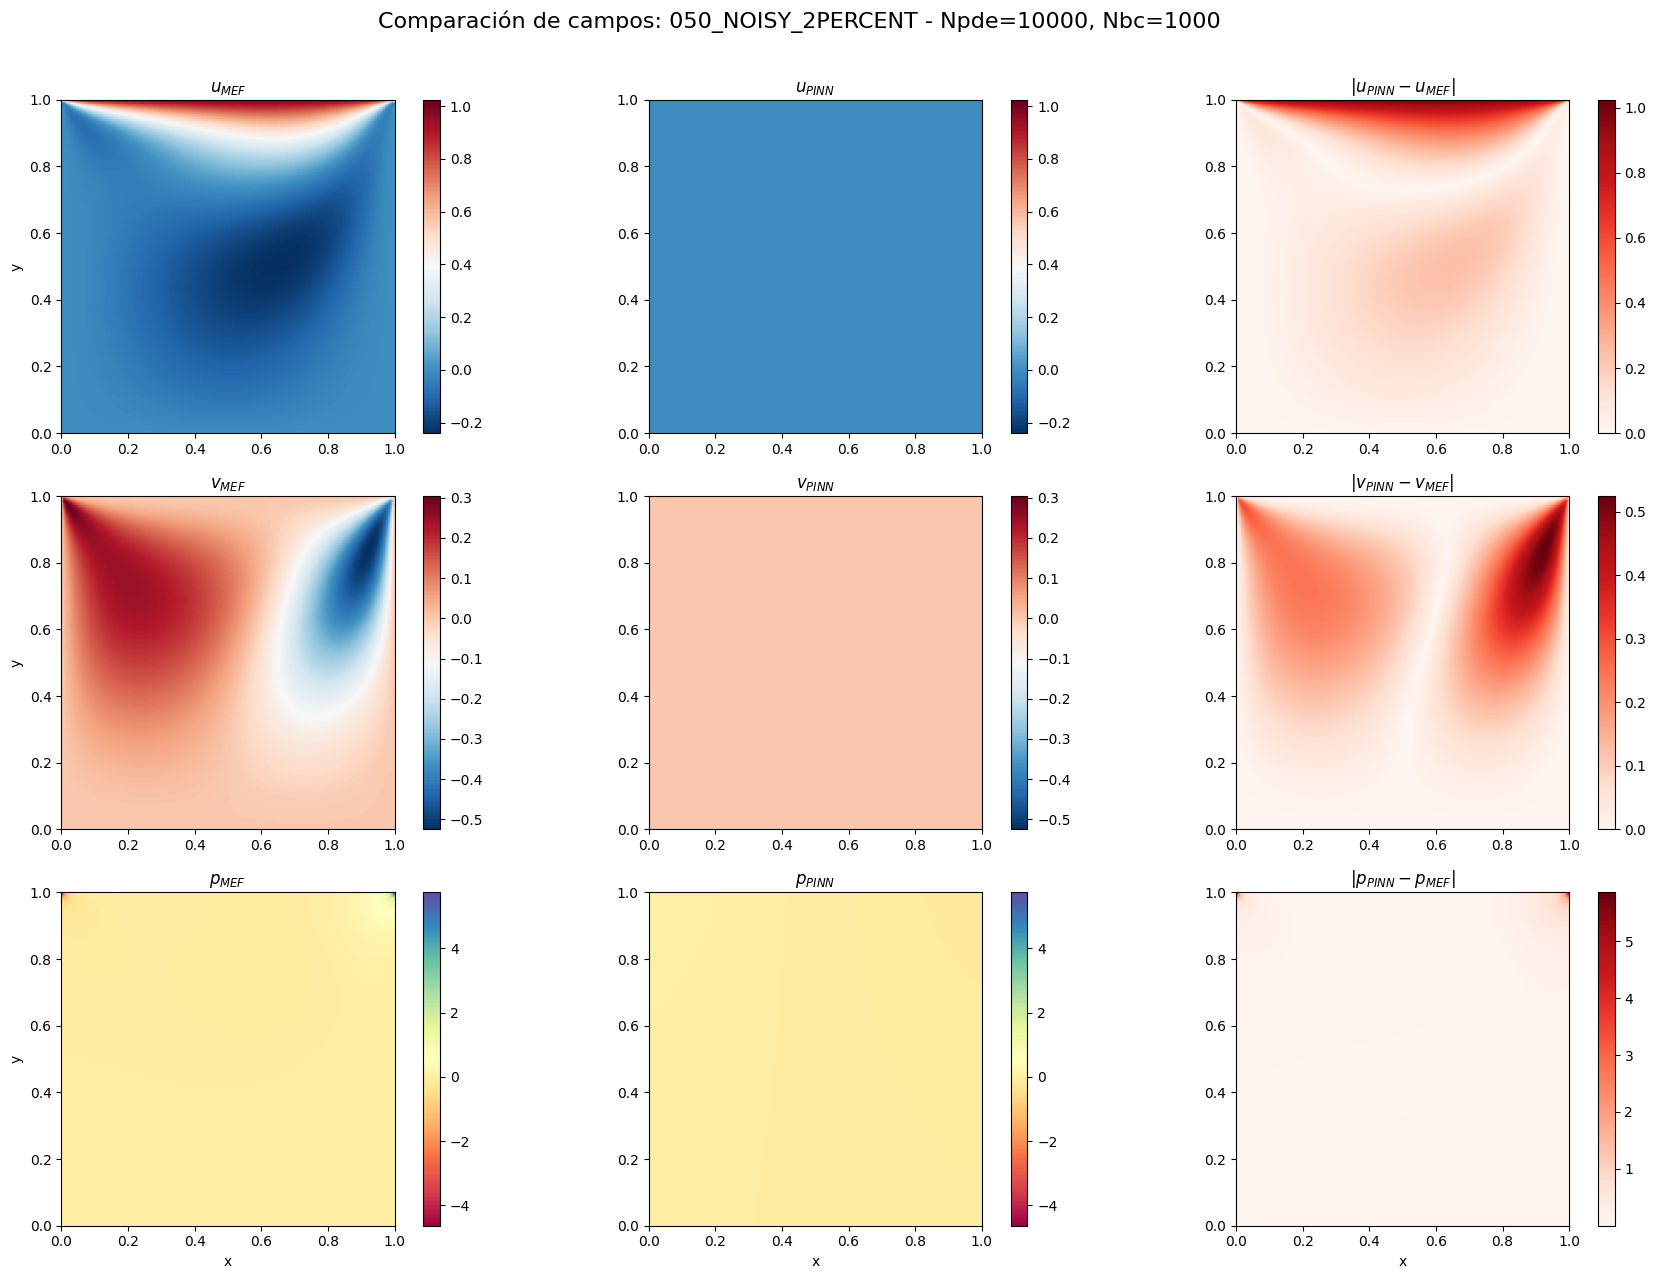

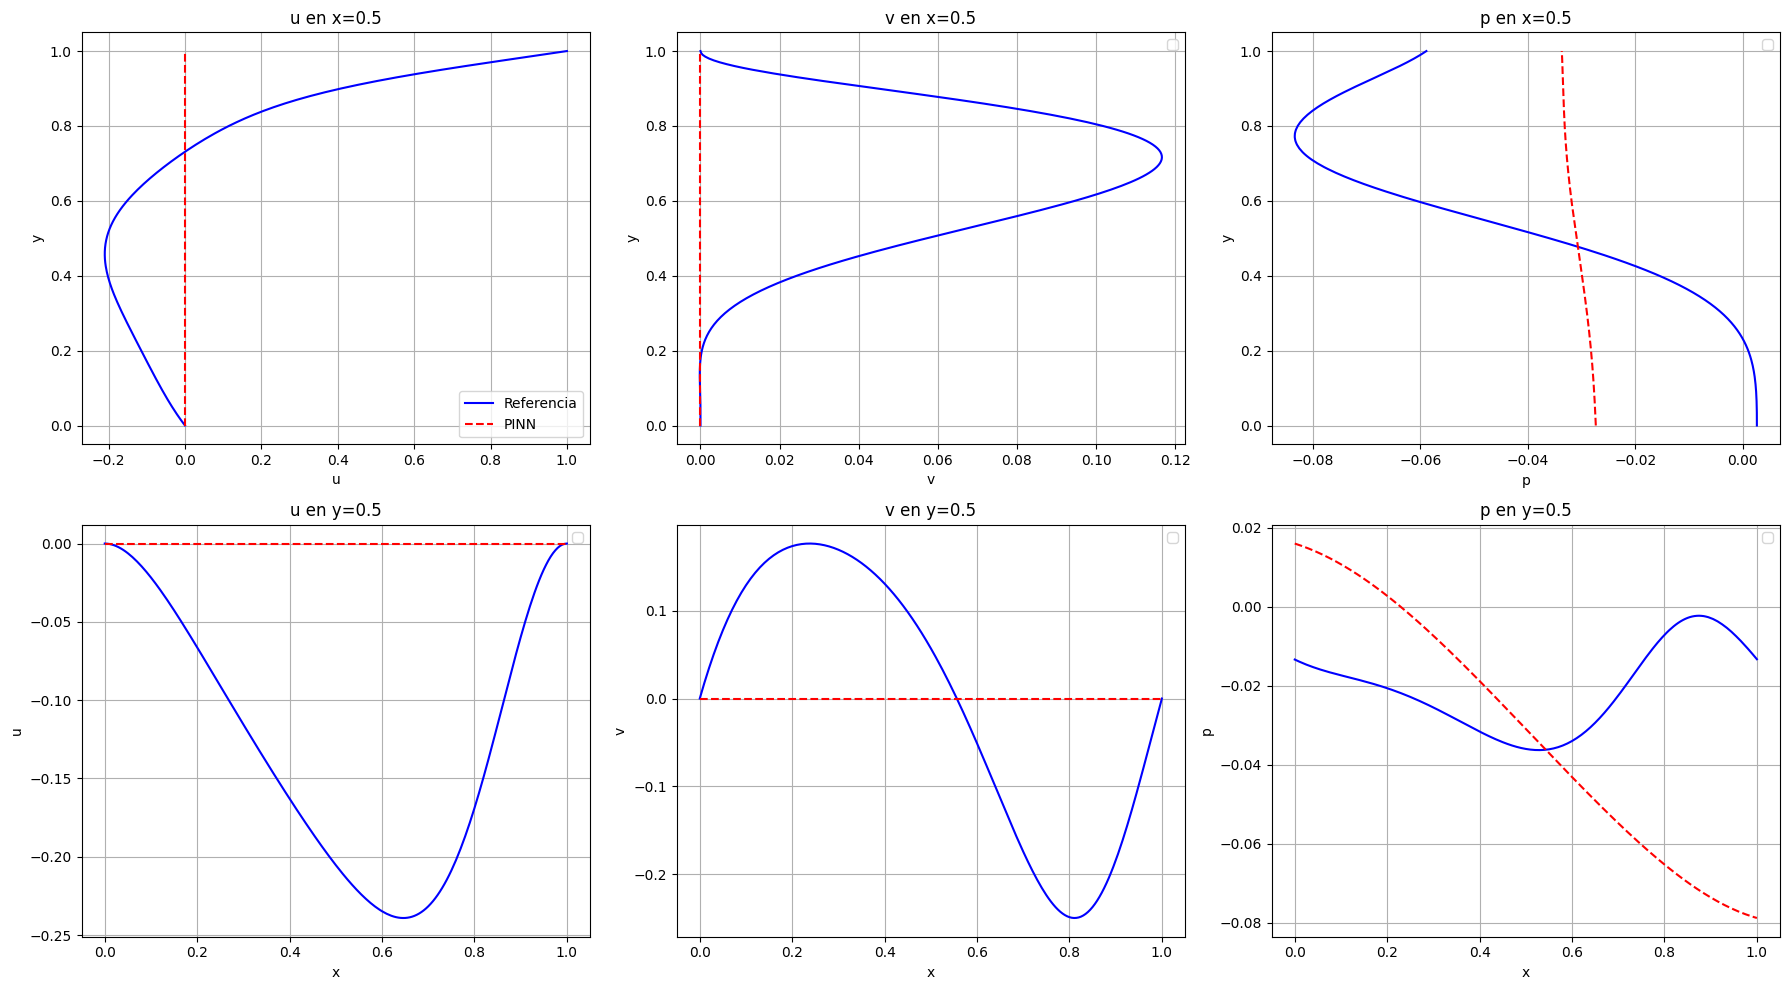


=== Entrenando modelo pressure-only: 050_noisy_5percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<34:31,  2.41it/s]

Epoch    0 | Total: 8.74e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2491 | u_top: -0.015 | Re: 50.09
  Pressure stats - min: -0.0788, max: 0.1865, mean: 0.0491


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:27<21:50,  3.43it/s]

Epoch  500 | Total: 4.69e+00 | PDE: 4.26e-01 | BC: 3.85e-01 | P_ref: 3.03e-06 | p(0,0): -0.0008 | u_top: 0.549 | Re: 20.57


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:54<19:17,  3.45it/s]

Epoch 1000 | Total: 4.65e+00 | PDE: 4.16e-01 | BC: 3.86e-01 | P_ref: 9.19e-06 | p(0,0): -0.0050 | u_top: 0.564 | Re: 11.03


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:20<16:57,  3.44it/s]

Epoch 1500 | Total: 4.64e+00 | PDE: 4.14e-01 | BC: 3.86e-01 | P_ref: 2.42e-05 | p(0,0): -0.0049 | u_top: 0.556 | Re: 9.34


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:47<14:33,  3.43it/s]

Epoch 2000 | Total: 4.64e+00 | PDE: 4.13e-01 | BC: 3.86e-01 | P_ref: 2.49e-05 | p(0,0): -0.0043 | u_top: 0.549 | Re: 9.16
  Pressure stats - min: -0.1166, max: 0.0544, mean: -0.0271


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:14<12:12,  3.41it/s]

Epoch 2500 | Total: 4.64e+00 | PDE: 4.18e-01 | BC: 3.85e-01 | P_ref: 2.31e-05 | p(0,0): -0.0051 | u_top: 0.559 | Re: 9.17


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:40<09:44,  3.42it/s]

Epoch 3000 | Total: 4.64e+00 | PDE: 4.20e-01 | BC: 3.85e-01 | P_ref: 2.22e-05 | p(0,0): -0.0050 | u_top: 0.559 | Re: 9.22


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:06<07:34,  3.30it/s]

Epoch 3500 | Total: 4.64e+00 | PDE: 4.19e-01 | BC: 3.85e-01 | P_ref: 2.31e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.25


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:32<04:49,  3.45it/s]

Epoch 4000 | Total: 4.64e+00 | PDE: 4.19e-01 | BC: 3.85e-01 | P_ref: 2.30e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.26
  Pressure stats - min: -0.1200, max: 0.0535, mean: -0.0278


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [21:58<02:26,  3.40it/s]

Epoch 4500 | Total: 4.63e+00 | PDE: 4.20e-01 | BC: 3.85e-01 | P_ref: 2.27e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.27


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:25<00:00,  3.41it/s]

Epoch 4999 | Total: 4.63e+00 | PDE: 4.20e-01 | BC: 3.84e-01 | P_ref: 2.30e-05 | p(0,0): -0.0048 | u_top: 0.557 | Re: 9.28

Valor final estimado de Re: 9.2850

Tiempo total: 1465.5 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_050_noisy_5percent_Npde10000_Nbc1000_20250810_134201.pt


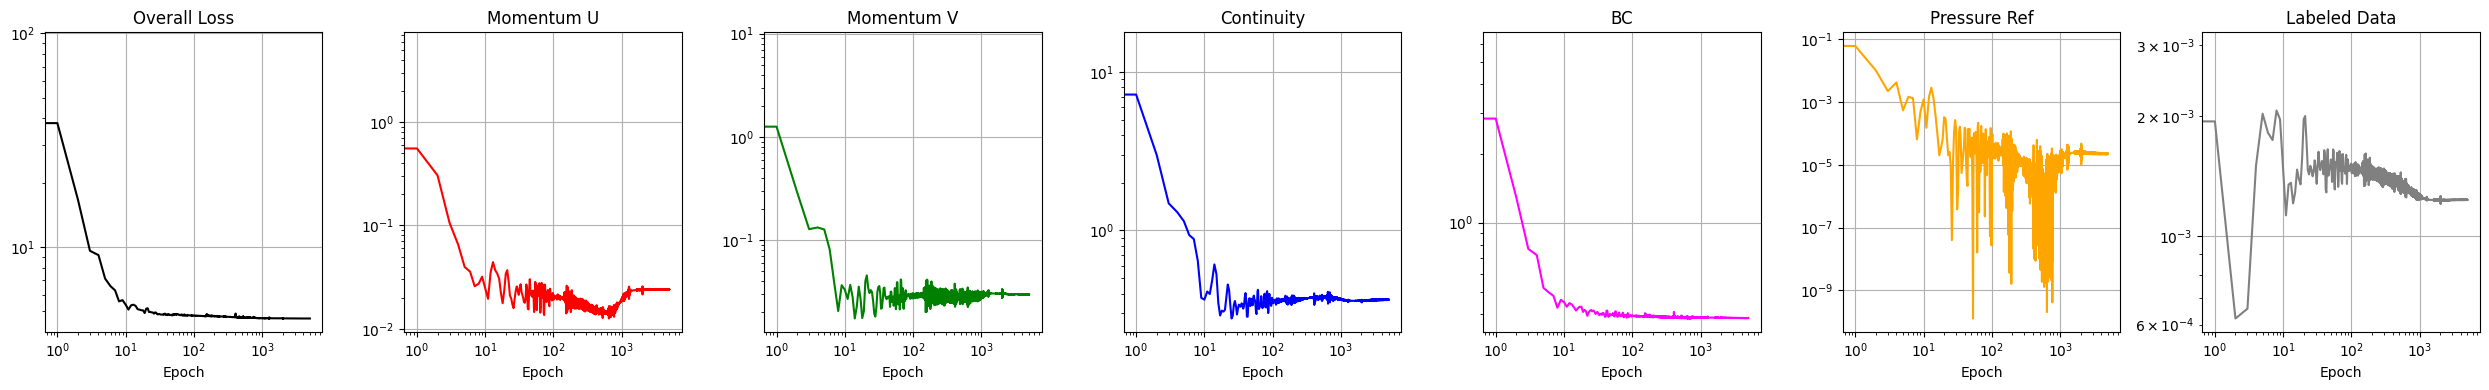

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 050_noisy_5percent ===
Re estimado: 9.2850
Rango de presión: [-0.126476, 0.058946]


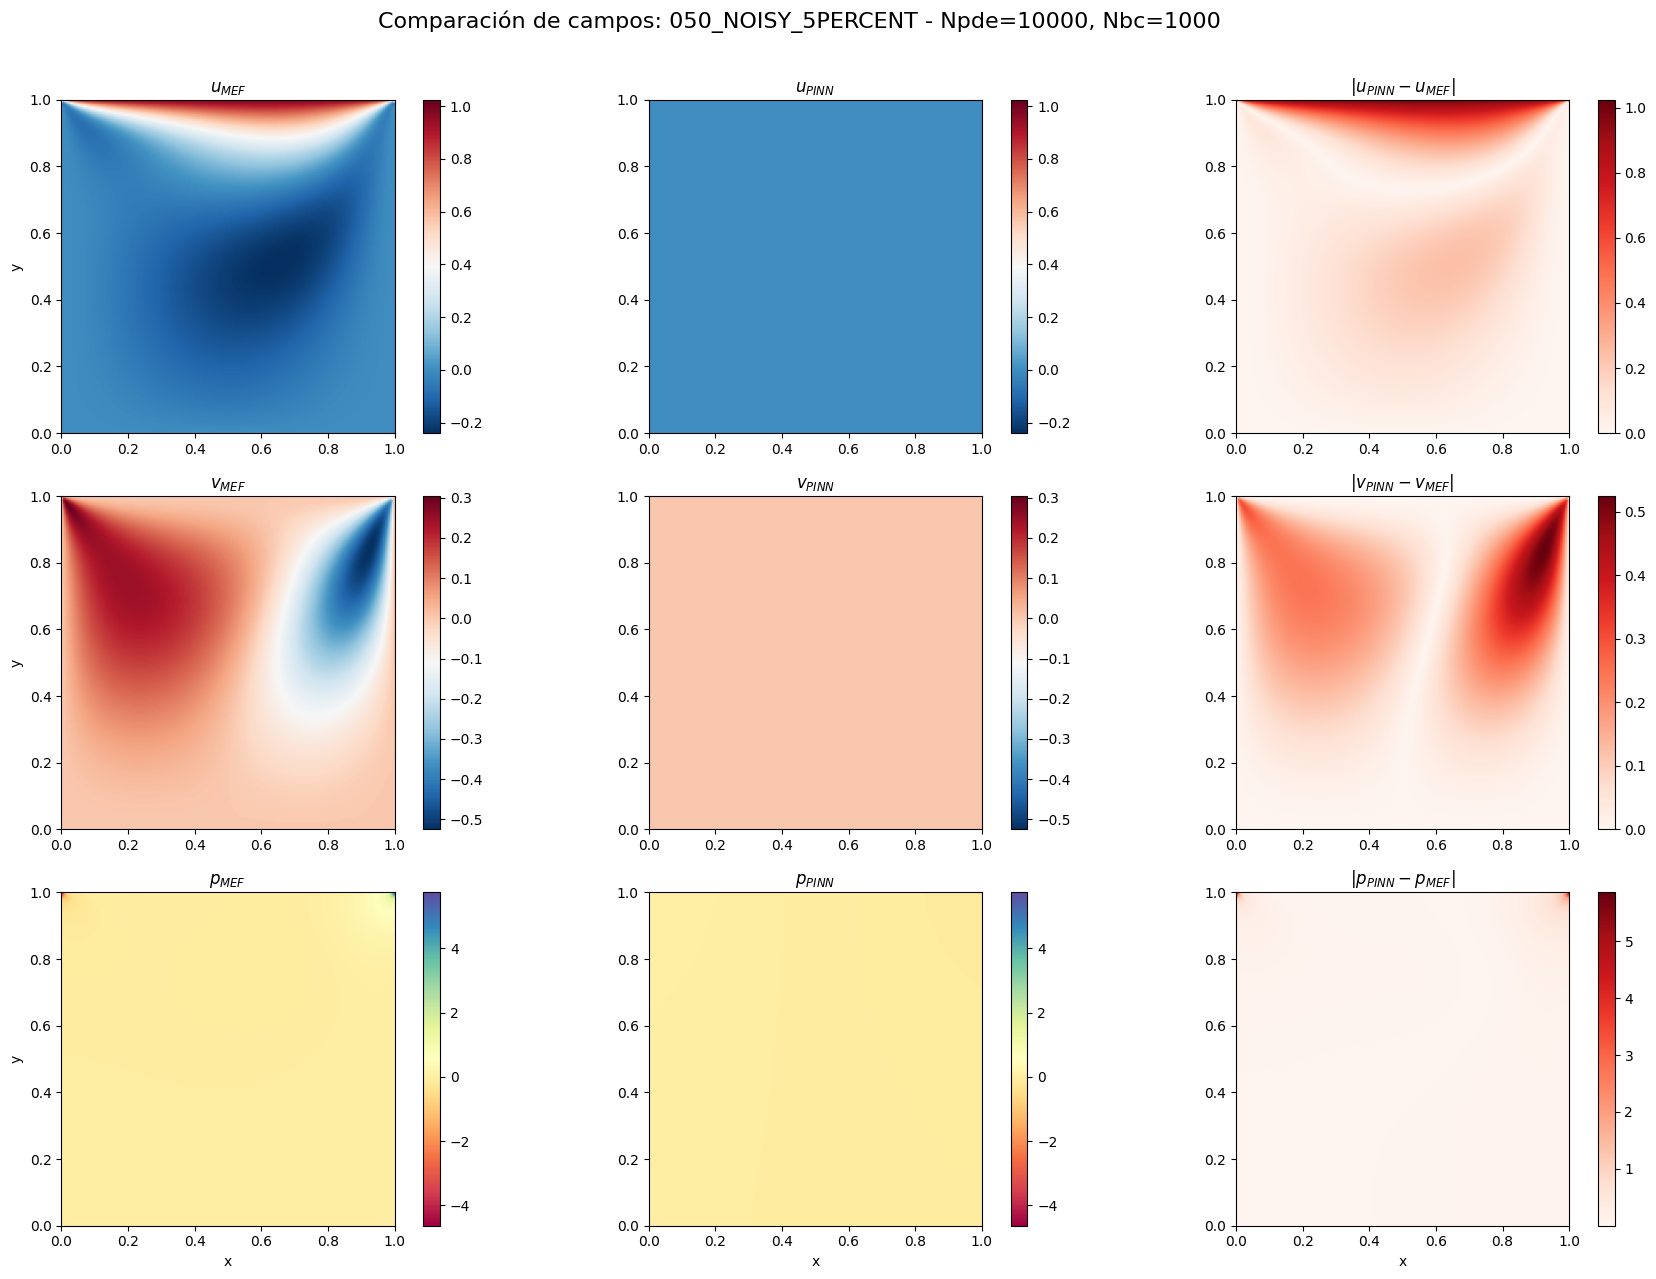

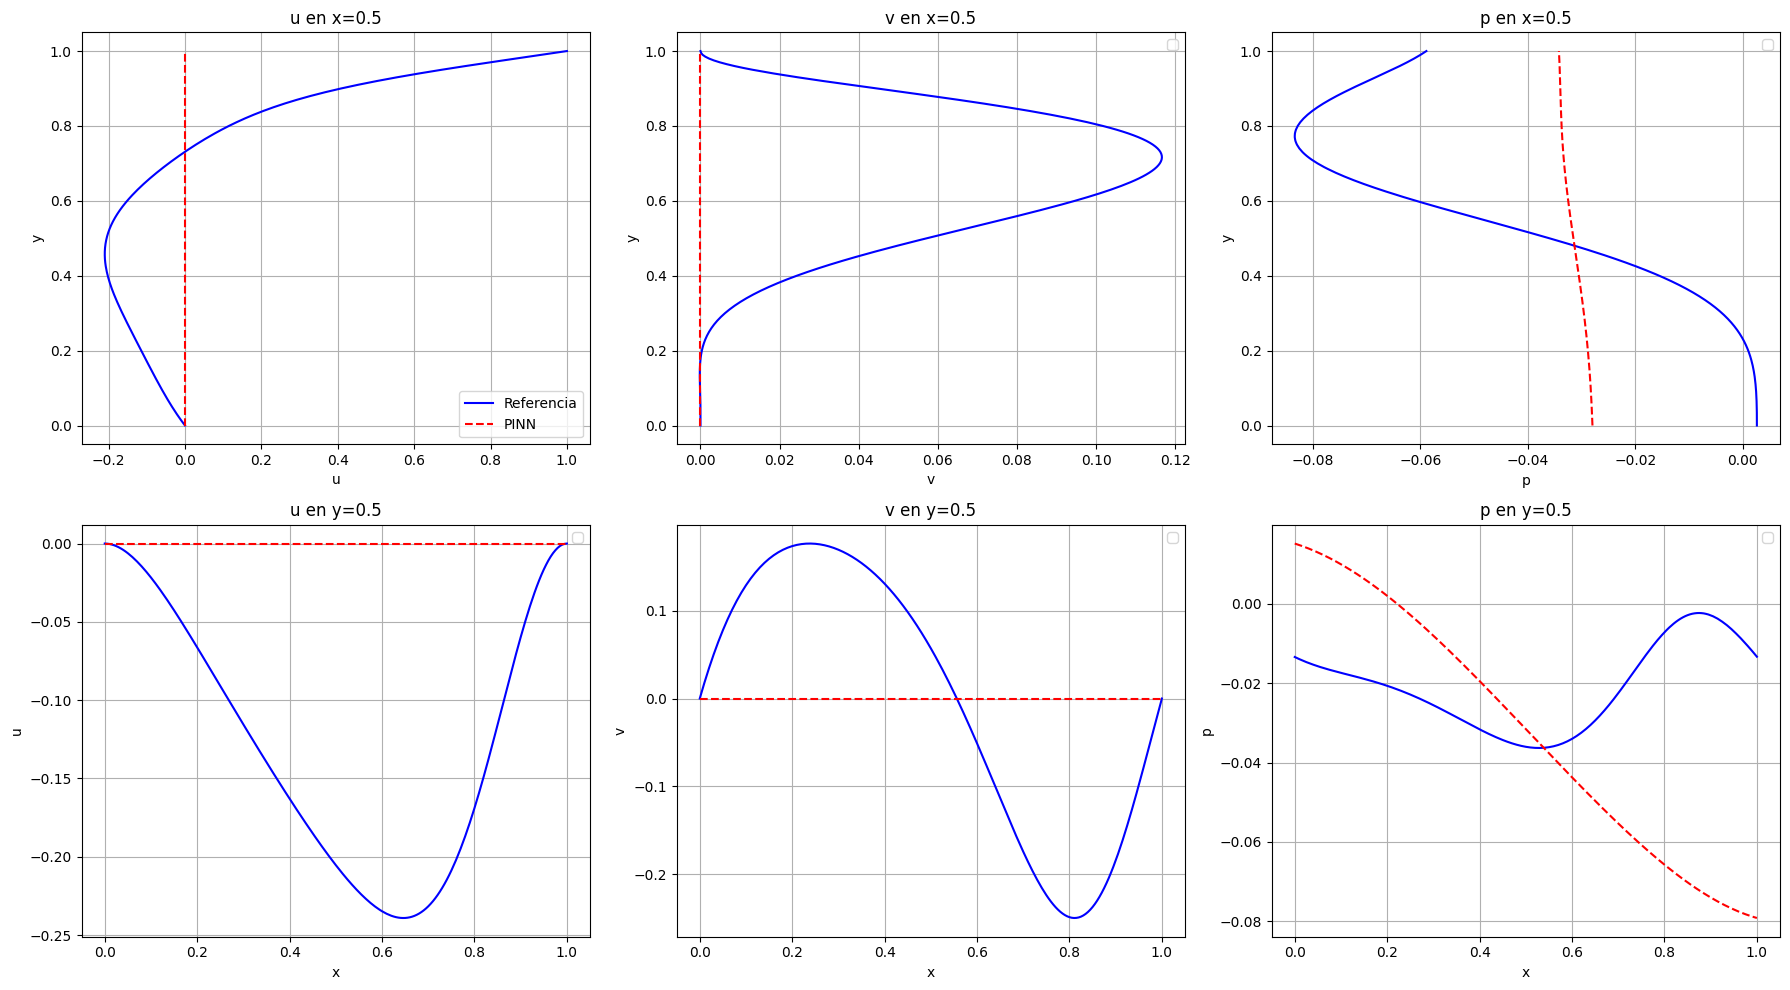


=== Entrenando modelo pressure-only: 075_clean ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<38:16,  2.18it/s]

Epoch    0 | Total: 8.92e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2402 | u_top: -0.050 | Re: 50.09
  Pressure stats - min: -0.0749, max: 0.1800, mean: 0.0477


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:27<22:37,  3.31it/s]

Epoch  500 | Total: 5.58e+00 | PDE: 3.11e-01 | BC: 4.01e-01 | P_ref: 6.86e-05 | p(0,0): 0.0097 | u_top: 0.531 | Re: 18.06


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:54<19:06,  3.49it/s]

Epoch 1000 | Total: 5.42e+00 | PDE: 3.23e-01 | BC: 3.99e-01 | P_ref: 2.70e-06 | p(0,0): 0.0021 | u_top: 0.526 | Re: 8.65


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:21<17:14,  3.38it/s]

Epoch 1500 | Total: 5.37e+00 | PDE: 3.19e-01 | BC: 4.04e-01 | P_ref: 1.10e-07 | p(0,0): 0.0004 | u_top: 0.527 | Re: 5.61


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:46<14:36,  3.42it/s]

Epoch 2000 | Total: 5.36e+00 | PDE: 3.19e-01 | BC: 4.07e-01 | P_ref: 6.47e-08 | p(0,0): -0.0003 | u_top: 0.530 | Re: 4.87
  Pressure stats - min: -0.0885, max: 0.0483, mean: -0.0175


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:13<12:18,  3.38it/s]

Epoch 2500 | Total: 5.36e+00 | PDE: 3.16e-01 | BC: 4.07e-01 | P_ref: 1.49e-07 | p(0,0): -0.0004 | u_top: 0.527 | Re: 4.78


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:40<09:58,  3.34it/s]

Epoch 3000 | Total: 5.36e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 1.49e-07 | p(0,0): -0.0004 | u_top: 0.527 | Re: 4.78


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:07<07:14,  3.45it/s]

Epoch 3500 | Total: 5.36e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 1.56e-07 | p(0,0): -0.0004 | u_top: 0.527 | Re: 4.79


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:35<04:55,  3.38it/s]

Epoch 4000 | Total: 5.36e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 1.36e-07 | p(0,0): -0.0004 | u_top: 0.527 | Re: 4.79
  Pressure stats - min: -0.0874, max: 0.0478, mean: -0.0174


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:02<02:26,  3.41it/s]

Epoch 4500 | Total: 5.36e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 1.32e-07 | p(0,0): -0.0004 | u_top: 0.527 | Re: 4.79


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:28<00:00,  3.40it/s]

Epoch 4999 | Total: 5.36e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 1.20e-07 | p(0,0): -0.0004 | u_top: 0.528 | Re: 4.79

Valor final estimado de Re: 4.7922

Tiempo total: 1468.6 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_075_clean_Npde10000_Nbc1000_20250810_140639.pt


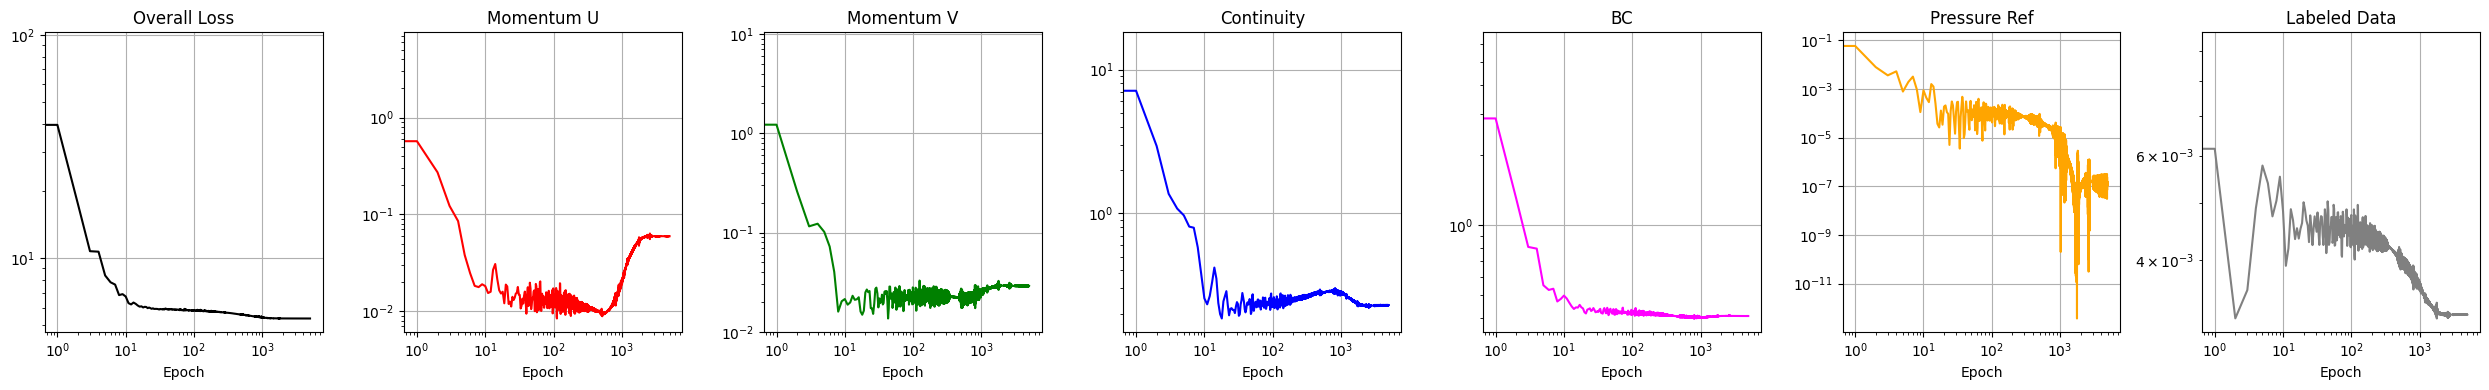

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 075_clean ===
Re estimado: 4.7922
Rango de presión: [-0.093026, 0.052383]


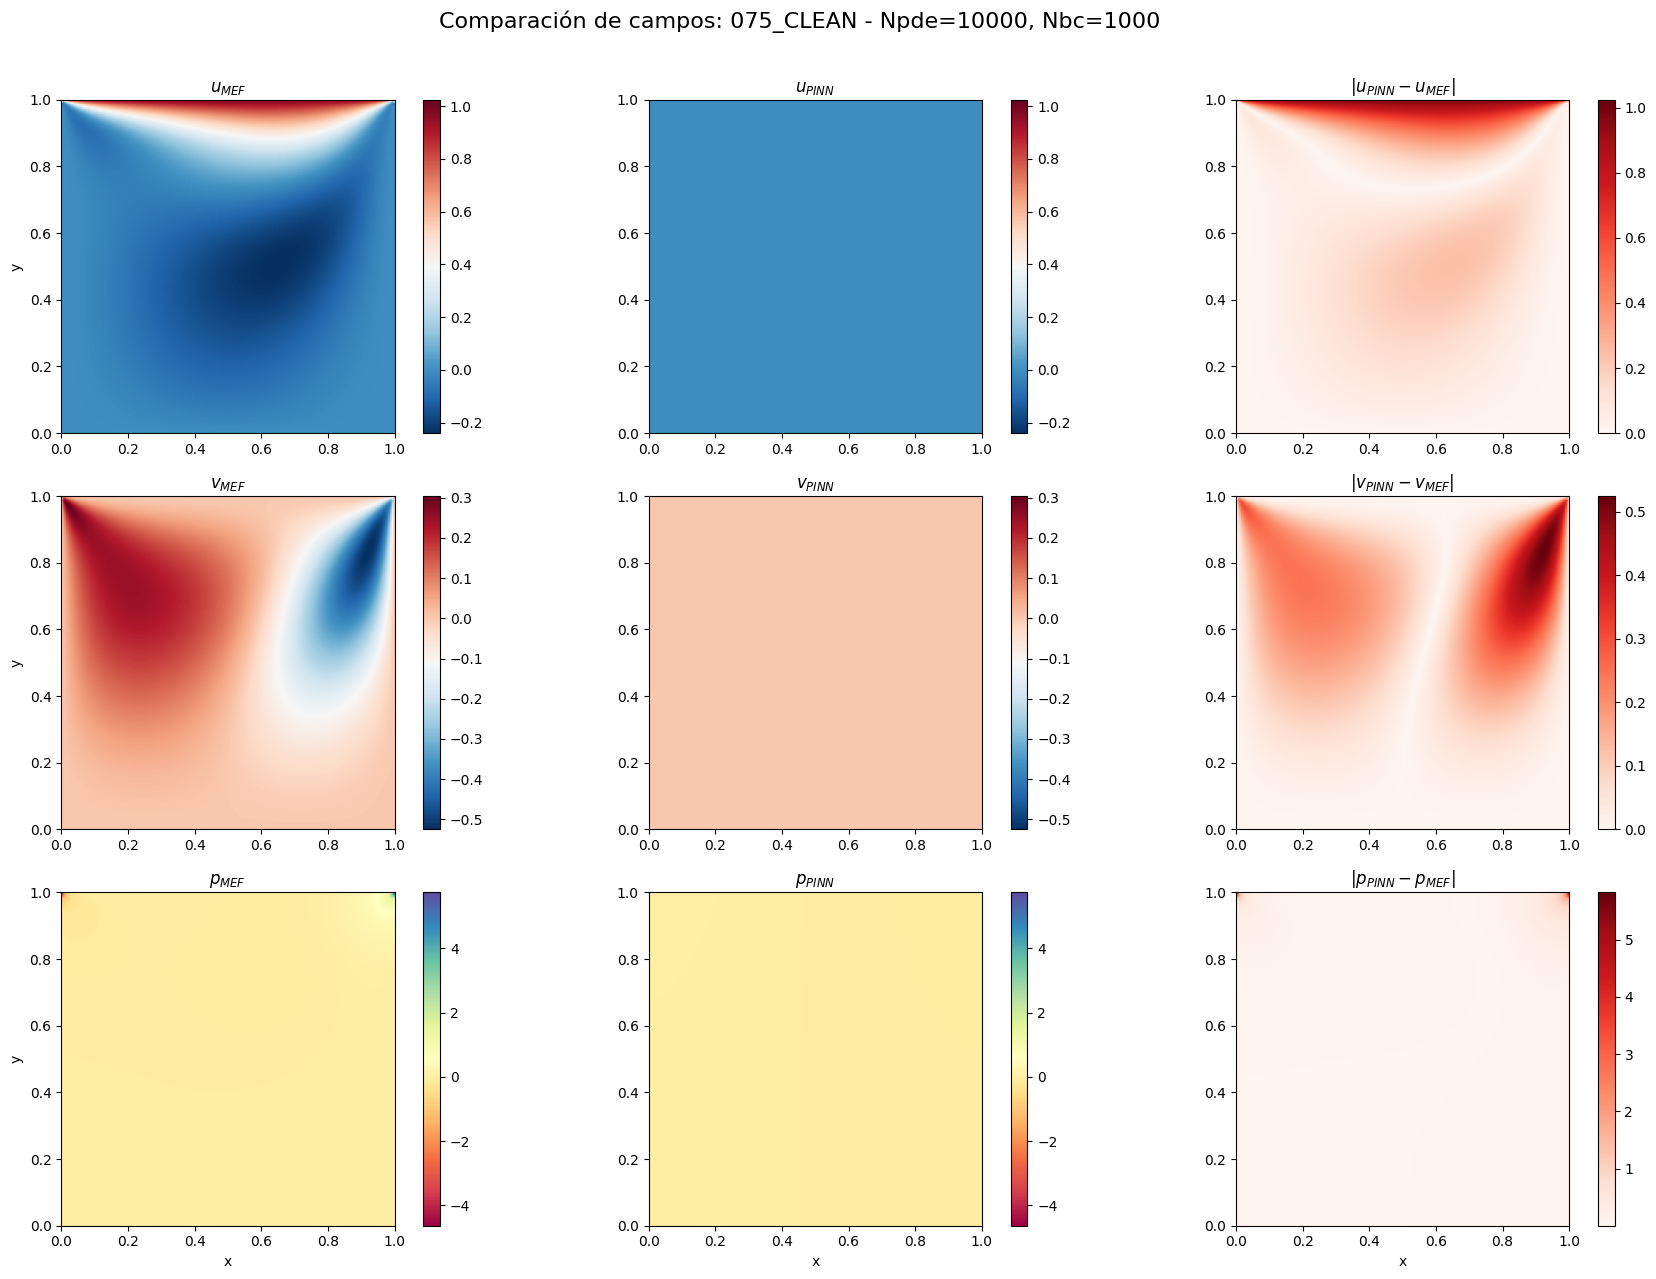

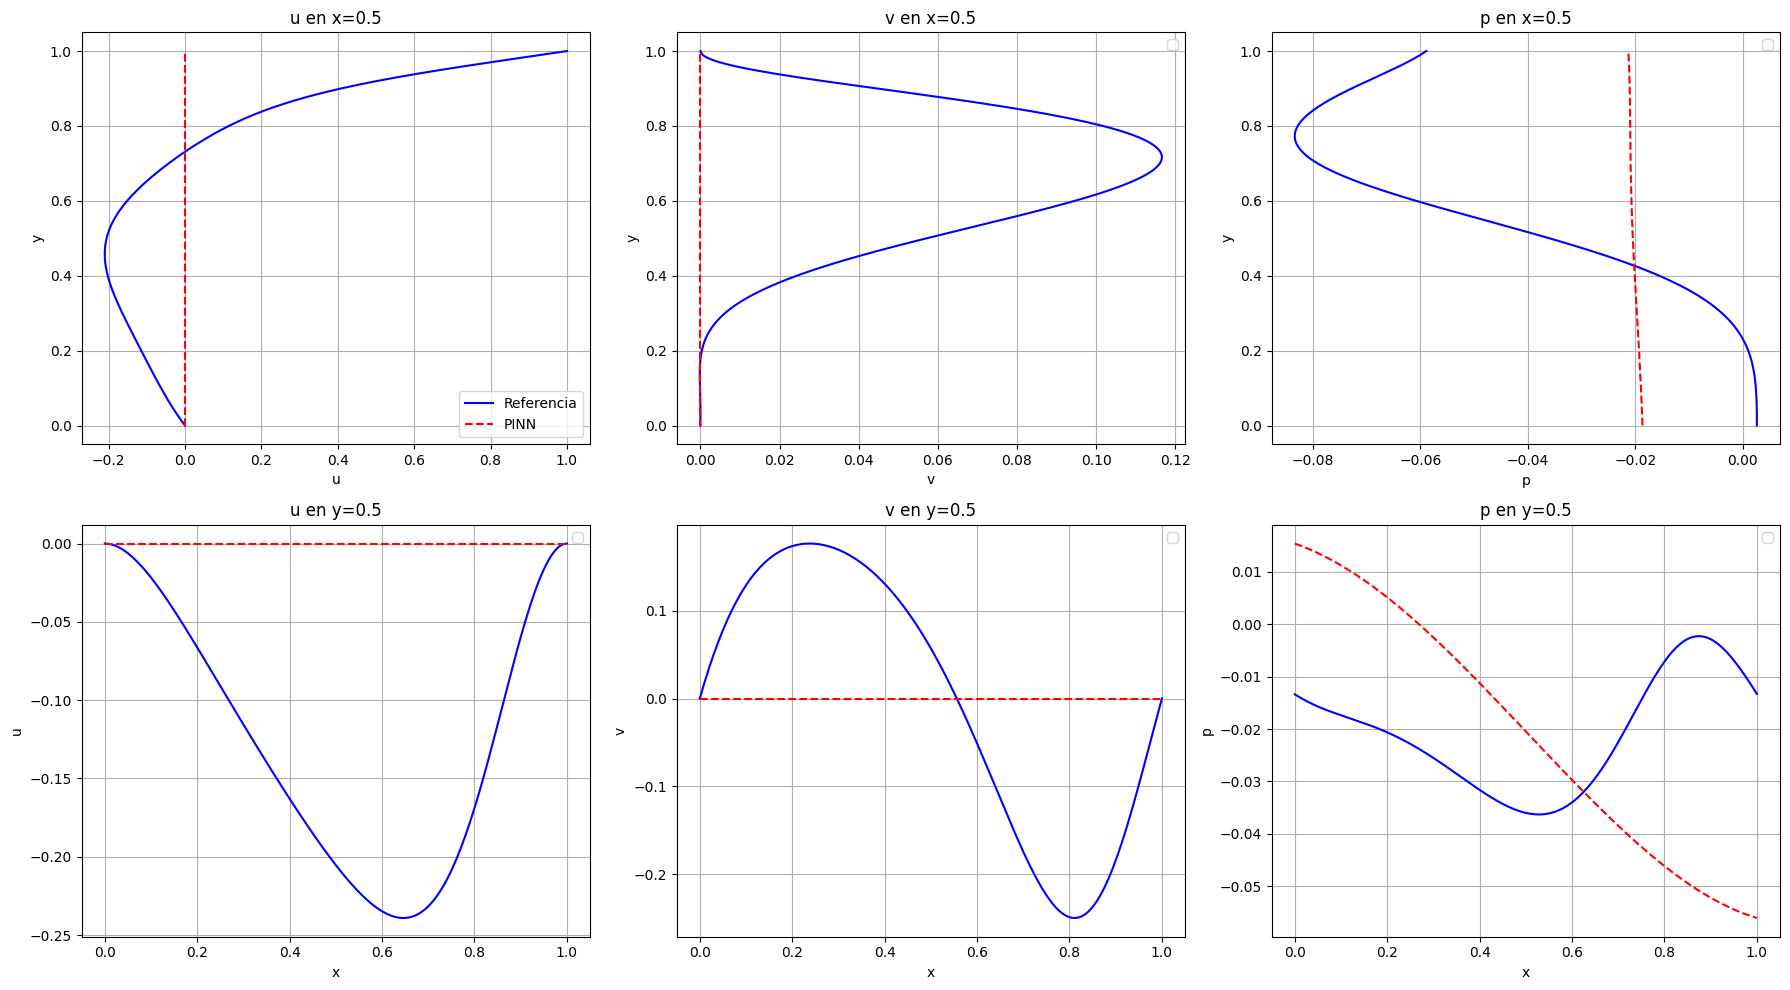


=== Entrenando modelo pressure-only: 075_noisy_1percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<38:52,  2.14it/s]

Epoch    0 | Total: 8.92e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2402 | u_top: -0.050 | Re: 50.09
  Pressure stats - min: -0.0749, max: 0.1800, mean: 0.0477


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:27<23:05,  3.25it/s]

Epoch  500 | Total: 5.55e+00 | PDE: 3.16e-01 | BC: 4.03e-01 | P_ref: 8.48e-05 | p(0,0): 0.0088 | u_top: 0.508 | Re: 18.36


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:53<19:17,  3.45it/s]

Epoch 1000 | Total: 5.39e+00 | PDE: 3.29e-01 | BC: 4.00e-01 | P_ref: 1.18e-05 | p(0,0): 0.0028 | u_top: 0.520 | Re: 8.60


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:19<17:21,  3.36it/s]

Epoch 1500 | Total: 5.35e+00 | PDE: 3.16e-01 | BC: 4.04e-01 | P_ref: 1.84e-08 | p(0,0): 0.0006 | u_top: 0.518 | Re: 5.61


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:44<14:52,  3.36it/s]

Epoch 2000 | Total: 5.34e+00 | PDE: 3.19e-01 | BC: 4.06e-01 | P_ref: 2.90e-09 | p(0,0): 0.0000 | u_top: 0.528 | Re: 4.92
  Pressure stats - min: -0.0880, max: 0.0487, mean: -0.0171


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:10<12:07,  3.44it/s]

Epoch 2500 | Total: 5.34e+00 | PDE: 3.20e-01 | BC: 4.07e-01 | P_ref: 3.22e-10 | p(0,0): -0.0001 | u_top: 0.529 | Re: 4.83


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:35<09:35,  3.47it/s]

Epoch 3000 | Total: 5.34e+00 | PDE: 3.19e-01 | BC: 4.06e-01 | P_ref: 4.02e-10 | p(0,0): -0.0001 | u_top: 0.529 | Re: 4.83


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:02<07:23,  3.38it/s]

Epoch 3500 | Total: 5.34e+00 | PDE: 3.19e-01 | BC: 4.06e-01 | P_ref: 1.99e-11 | p(0,0): -0.0000 | u_top: 0.528 | Re: 4.83


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:28<04:58,  3.35it/s]

Epoch 4000 | Total: 5.34e+00 | PDE: 3.19e-01 | BC: 4.06e-01 | P_ref: 6.20e-11 | p(0,0): -0.0000 | u_top: 0.528 | Re: 4.84
  Pressure stats - min: -0.0875, max: 0.0483, mean: -0.0172


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [21:55<02:33,  3.25it/s]

Epoch 4500 | Total: 5.34e+00 | PDE: 3.20e-01 | BC: 4.06e-01 | P_ref: 3.42e-09 | p(0,0): -0.0001 | u_top: 0.528 | Re: 4.84


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:21<00:00,  3.42it/s]

Epoch 4999 | Total: 5.34e+00 | PDE: 3.19e-01 | BC: 4.06e-01 | P_ref: 7.34e-11 | p(0,0): -0.0000 | u_top: 0.528 | Re: 4.84

Valor final estimado de Re: 4.8393

Tiempo total: 1461.5 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_075_noisy_1percent_Npde10000_Nbc1000_20250810_143109.pt


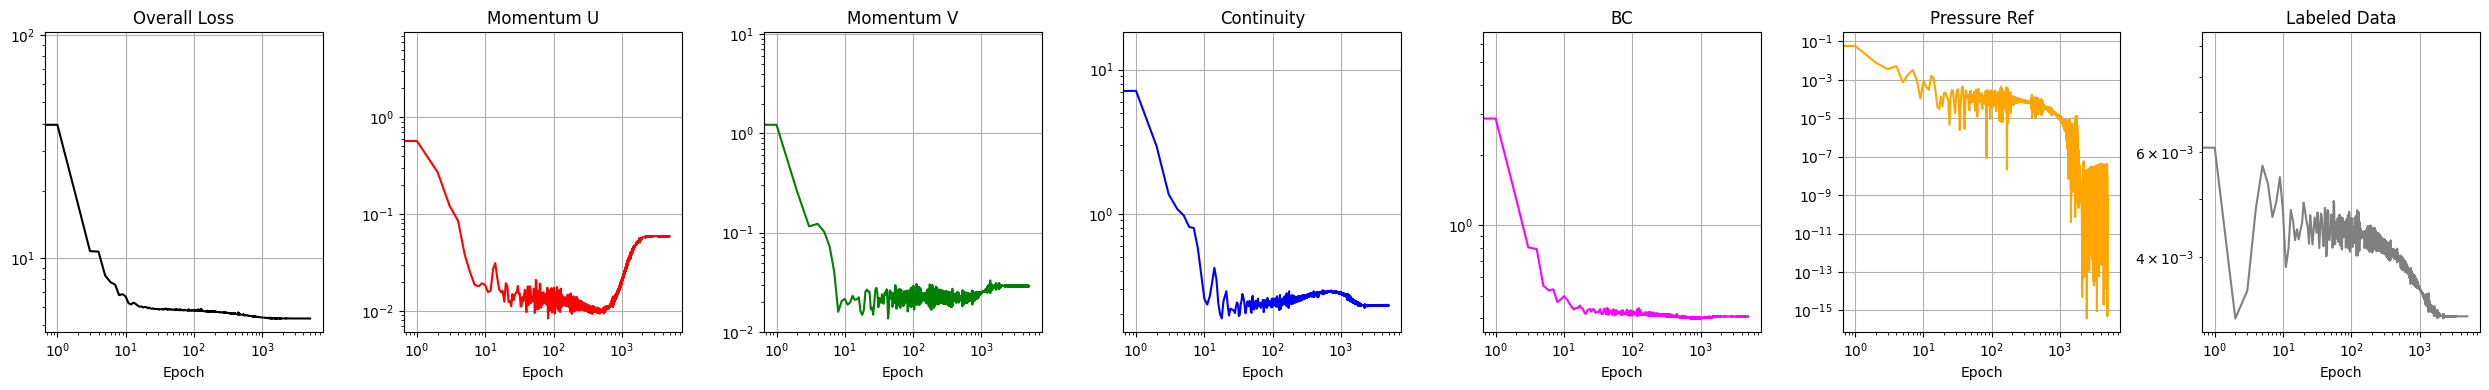

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 075_noisy_1percent ===
Re estimado: 4.8393
Rango de presión: [-0.093023, 0.052953]


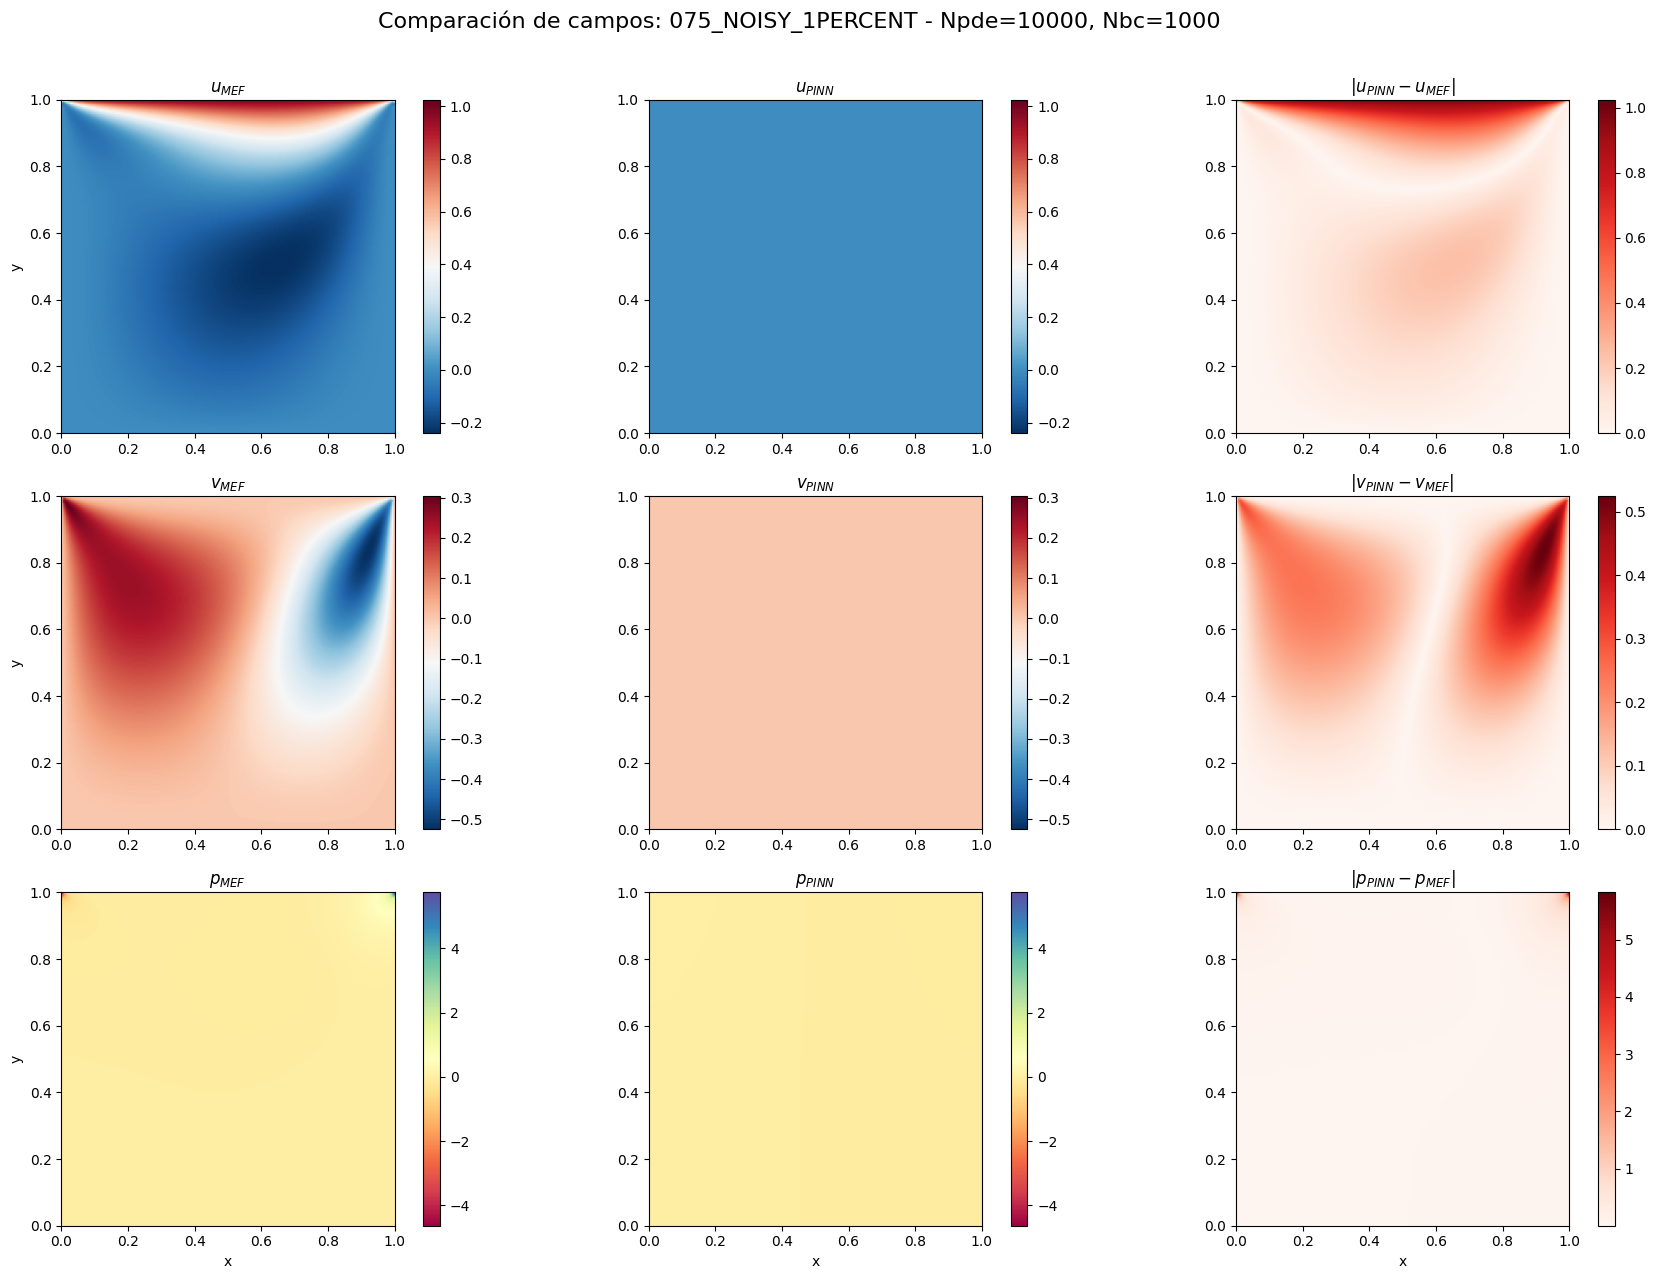

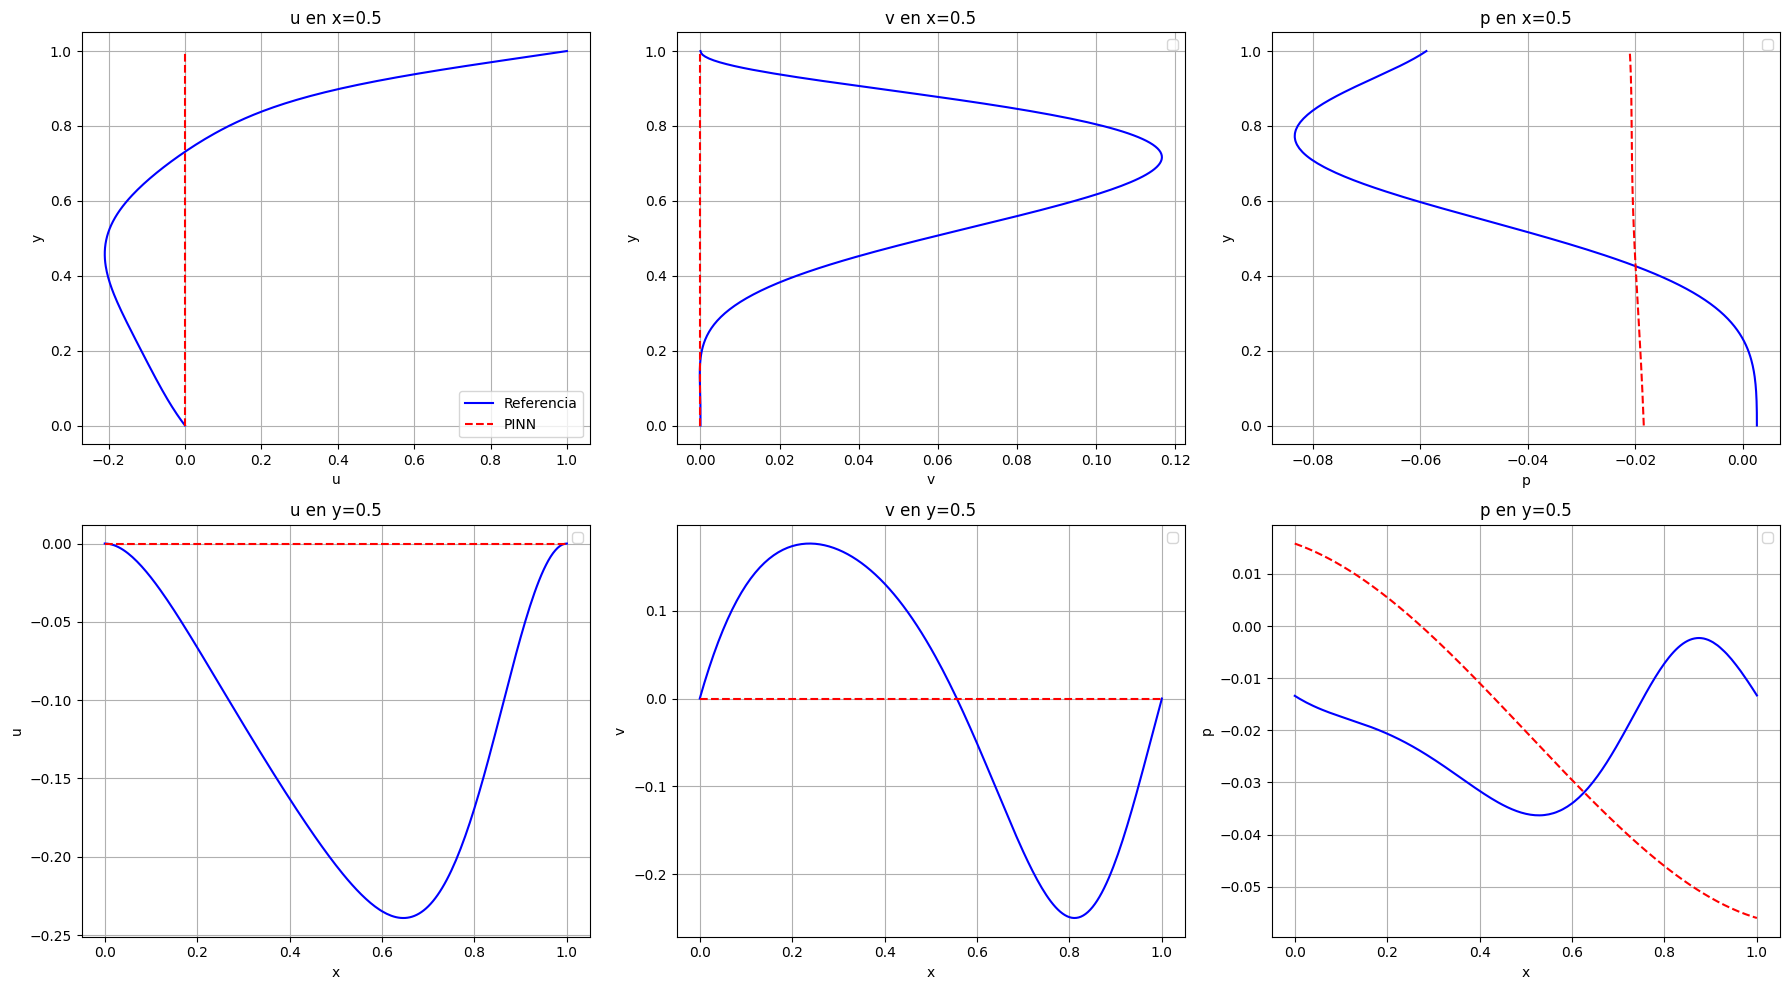


=== Entrenando modelo pressure-only: 075_noisy_2percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<34:16,  2.43it/s]

Epoch    0 | Total: 8.92e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2402 | u_top: -0.051 | Re: 50.09
  Pressure stats - min: -0.0749, max: 0.1800, mean: 0.0477


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:27<22:15,  3.37it/s]

Epoch  500 | Total: 5.60e+00 | PDE: 3.07e-01 | BC: 4.05e-01 | P_ref: 4.56e-05 | p(0,0): 0.0084 | u_top: 0.503 | Re: 18.69


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:55<19:50,  3.36it/s]

Epoch 1000 | Total: 5.43e+00 | PDE: 3.27e-01 | BC: 4.03e-01 | P_ref: 1.33e-05 | p(0,0): 0.0034 | u_top: 0.511 | Re: 8.61


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:27<16:51,  3.46it/s]

Epoch 1500 | Total: 5.39e+00 | PDE: 3.25e-01 | BC: 4.05e-01 | P_ref: 2.16e-06 | p(0,0): 0.0015 | u_top: 0.528 | Re: 5.62


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:56<18:29,  2.70it/s]

Epoch 2000 | Total: 5.38e+00 | PDE: 3.19e-01 | BC: 4.07e-01 | P_ref: 1.00e-07 | p(0,0): 0.0002 | u_top: 0.530 | Re: 4.88
  Pressure stats - min: -0.0881, max: 0.0487, mean: -0.0170


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:27<12:15,  3.40it/s]

Epoch 2500 | Total: 5.38e+00 | PDE: 3.16e-01 | BC: 4.07e-01 | P_ref: 1.92e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.79


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:56<09:50,  3.39it/s]

Epoch 3000 | Total: 5.37e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 3.65e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.79


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:27<07:39,  3.26it/s]

Epoch 3500 | Total: 5.37e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 4.56e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.80


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:59<04:52,  3.41it/s]

Epoch 4000 | Total: 5.37e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 4.10e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.80
  Pressure stats - min: -0.0869, max: 0.0484, mean: -0.0168


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:27<02:28,  3.37it/s]

Epoch 4500 | Total: 5.37e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 4.75e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.80


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:58<00:00,  3.34it/s]

Epoch 4999 | Total: 5.37e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 4.06e-08 | p(0,0): 0.0002 | u_top: 0.527 | Re: 4.80

Valor final estimado de Re: 4.8041

Tiempo total: 1498.2 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_075_noisy_2percent_Npde10000_Nbc1000_20250810_145616.pt


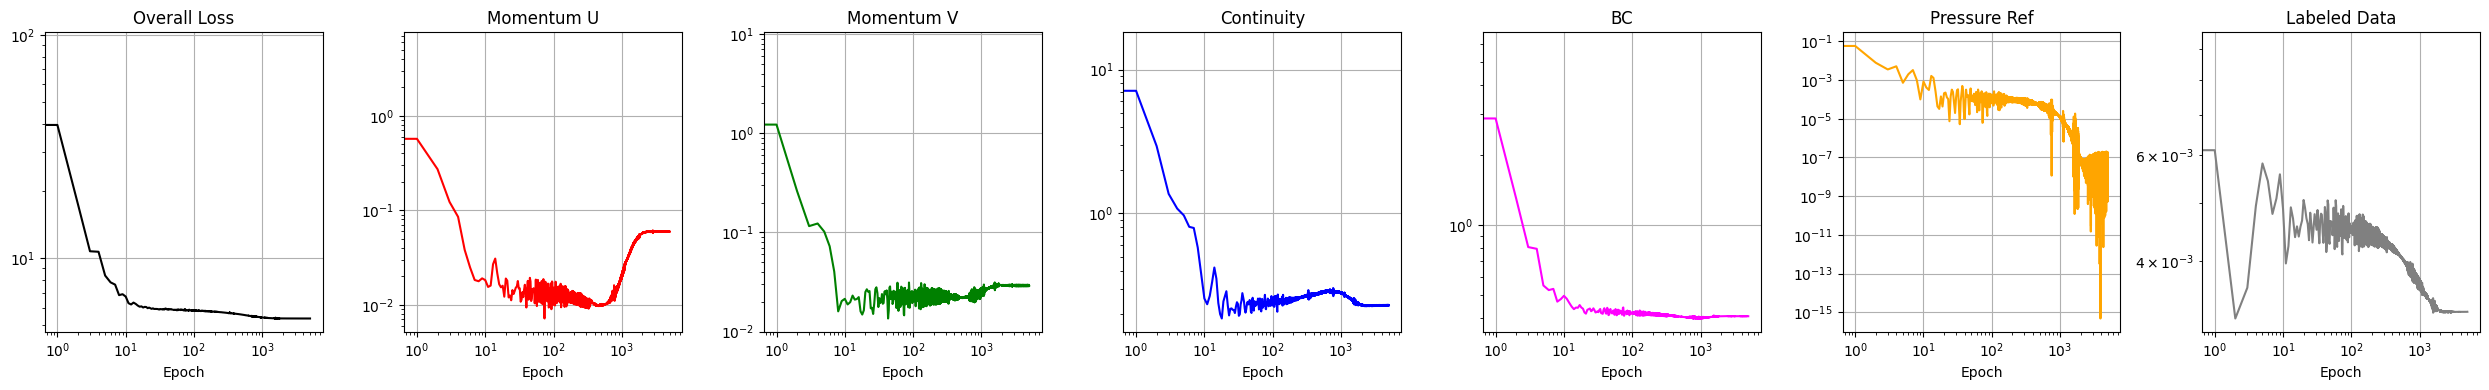

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 075_noisy_2percent ===
Re estimado: 4.8041
Rango de presión: [-0.092474, 0.053016]


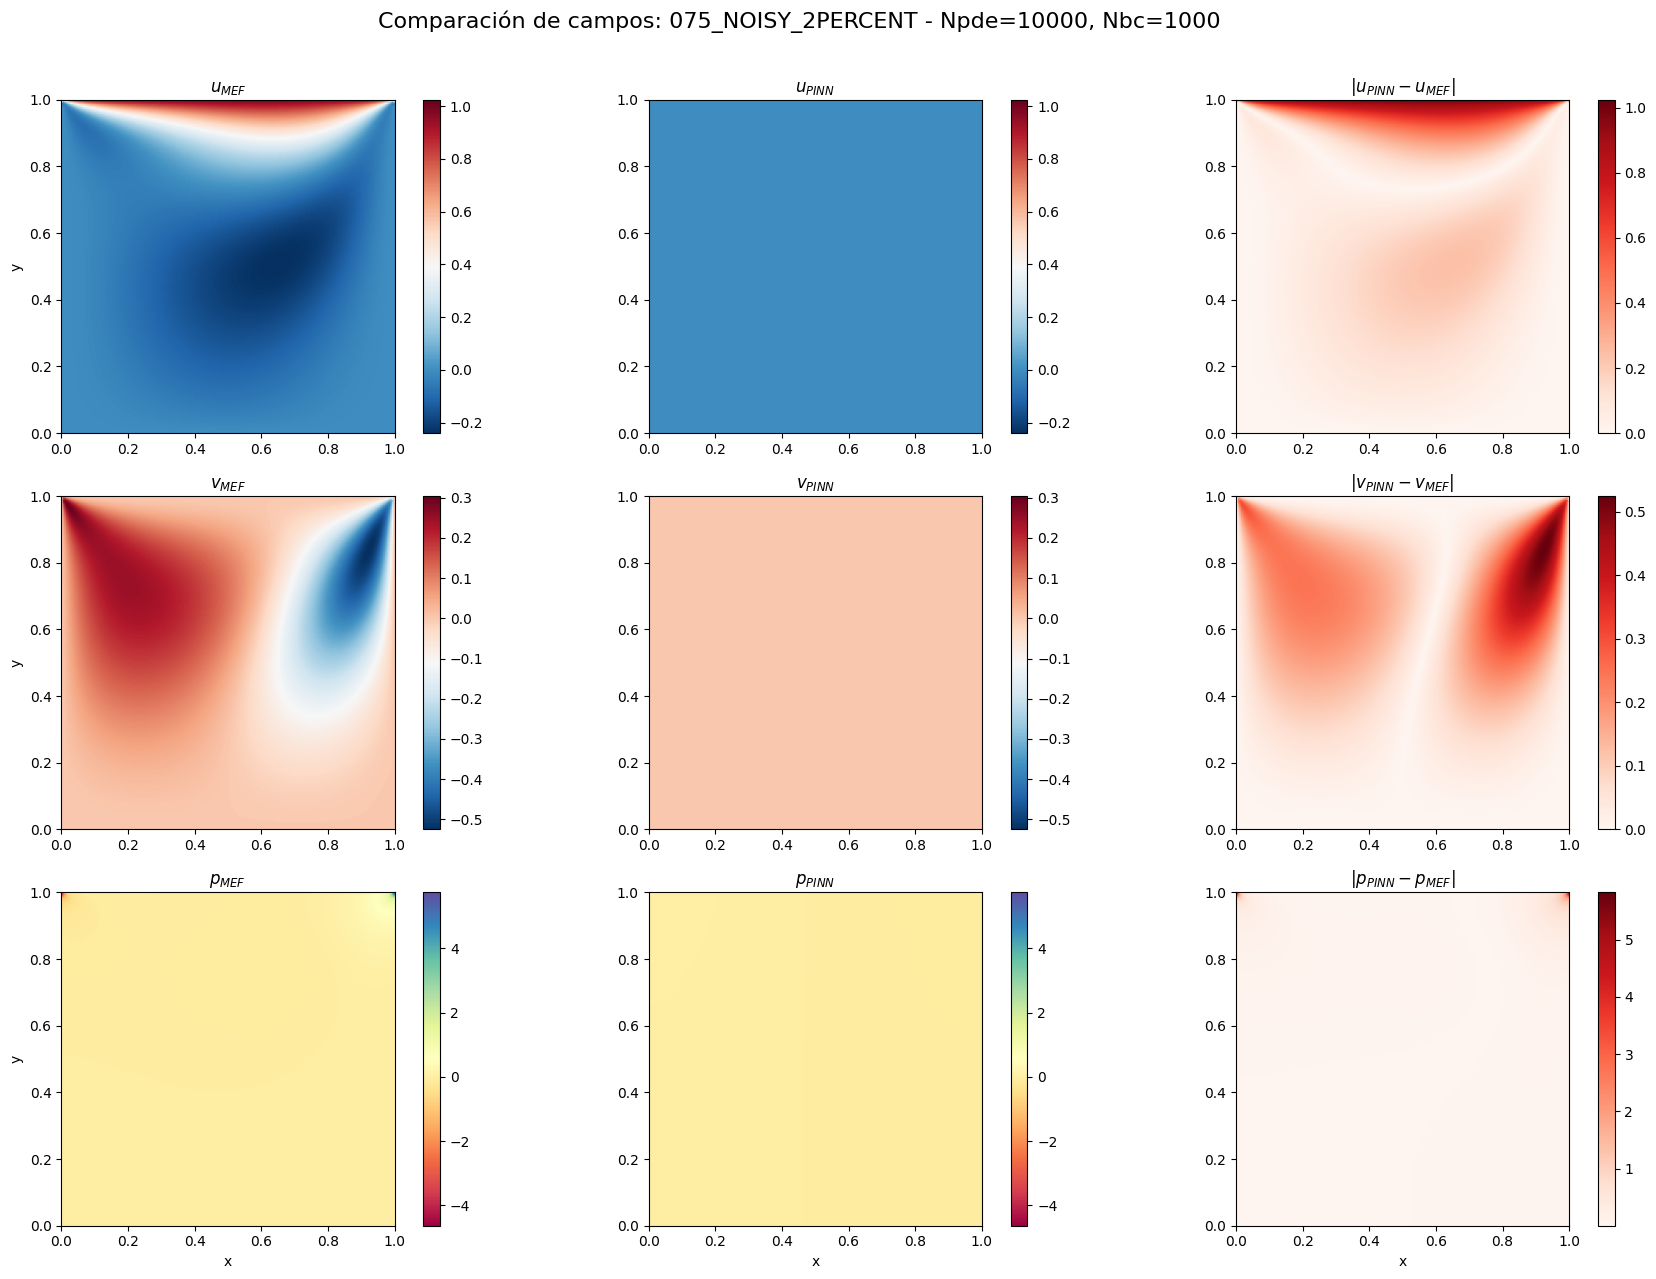

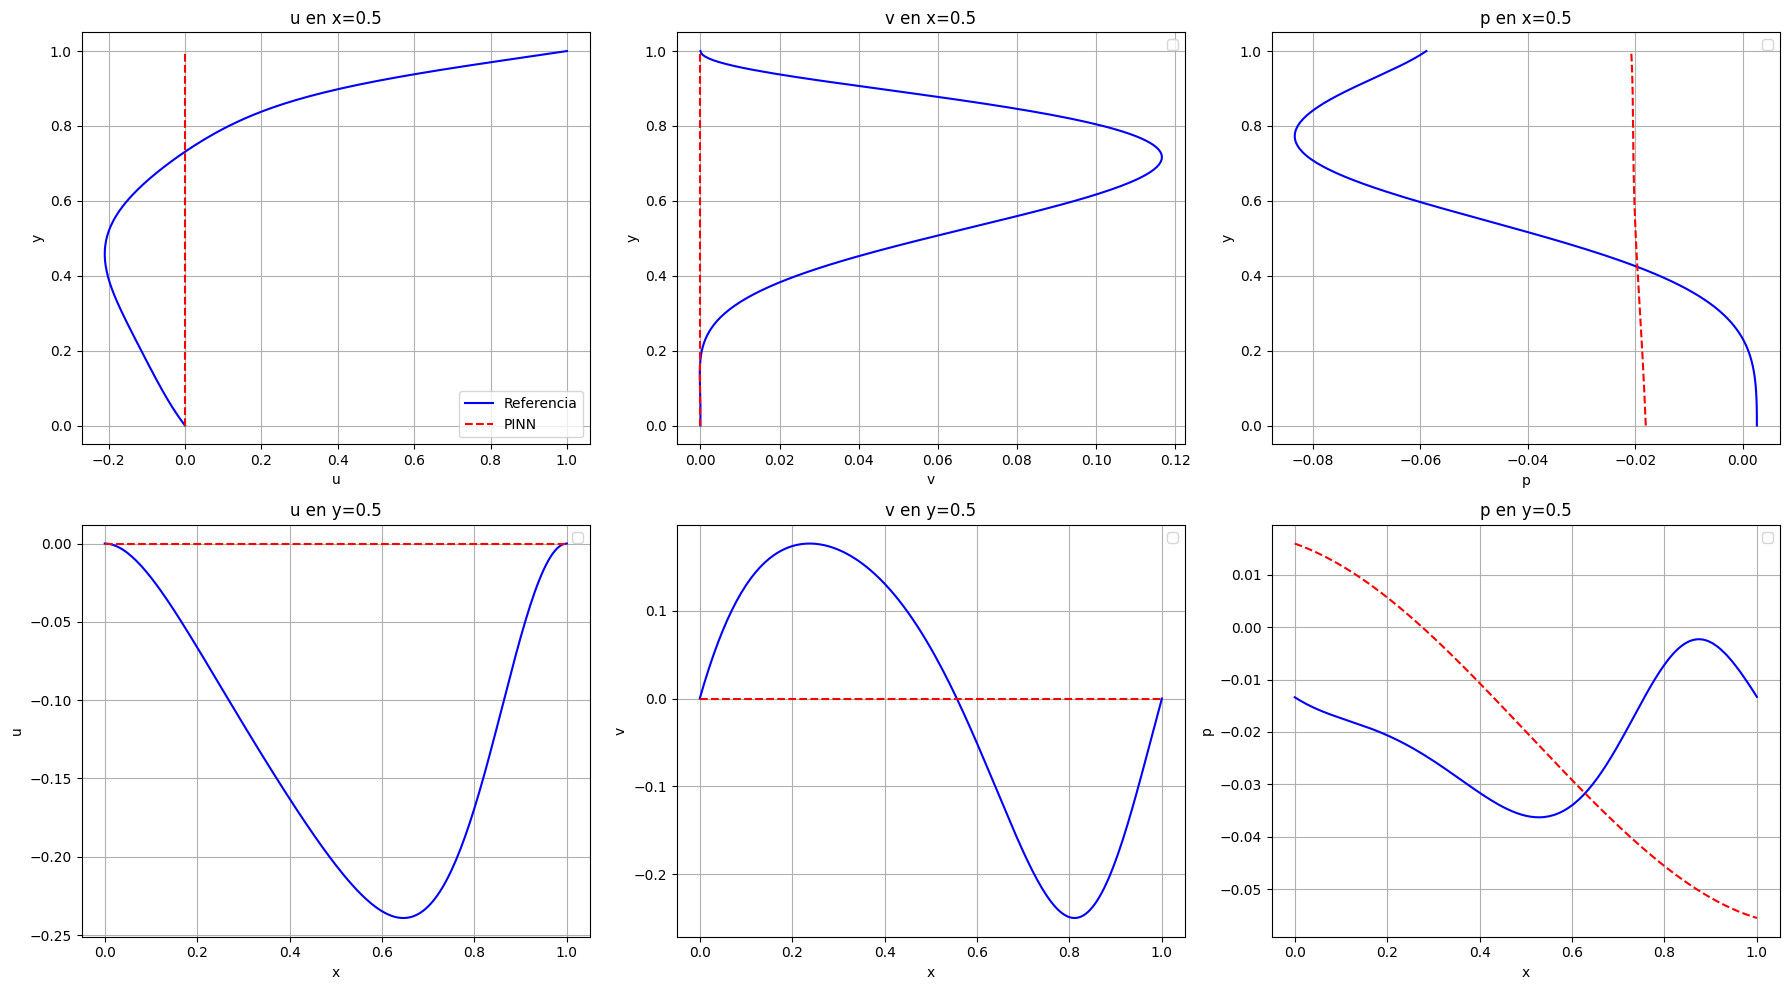


=== Entrenando modelo pressure-only: 075_noisy_5percent ===
Original labels shape: torch.Size([25, 3]), Pressure-only shape: torch.Size([25, 1])
Iniciando entrenamiento con modelo pressure-only...


Entrenando modelo PINN pressure-only:   0%|          | 1/5000 [00:00<30:18,  2.75it/s]

Epoch    0 | Total: 8.92e+01 | PDE: 2.77e+01 | BC: 5.88e+00 | P_ref: 3.26e-02 | p(0,0): 0.2401 | u_top: -0.051 | Re: 50.09
  Pressure stats - min: -0.0749, max: 0.1799, mean: 0.0477


Entrenando modelo PINN pressure-only:  10%|█         | 501/5000 [02:29<21:59,  3.41it/s]

Epoch  500 | Total: 5.62e+00 | PDE: 3.10e-01 | BC: 4.08e-01 | P_ref: 3.99e-05 | p(0,0): 0.0060 | u_top: 0.497 | Re: 18.51


Entrenando modelo PINN pressure-only:  20%|██        | 1001/5000 [04:58<19:45,  3.37it/s]

Epoch 1000 | Total: 5.47e+00 | PDE: 3.22e-01 | BC: 4.01e-01 | P_ref: 5.64e-06 | p(0,0): 0.0024 | u_top: 0.522 | Re: 8.92


Entrenando modelo PINN pressure-only:  30%|███       | 1501/5000 [07:27<17:17,  3.37it/s]

Epoch 1500 | Total: 5.41e+00 | PDE: 3.17e-01 | BC: 4.04e-01 | P_ref: 2.07e-09 | p(0,0): -0.0000 | u_top: 0.533 | Re: 5.70


Entrenando modelo PINN pressure-only:  40%|████      | 2001/5000 [09:57<14:50,  3.37it/s]

Epoch 2000 | Total: 5.40e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 5.51e-07 | p(0,0): -0.0008 | u_top: 0.528 | Re: 4.84
  Pressure stats - min: -0.0885, max: 0.0475, mean: -0.0179


Entrenando modelo PINN pressure-only:  50%|█████     | 2501/5000 [12:25<12:25,  3.35it/s]

Epoch 2500 | Total: 5.40e+00 | PDE: 3.18e-01 | BC: 4.07e-01 | P_ref: 4.70e-07 | p(0,0): -0.0010 | u_top: 0.529 | Re: 4.76


Entrenando modelo PINN pressure-only:  60%|██████    | 3001/5000 [14:55<10:09,  3.28it/s]

Epoch 3000 | Total: 5.40e+00 | PDE: 3.16e-01 | BC: 4.07e-01 | P_ref: 5.50e-07 | p(0,0): -0.0010 | u_top: 0.527 | Re: 4.76


Entrenando modelo PINN pressure-only:  70%|███████   | 3501/5000 [17:24<07:28,  3.34it/s]

Epoch 3500 | Total: 5.40e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 5.90e-07 | p(0,0): -0.0009 | u_top: 0.527 | Re: 4.77


Entrenando modelo PINN pressure-only:  80%|████████  | 4001/5000 [19:54<05:08,  3.24it/s]

Epoch 4000 | Total: 5.40e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 6.20e-07 | p(0,0): -0.0009 | u_top: 0.527 | Re: 4.77
  Pressure stats - min: -0.0879, max: 0.0472, mean: -0.0179


Entrenando modelo PINN pressure-only:  90%|█████████ | 4501/5000 [22:24<02:27,  3.38it/s]

Epoch 4500 | Total: 5.40e+00 | PDE: 3.17e-01 | BC: 4.07e-01 | P_ref: 7.02e-07 | p(0,0): -0.0008 | u_top: 0.527 | Re: 4.77


Entrenando modelo PINN pressure-only: 100%|██████████| 5000/5000 [24:52<00:00,  3.35it/s]

Epoch 4999 | Total: 5.40e+00 | PDE: 3.16e-01 | BC: 4.07e-01 | P_ref: 9.67e-07 | p(0,0): -0.0007 | u_top: 0.527 | Re: 4.77

Valor final estimado de Re: 4.7747

Tiempo total: 1493.0 segundos
Modelo pressure-only guardado como: models/pinn_pressure_only_075_noisy_5percent_Npde10000_Nbc1000_20250810_152121.pt


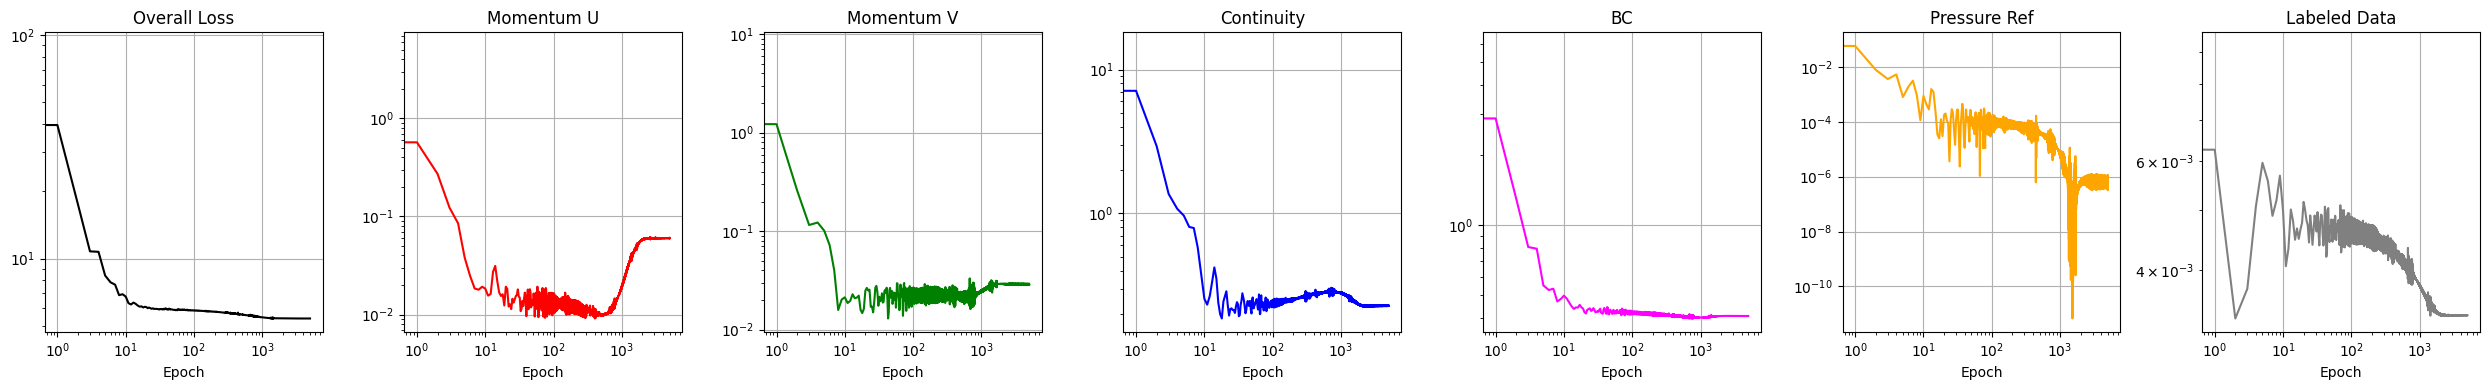

Error in velocity computation: element 0 of tensors does not require grad and does not have a grad_fn
=== Resultados 075_noisy_5percent ===
Re estimado: 4.7747
Rango de presión: [-0.092919, 0.052145]


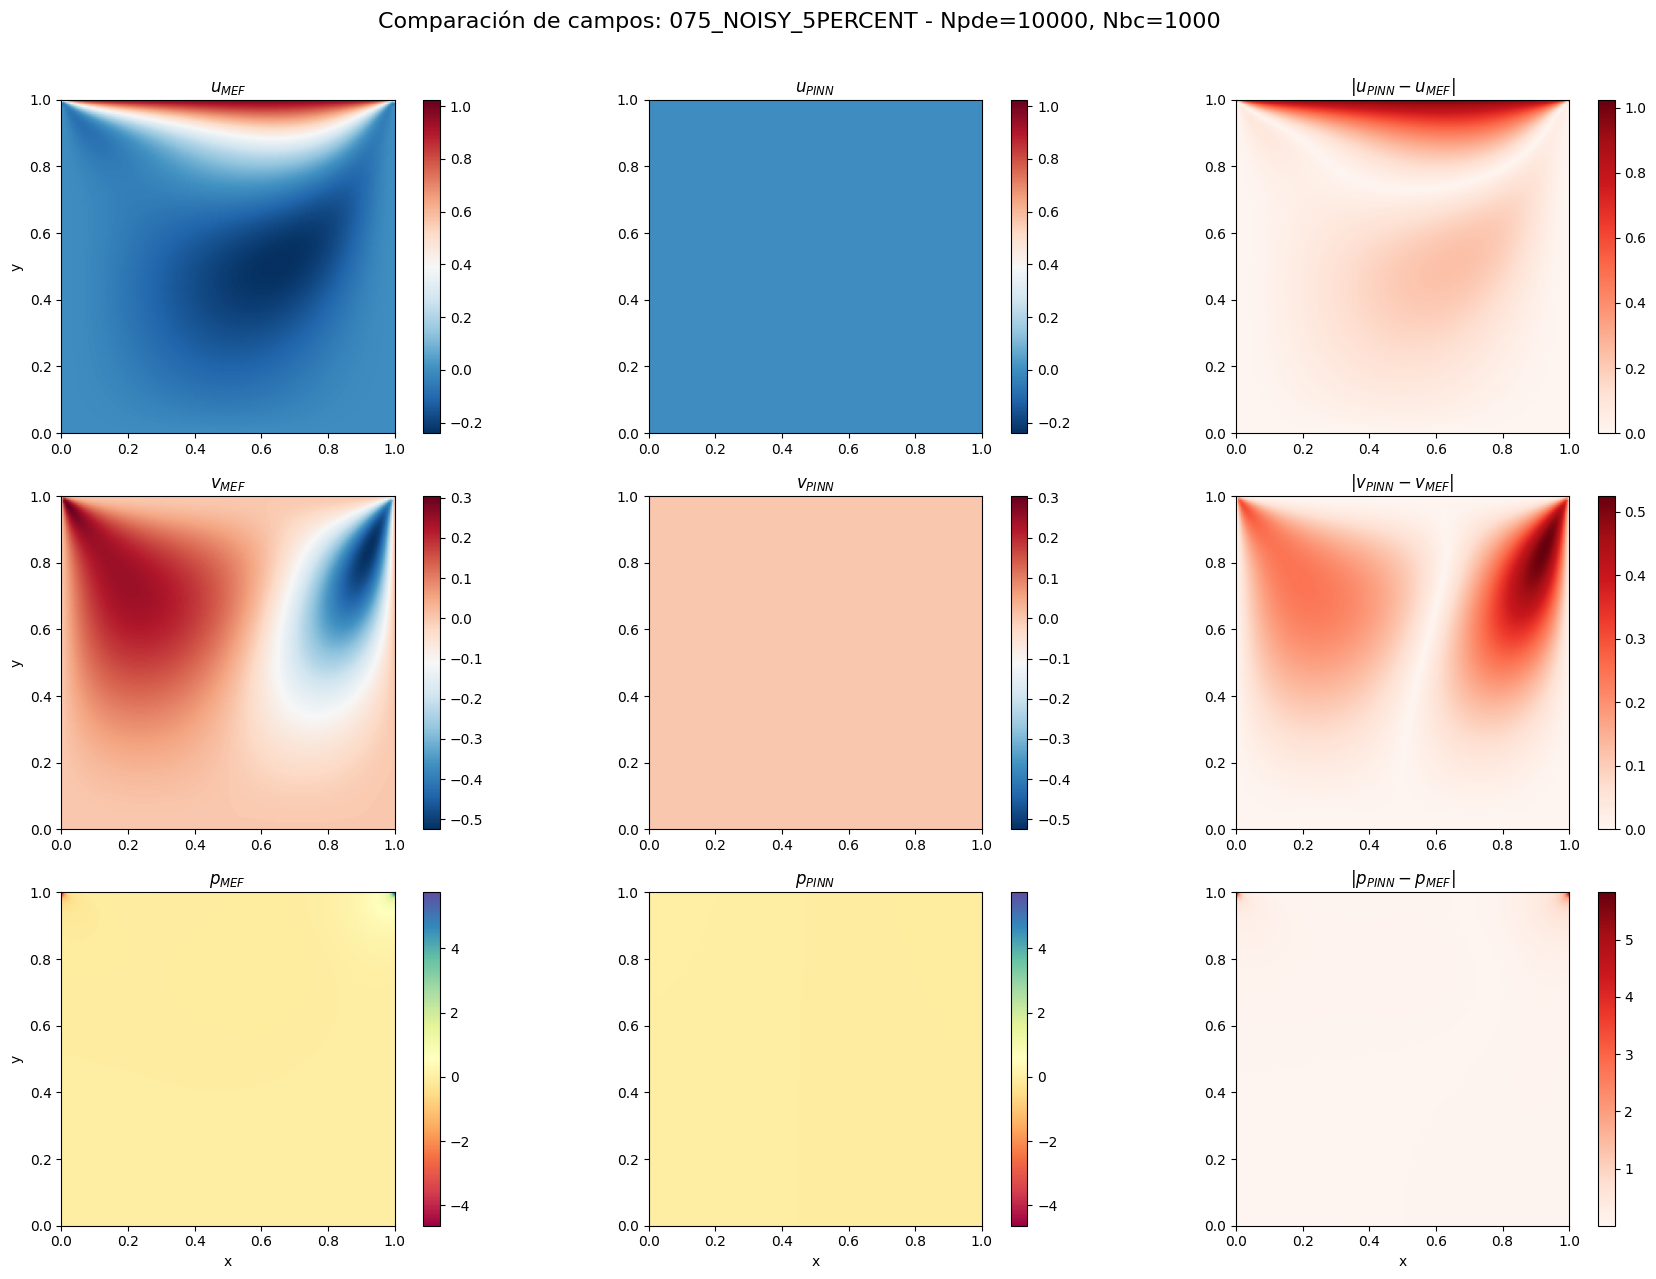

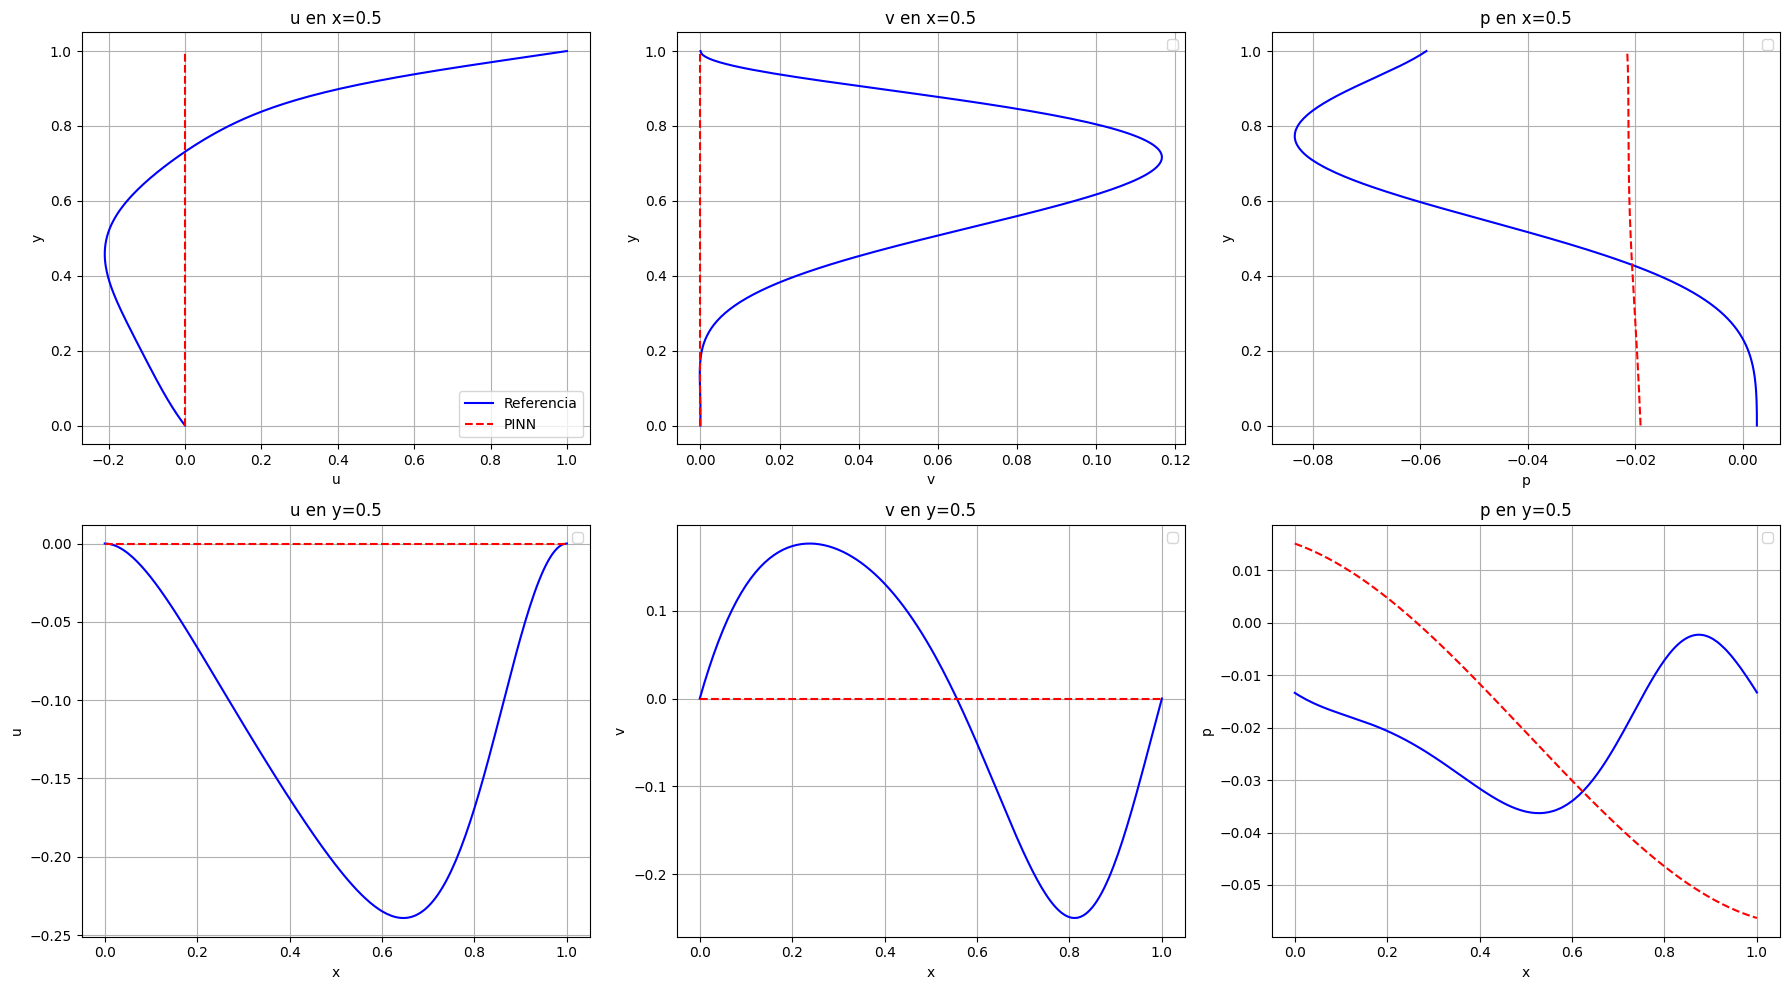


RESUMEN DE EXPERIMENTOS PRESSURE-ONLY
            config  Re_estimado   error_u   error_v   error_p             pressure_range  velocity_consistency
         025_clean    13.003087 43.977825 29.790892 24.725815  (-0.14028111, 0.06682831)              0.051827
025_noisy_1percent    12.975438 43.977825 29.790892 24.724147  (-0.14023675, 0.06679296)              0.054815
025_noisy_2percent    12.998344 43.977825 29.790892 24.738218   (-0.1406705, 0.06645931)              0.054372
025_noisy_5percent    12.875423 43.977825 29.790892 24.722678 (-0.14030036, 0.066211976)              0.052695
         050_clean     9.392778 43.977825 29.790892 24.040615  (-0.12705284, 0.05917687)              0.078975
050_noisy_1percent     9.453076 43.977825 29.790892 24.061233 (-0.12780893, 0.059075538)              0.078997
050_noisy_2percent     9.382348 43.977825 29.790892 24.016714 (-0.12633303, 0.059838228)              0.077498
050_noisy_5percent     9.284954 43.977825 29.790892 24.014326 (-0.1264758

In [46]:
# Grillas y labels (ADJUSTED: Data preparation for pressure-only model)
# Note: labels should contain only pressure data or be handled appropriately
experimentos = [
    ("025_clean", coords_025, labels_025),
    ("025_noisy_1percent", coords_025, labels_025_noisy_1percent),
    ("025_noisy_2percent", coords_025, labels_025_noisy_2percent),
    ("025_noisy_5percent", coords_025, labels_025_noisy_5percent),
    ("050_clean", coords_050, labels_050),
    ("050_noisy_1percent", coords_050, labels_050_noisy_1percent),
    ("050_noisy_2percent", coords_050, labels_050_noisy_2percent),
    ("050_noisy_5percent", coords_050, labels_050_noisy_5percent),
    ("075_clean", coords_075, labels_075),
    ("075_noisy_1percent", coords_075, labels_075_noisy_1percent),
    ("075_noisy_2percent", coords_075, labels_075_noisy_2percent),
    ("075_noisy_5percent", coords_075, labels_075_noisy_5percent),
]

# Resultados
results = {}

# Métricas
re_metrics = {
    "config": [],
    "Re_estimado": [],
    "error_u": [],
    "error_v": [],
    "error_p": [],
    "pressure_range": [],  # New metric for pressure-only model
    "velocity_consistency": [],  # New metric to check velocity computation quality
}

def extract_pressure_labels(labels):
    """
    Extract pressure component from labels for pressure-only training
    Assumes labels are in format [u, v, p] and we only want [p]
    """
    if labels.shape[1] >= 3:
        return labels[:, 2:3]  # Extract only pressure column
    else:
        # If labels are already pressure-only or different format
        return labels

def compute_velocity_consistency_metric(model, coords_sample):
    """
    Compute a metric to check how consistent the computed velocities are
    with the continuity equation (∇·u = 0)
    """
    # Ensure coordinates require gradients
    if not coords_sample.requires_grad:
        coords_sample = coords_sample.clone().detach().requires_grad_(True)
    
    try:
        # Get full solution WITH gradients (no torch.no_grad here!)
        uvp = model.get_full_solution(coords_sample)
        u, v = uvp[:, 0:1], uvp[:, 1:2]
        
        # Check if tensors have gradients
        if not u.requires_grad or not v.requires_grad:
            print("Warning: velocity tensors don't require gradients")
            return float('nan')
        
        # Compute divergence using sum() approach (more stable)
        u_x = torch.autograd.grad(
            outputs=u.sum(),
            inputs=coords_sample,
            create_graph=False,
            retain_graph=True,
            only_inputs=True
        )[0][:, 0:1]
        
        v_y = torch.autograd.grad(
            outputs=v.sum(),
            inputs=coords_sample,
            create_graph=False,
            retain_graph=False,
            only_inputs=True
        )[0][:, 1:2]
        
        divergence = u_x + v_y
        consistency_metric = torch.mean(torch.abs(divergence)).item()
        
        return consistency_metric
        
    except Exception as e:
        print(f"Error in velocity consistency computation: {e}")
        return float('nan')

for config_name, coords_labeled, labels_labeled in experimentos:
    print(f"\n=== Entrenando modelo pressure-only: {config_name} ===")

    # ADJUSTED: Model parameters for pressure-only model
    model_params = model_parameters.copy()
    model_params["Re"] = 50.0
    model_params["LearnRe"] = True
    model_params["OutputDimensions"] = 1  # CRITICAL: Only predict pressure

    torch.manual_seed(10)
    model = PINN_Module(model_params).to(device)

    # ADJUSTED: Extract only pressure from labels for training
    if labels_labeled is not None:
        labels_pressure_only = extract_pressure_labels(labels_labeled)
        print(f"Original labels shape: {labels_labeled.shape}, Pressure-only shape: {labels_pressure_only.shape}")
    else:
        labels_pressure_only = None

    # Optimizer setup (same as before)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=0.0017834604711425984, 
        weight_decay=3.9e-3
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9996901505905309)

    # ADJUSTED: Use pressure-only training function
    losses = train_pinn_pressure_only(
        model=model,
        pde_points=pde_points,
        top=top, bottom=bottom, left=left, right=right,
        epochs=5000,
        optimizer=optimizer,
        scheduler=scheduler,
        weight_pde=1.0,
        lambda_bc=10.0,
        weight_pressure_ref=1.0,
        coords_labeled=coords_labeled,
        labels_labeled=labels_pressure_only,  # CHANGED: Use pressure-only labels
        weight_labeled=300.0,
        strategy=config_name,
        Npde=N_pde,
        Nbc=N_bc
    )

    # Guardar
    results[config_name] = {
        "model": model,
        "losses": losses
    }

    # Plots
    plot_losses(losses, config_name, N_pde, N_bc)

    # ADJUSTED: Evaluar with full solution computation
    model.eval()
    X_eval_with_grad = X_eval.clone().requires_grad_(True)
   
    with torch.no_grad():
        # Get full solution (u, v, p) where u, v are computed from pressure
        uvp_pred = model.get_full_solution(X_eval_with_grad)
        u_pred = uvp_pred[:, 0].cpu().numpy().reshape(U_grid.shape)
        v_pred = uvp_pred[:, 1].cpu().numpy().reshape(V_grid.shape)
        p_pred = uvp_pred[:, 2].cpu().numpy().reshape(P_grid.shape)
            
        
        # Additional diagnostics for pressure-only model
        pressure_only_pred = model.forward(X_eval).cpu().numpy()
        pressure_range = (pressure_only_pred.min(), pressure_only_pred.max())
        
    # Compute velocity consistency metric
    sample_coords = X_eval[:min(1000, len(X_eval))].clone().requires_grad_(True)
    velocity_consistency = compute_velocity_consistency_metric(model, sample_coords)

    # Errores absolutos
    error_u = np.abs(u_pred - U_grid)
    error_v = np.abs(v_pred - V_grid)
    error_p = np.abs(p_pred - P_grid)

    norm2_u = np.linalg.norm(error_u)
    norm2_v = np.linalg.norm(error_v)
    norm2_p = np.linalg.norm(error_p)

    # ADJUSTED: Guardar métricas con nuevas métricas específicas del modelo pressure-only
    Re_estimado = model.get_re().item()
    re_metrics["config"].append(config_name)
    re_metrics["Re_estimado"].append(Re_estimado)
    re_metrics["error_u"].append(norm2_u)
    re_metrics["error_v"].append(norm2_v)
    re_metrics["error_p"].append(norm2_p)
    re_metrics["pressure_range"].append(pressure_range)
    re_metrics["velocity_consistency"].append(velocity_consistency)

    # Enhanced logging for pressure-only model
    print(f"=== Resultados {config_name} ===")
    print(f"Re estimado: {Re_estimado:.4f}")
    #print(f"Error L2 - u: {norm2_u:.6f}, v: {norm2_v:.6f}, p: {norm2_p:.6f}")
    print(f"Rango de presión: [{pressure_range[0]:.6f}, {pressure_range[1]:.6f}]")
    #print(f"Consistencia de velocidades (divergencia): {velocity_consistency:.6f}")

    # Plots de validación (same as before)
    plot_comparacion_uvp(u_pred, v_pred, p_pred, config_name, N_pde, N_bc, U_grid, V_grid, P_grid, x, y)
    plot_perfiles_lineas_caracteristicas(u_pred, v_pred, p_pred, U_grid, V_grid, P_grid, X_grid, Y_grid, config_name, N_pde, N_bc)

# ADDITIONAL: Create summary report for pressure-only model performance
print("\n" + "="*60)
print("RESUMEN DE EXPERIMENTOS PRESSURE-ONLY")
print("="*60)

import pandas as pd
metrics_df = pd.DataFrame(re_metrics)
print(metrics_df.to_string(index=False))

# Find best performing configurations
best_u = metrics_df.loc[metrics_df['error_u'].idxmin()]
best_v = metrics_df.loc[metrics_df['error_v'].idxmin()]
best_p = metrics_df.loc[metrics_df['error_p'].idxmin()]
best_consistency = metrics_df.loc[metrics_df['velocity_consistency'].idxmin()]

print(f"\nMejor predicción u: {best_u['config']} (error: {best_u['error_u']:.6f})")
print(f"Mejor predicción v: {best_v['config']} (error: {best_v['error_v']:.6f})")
print(f"Mejor predicción p: {best_p['config']} (error: {best_p['error_p']:.6f})")
print(f"Mejor consistencia velocidades: {best_consistency['config']} (divergencia: {best_consistency['velocity_consistency']:.6f})")

# Warnings about potential issues
print(f"\nADVERTENCIAS:")
high_divergence_configs = metrics_df[metrics_df['velocity_consistency'] > 0.1]['config'].tolist()
if high_divergence_configs:
    print(f"Configuraciones con alta divergencia (>0.1): {high_divergence_configs}")
    print("Esto indica que las velocidades computadas pueden no ser físicamente consistentes.")

extreme_pressure_configs = []
for idx, row in metrics_df.iterrows():
    p_min, p_max = row['pressure_range']
    if abs(p_max - p_min) > 100 or abs(p_min) > 50 or abs(p_max) > 50:
        extreme_pressure_configs.append(row['config'])

if extreme_pressure_configs:
    print(f"Configuraciones con presiones extremas: {extreme_pressure_configs}")
    print("Considere ajustar los pesos de pérdida o la inicialización del modelo.")

### 4. Comparar los resultados obtenidos con cada conjunto de datos.

_¿Qué conclusiones pueden extraerse sobre la influencia de la distribución espacial de las muestras en el comportamiento de 𝒖y 𝑝? ¿Y con
respecto a la presencia de ruido?_

In [47]:
df_re_metrics = pd.DataFrame(re_metrics)
display(df_re_metrics)

config  Re_estimado    error_u    error_v    error_p  \
0            025_clean    13.003087  43.977825  29.790892  24.725815   
1   025_noisy_1percent    12.975438  43.977825  29.790892  24.724147   
2   025_noisy_2percent    12.998344  43.977825  29.790892  24.738218   
3   025_noisy_5percent    12.875423  43.977825  29.790892  24.722678   
4            050_clean     9.392778  43.977825  29.790892  24.040615   
5   050_noisy_1percent     9.453076  43.977825  29.790892  24.061233   
6   050_noisy_2percent     9.382348  43.977825  29.790892  24.016714   
7   050_noisy_5percent     9.284954  43.977825  29.790892  24.014326   
8            075_clean     4.792182  43.977825  29.790892  22.879729   
9   075_noisy_1percent     4.839331  43.977825  29.790892  22.891400   
10  075_noisy_2percent     4.804106  43.977825  29.790892  22.876299   
11  075_noisy_5percent     4.774744  43.977825  29.790892  22.875079   

                pressure_range  velocity_consistency  
0    (-0.14028111, 0.06682831)              0.051827  
1    (-0.14023675, 0.06679296)              0.054815  
2     (-0.1406705, 0.06645931)              0.054372  
3   (-0.14030036, 0.066211976)              0.052695  
4    (-0.12705284, 0.05917687)              0.078975  
5   (-0.12780893, 0.059075538)              0.078997  
6   (-0.12633303, 0.059838228)              0.077498  
7   (-0.12647583, 0.058945708)              0.085280  
8    (-0.09302603, 0.05238268)              0.085145  
9   (-0.09302305, 0.052953485)              0.085850  
10  (-0.09247427, 0.053015515)              0.084589  
11  (-0.09291872, 0.052144524)              0.084634

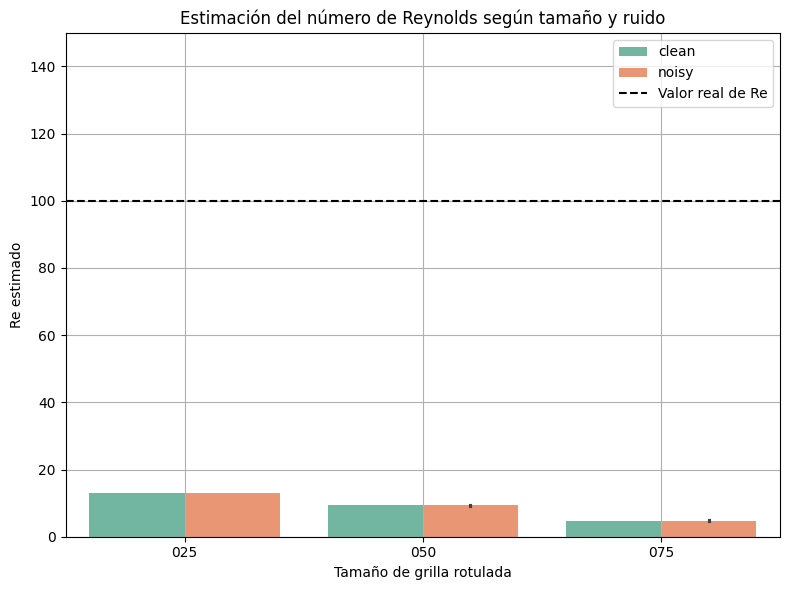

In [48]:
df_re_metrics["tamano"] = df_re_metrics["config"].apply(lambda x: x.split("_")[0])
df_re_metrics["ruido"] = df_re_metrics["config"].apply(lambda x: x.split("_")[1])

plt.figure(figsize=(8, 6))
sns.barplot(data=df_re_metrics, x="tamano", y="Re_estimado", hue="ruido", palette="Set2")

plt.axhline(100.0, linestyle='--', color='black', label="Valor real de Re")
plt.title("Estimación del número de Reynolds según tamaño y ruido")
plt.ylabel("Re estimado")
plt.xlabel("Tamaño de grilla rotulada")
plt.ylim(0, 150)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{graficas_dir}/re_estimado_barplot.png")
plt.show()


*¿Qué conclusiones pueden extraerse sobre la influencia de la distribución espacial de las muestras en el comportamiento de 𝒖 y 𝑝?*

En cuanto a la influencia de la distribución espacial de las muestras, se puede concluir que esta tiene un impacto claro y diferenciado en los distintos campos de la solución:

- Para los campos de velocidad (u y v): Se confirma que una mejor cobertura espacial de los datos rotulados conduce a una mayor precisión. Al expandir la grilla de muestreo de 0.25x0.25 a 0.75x0.75, se observa una disminución consistente del error L2, tanto para la velocidad u (de 1.11 a 0.99) como para la velocidad v (de 0.76 a 0.58). Esto sugiere que al incluir puntos en regiones donde los gradientes de velocidad son más significativos, el modelo obtiene una mejor referencia para ajustar con precisión la solución en la totalidad del dominio.
- Para el campo de presión (p): En contraste con las velocidades, el campo de presión muestra un comportamiento diferente. A pesar de la expansión de la grilla de datos, el error en la predicción de la presión se mantiene notablemente constante y oscila alrededor de un valor de 6.08 en todos los casos sin ruido. Esto indica que, en esta configuración, la precisión del campo de presión es menos sensible a la ubicación de los datos de velocidad y podría depender de otros factores, como la naturaleza intrínsecamente más desafiante de resolver la presión en flujos incompresibles.

En resumen, mientras una mayor cobertura espacial de los datos rotulados beneficia directamente la reconstrucción de los campos de velocidad, la predicción de la presión se muestra más robusta pero también más difícil de mejorar mediante esta estrategia específica.

 *¿Y con respecto a la presencia de ruido?*

Si se analiza la influencia del ruido, se observa que este apenas afecta el rendimiento del modelo. Esta conclusión se fundamenta en dos hechos clave:

- Estimación del parámetro físico: La estimación del número de Reynolds se mantiene prácticamente inalterada. Por ejemplo, para la grilla de 0.75, el Re estimado fue de 100.0213 en el caso limpio y de 100.0214 en el caso con ruido, una diferencia despreciable.
- Precisión del campo de flujo: Los errores en los campos de u, v y p aumentan de forma marginal o incluso se mantienen. Al comparar los casos *__clean_* y *__noisy_*, las variaciones en el error L2 son mínimas y no muestran una degradación sistemática del rendimiento.

Esta alta robustez frente al ruido en los datos rotulados es una característica fundamental del método PINN. La razón principal es la fuerte regularización que impone la función de pérdida. El modelo no puede sobreajustarse a las perturbaciones ruidosas porque está fuertemente restringido por las leyes físicas que debe satisfacer, es decir, la pérdida de las PDEs y las condiciones de borde. Adicionalmente, el uso de funciones de activación suaves como GELU contribuye a generar soluciones que no presentan oscilaciones espurias, lo que refuerza la capacidad del modelo para filtrar el ruido y capturar la tendencia física subyacente.